# Time Series Forecasting using historical sales data
## 1. Data Preparation and Exploration
### Import Libraries

In [50]:
%matplotlib inline

import pandas as pd
from darts import TimeSeries
from darts.models import ExponentialSmoothing
from darts.metrics import mape
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import concurrent.futures
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from pmdarima import auto_arima
import matplotlib.pyplot as plt
import seaborn as sns


# Suppress specific warnings
warnings.filterwarnings("ignore")

### Load Data

In [51]:
data = pd.read_csv('practise_data_with_ABN_till_dec.csv')
data

MaterialNumber  04-01-2015  05-01-2015  06-01-2015  07-01-2015  \
0                AB           0           0           0           0   
1               ABC           0           0           0           0   
2              ABCD           0           0           0           0   
3             ABCDE           0           0           0           0   
4            ABCDEF           0           0           0           0   
5           ABCDEFG           0           0           0           0   
6          ABCDEFGH           0           0           0           0   
7         ABCDEFGHI           0           0           0           0   
8        ABCDEFGHIJ           0           0           0           0   
9       ABCDEFGHIJK           0           0           0           0   
10     ABCDEFGHIJKL           0           0           0           0   
11    ABCDEFGHIJKLM           0           0           0           0   
12   ABCDEFGHIJKLMN           0           0           0           0   
13  ABCDEFGHIJKLMNO           0           0           0           0   

    08-01-2015  09-01-2015  10-01-2015  11-01-2015  12-01-2015  ...  \
0            0           0           0           0           0  ...   
1            0           0           0           0           0  ...   
2            0           0           0           0           0  ...   
3            0           0           0           0           0  ...   
4            0           0           0           0           0  ...   
5            0           0           0           0           0  ...   
6            0           0           0           0           0  ...   
7            0           0           0           0           0  ...   
8            0           0           0           0           0  ...   
9            0           0           0           0           0  ...   
10           0           0           0           0           0  ...   
11           0           0           0           0           0  ...   
12           0           0           0           0           0  ...   
13           0           0           0           0           0  ...   

    03-01-2022  04-01-2022  05-01-2022  06-01-2022  07-01-2022  08-01-2022  \
0           49          84          81        2229         940         401   
1           76          58         159        2316        1080         600   
2           65          42          83        4822        1460         809   
3           45          11          25         932         544         287   
4           17           5          10         796         458         197   
5           13           1           3         714         476         167   
6            0           0           0        2235         803         353   
7            0           0           0        1046         384         265   
8            0           0           0         939         633         337   
9           44          38          85        1971         726         373   
10           2           6          14         315         180         128   
11           7          11          20         816         229         200   
12          15           7          49        1073         224         284   
13         138         212         493        8893        3544        2788   

    09-01-2022  10-01-2022  11-01-2022  12-01-2022  
0          559         911        1529         442  
1         1227        1516        1569         648  
2         1436        2003        2018         836  
3          225         440         521         200  
4          131         352         280         101  
5           67         231         216         104  
6          320         599         676         163  
7          288         518         443         148  
8          339         511         572         257  
9          262         530         751         289  
10          71         133         156          30  
11         221         340         189          78  
12         37

### Data Reshape from wide to long format

In [52]:
# Reshape the data to long format
data_long = pd.melt(data, id_vars=['MaterialNumber'], var_name='Date', value_name='Count')
data_long

MaterialNumber        Date  Count
0                  AB  04-01-2015      0
1                 ABC  04-01-2015      0
2                ABCD  04-01-2015      0
3               ABCDE  04-01-2015      0
4              ABCDEF  04-01-2015      0
...               ...         ...    ...
1297      ABCDEFGHIJK  12-01-2022    289
1298     ABCDEFGHIJKL  12-01-2022     30
1299    ABCDEFGHIJKLM  12-01-2022     78
1300   ABCDEFGHIJKLMN  12-01-2022    113
1301  ABCDEFGHIJKLMNO  12-01-2022   2781

[1302 rows x 3 columns]

### Changing data frame to time series

In [53]:
data_long['Date'] = pd.to_datetime(data_long['Date'], format='%m-%d-%Y', errors='coerce')
data_long

MaterialNumber       Date  Count
0                  AB 2015-04-01      0
1                 ABC 2015-04-01      0
2                ABCD 2015-04-01      0
3               ABCDE 2015-04-01      0
4              ABCDEF 2015-04-01      0
...               ...        ...    ...
1297      ABCDEFGHIJK 2022-12-01    289
1298     ABCDEFGHIJKL 2022-12-01     30
1299    ABCDEFGHIJKLM 2022-12-01     78
1300   ABCDEFGHIJKLMN 2022-12-01    113
1301  ABCDEFGHIJKLMNO 2022-12-01   2781

[1302 rows x 3 columns]

### Select data for a single material

In [54]:
material = data_long[data_long['MaterialNumber'] == 'AB']  # Replace 'AB' with the desired material number
material

MaterialNumber       Date  Count
0                AB 2015-04-01      0
14               AB 2015-05-01      0
28               AB 2015-06-01      0
42               AB 2015-07-01      0
56               AB 2015-08-01      0
...             ...        ...    ...
1232             AB 2022-08-01    401
1246             AB 2022-09-01    559
1260             AB 2022-10-01    911
1274             AB 2022-11-01   1529
1288             AB 2022-12-01    442

[93 rows x 3 columns]

In [55]:
# Material list
materials = data['MaterialNumber']
materials

0                  AB
1                 ABC
2                ABCD
3               ABCDE
4              ABCDEF
5             ABCDEFG
6            ABCDEFGH
7           ABCDEFGHI
8          ABCDEFGHIJ
9         ABCDEFGHIJK
10       ABCDEFGHIJKL
11      ABCDEFGHIJKLM
12     ABCDEFGHIJKLMN
13    ABCDEFGHIJKLMNO
Name: MaterialNumber, dtype: object

### create different series for each material

In [56]:
material_dataframes = {}  # Dictionary to store dataframes

for material in materials:
    material_name = material  # Store the material name
    filtered_df = data_long[data_long['MaterialNumber'] == material]  # Filter the dataframe by material number
    material_dataframes[material_name] = filtered_df  # Assign the dataframe to the dictionary with material name as key

material_dataframes


{'AB':      MaterialNumber       Date  Count
 0                AB 2015-04-01      0
 14               AB 2015-05-01      0
 28               AB 2015-06-01      0
 42               AB 2015-07-01      0
 56               AB 2015-08-01      0
 ...             ...        ...    ...
 1232             AB 2022-08-01    401
 1246             AB 2022-09-01    559
 1260             AB 2022-10-01    911
 1274             AB 2022-11-01   1529
 1288             AB 2022-12-01    442
 
 [93 rows x 3 columns],
 'ABC':      MaterialNumber       Date  Count
 1               ABC 2015-04-01      0
 15              ABC 2015-05-01      0
 29              ABC 2015-06-01      0
 43              ABC 2015-07-01      0
 57              ABC 2015-08-01      0
 ...             ...        ...    ...
 1233            ABC 2022-08-01    600
 1247            ABC 2022-09-01   1227
 1261            ABC 2022-10-01   1516
 1275            ABC 2022-11-01   1569
 1289            ABC 2022-12-01    648
 
 [93 rows x 3 columns],

### Data cleaning

In [57]:
for material_name, df in material_dataframes.items():
    print(f"Missing values for {material_name}:")
    print(df.isna().sum())
    print()  

Missing values for AB:
MaterialNumber    0
Date              0
Count             0
dtype: int64

Missing values for ABC:
MaterialNumber    0
Date              0
Count             0
dtype: int64

Missing values for ABCD:
MaterialNumber    0
Date              0
Count             0
dtype: int64

Missing values for ABCDE:
MaterialNumber    0
Date              0
Count             0
dtype: int64

Missing values for ABCDEF:
MaterialNumber    0
Date              0
Count             0
dtype: int64

Missing values for ABCDEFG:
MaterialNumber    0
Date              0
Count             0
dtype: int64

Missing values for ABCDEFGH:
MaterialNumber    0
Date              0
Count             0
dtype: int64

Missing values for ABCDEFGHI:
MaterialNumber    0
Date              0
Count             0
dtype: int64

Missing values for ABCDEFGHIJ:
MaterialNumber    0
Date              0
Count             0
dtype: int64

Missing values for ABCDEFGHIJK:
MaterialNumber    0
Date              0
Count             0

### Exploratory Analysis

In [58]:
for material_name, df in material_dataframes.items():
    df = df.drop(columns='MaterialNumber', axis=1)
    material_dataframes[material_name] = df  # Update the dictionary with the modified dataframe
    print(f"{material_name}:")
    print(df.head())
    print()

AB:
         Date  Count
0  2015-04-01      0
14 2015-05-01      0
28 2015-06-01      0
42 2015-07-01      0
56 2015-08-01      0

ABC:
         Date  Count
1  2015-04-01      0
15 2015-05-01      0
29 2015-06-01      0
43 2015-07-01      0
57 2015-08-01      0

ABCD:
         Date  Count
2  2015-04-01      0
16 2015-05-01      0
30 2015-06-01      0
44 2015-07-01      0
58 2015-08-01      0

ABCDE:
         Date  Count
3  2015-04-01      0
17 2015-05-01      0
31 2015-06-01      0
45 2015-07-01      0
59 2015-08-01      0

ABCDEF:
         Date  Count
4  2015-04-01      0
18 2015-05-01      0
32 2015-06-01      0
46 2015-07-01      0
60 2015-08-01      0

ABCDEFG:
         Date  Count
5  2015-04-01      0
19 2015-05-01      0
33 2015-06-01      0
47 2015-07-01      0
61 2015-08-01      0

ABCDEFGH:
         Date  Count
6  2015-04-01      0
20 2015-05-01      0
34 2015-06-01      0
48 2015-07-01      0
62 2015-08-01      0

ABCDEFGHI:
         Date  Count
7  2015-04-01      0
21 2015-0

In [59]:
# Convert 'Date' column to datetime
for material_name, df in material_dataframes.items():
    df['Date'] = pd.to_datetime(df['Date'])
    material_dataframes[material_name] = df  
    print(f"{material_name}:")
    print(df.head())
    print()

AB:
         Date  Count
0  2015-04-01      0
14 2015-05-01      0
28 2015-06-01      0
42 2015-07-01      0
56 2015-08-01      0

ABC:
         Date  Count
1  2015-04-01      0
15 2015-05-01      0
29 2015-06-01      0
43 2015-07-01      0
57 2015-08-01      0

ABCD:
         Date  Count
2  2015-04-01      0
16 2015-05-01      0
30 2015-06-01      0
44 2015-07-01      0
58 2015-08-01      0

ABCDE:
         Date  Count
3  2015-04-01      0
17 2015-05-01      0
31 2015-06-01      0
45 2015-07-01      0
59 2015-08-01      0

ABCDEF:
         Date  Count
4  2015-04-01      0
18 2015-05-01      0
32 2015-06-01      0
46 2015-07-01      0
60 2015-08-01      0

ABCDEFG:
         Date  Count
5  2015-04-01      0
19 2015-05-01      0
33 2015-06-01      0
47 2015-07-01      0
61 2015-08-01      0

ABCDEFGH:
         Date  Count
6  2015-04-01      0
20 2015-05-01      0
34 2015-06-01      0
48 2015-07-01      0
62 2015-08-01      0

ABCDEFGHI:
         Date  Count
7  2015-04-01      0
21 2015-0

In [60]:
# Set 'Date' column as index
for material_name, df in material_dataframes.items():
    df.set_index('Date', inplace=True)
    print(f"{material_name}:")
    print(df)
    print()

AB:
            Count
Date             
2015-04-01      0
2015-05-01      0
2015-06-01      0
2015-07-01      0
2015-08-01      0
...           ...
2022-08-01    401
2022-09-01    559
2022-10-01    911
2022-11-01   1529
2022-12-01    442

[93 rows x 1 columns]

ABC:
            Count
Date             
2015-04-01      0
2015-05-01      0
2015-06-01      0
2015-07-01      0
2015-08-01      0
...           ...
2022-08-01    600
2022-09-01   1227
2022-10-01   1516
2022-11-01   1569
2022-12-01    648

[93 rows x 1 columns]

ABCD:
            Count
Date             
2015-04-01      0
2015-05-01      0
2015-06-01      0
2015-07-01      0
2015-08-01      0
...           ...
2022-08-01    809
2022-09-01   1436
2022-10-01   2003
2022-11-01   2018
2022-12-01    836

[93 rows x 1 columns]

ABCDE:
            Count
Date             
2015-04-01      0
2015-05-01      0
2015-06-01      0
2015-07-01      0
2015-08-01      0
...           ...
2022-08-01    287
2022-09-01    225
2022-10-01    440
2022-1

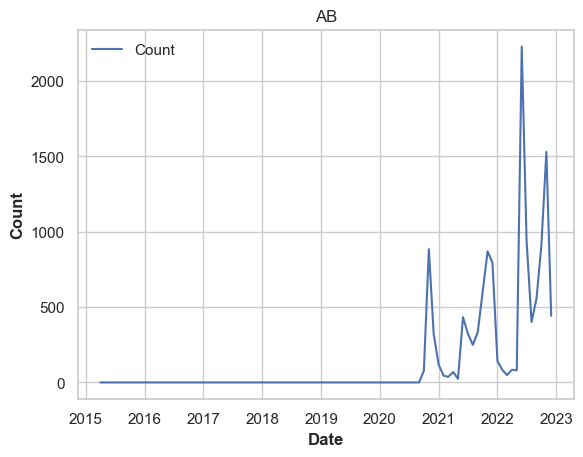

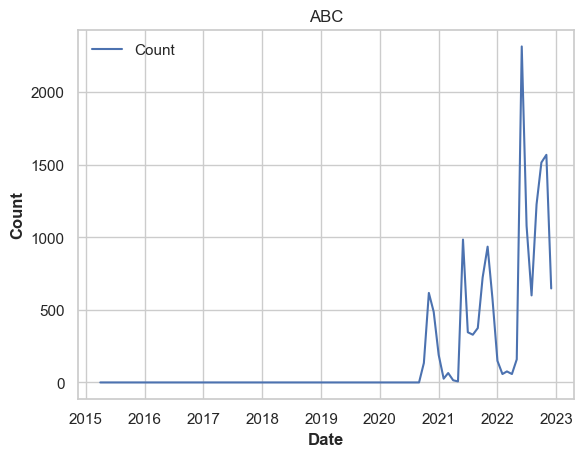

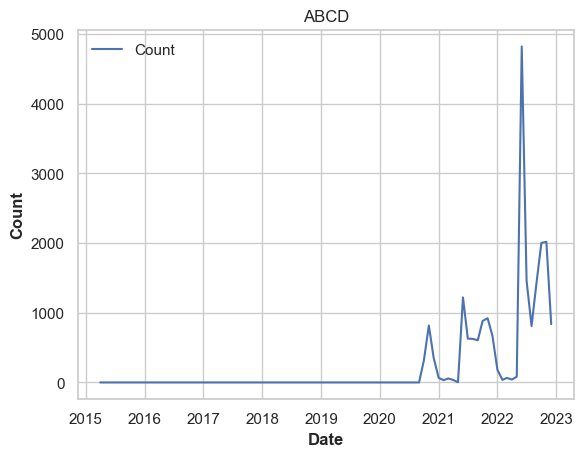

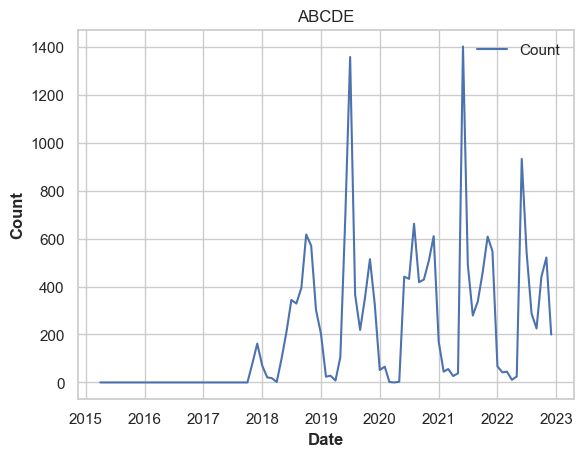

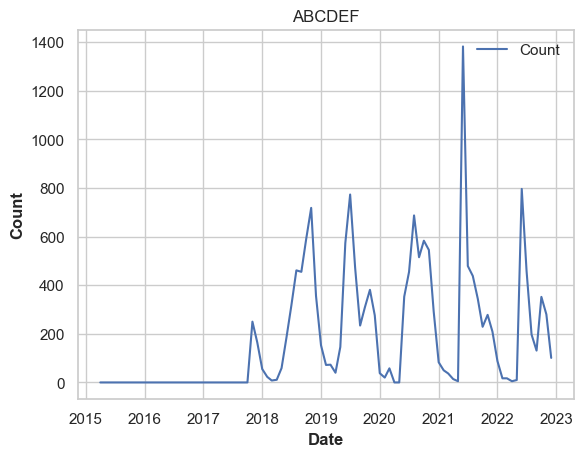

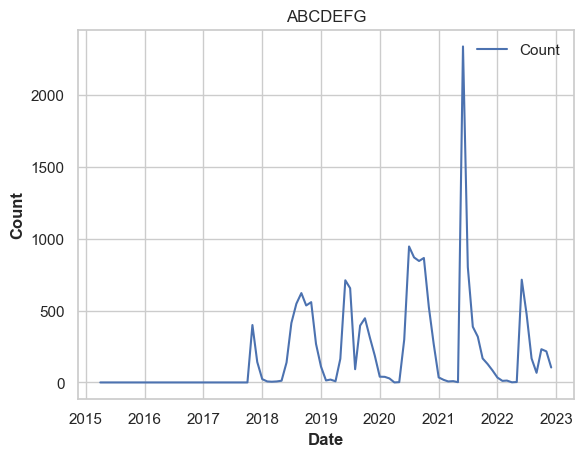

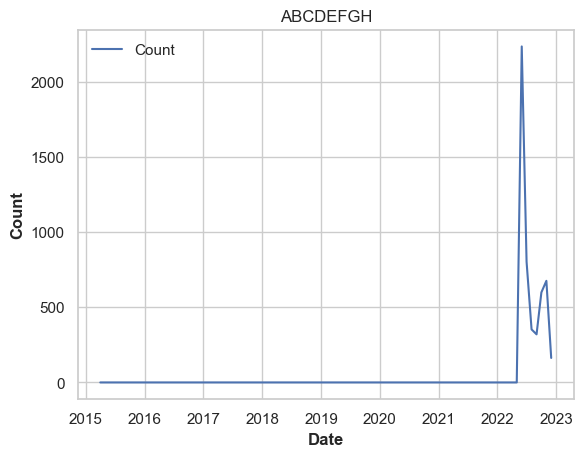

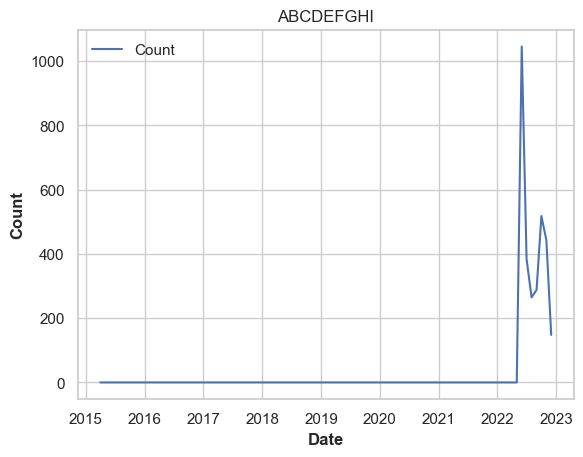

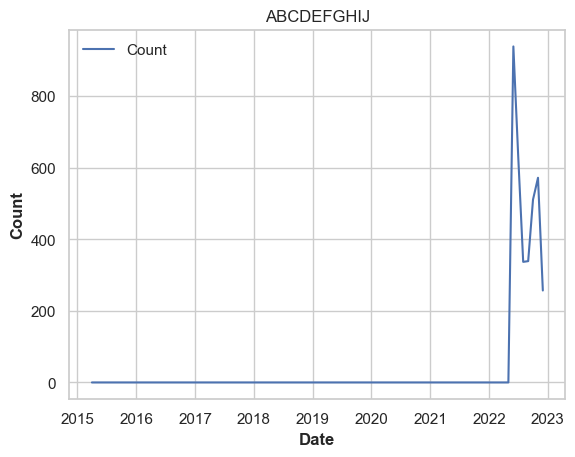

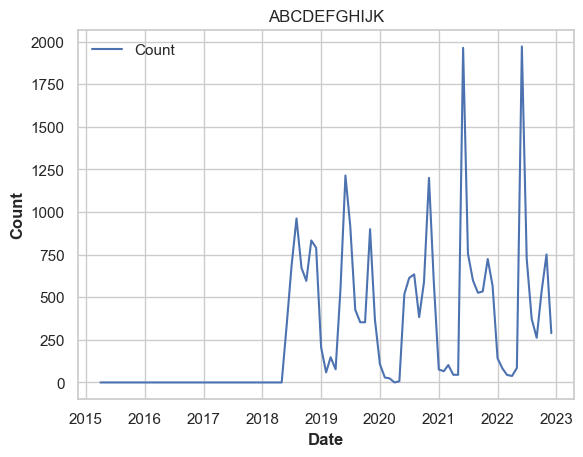

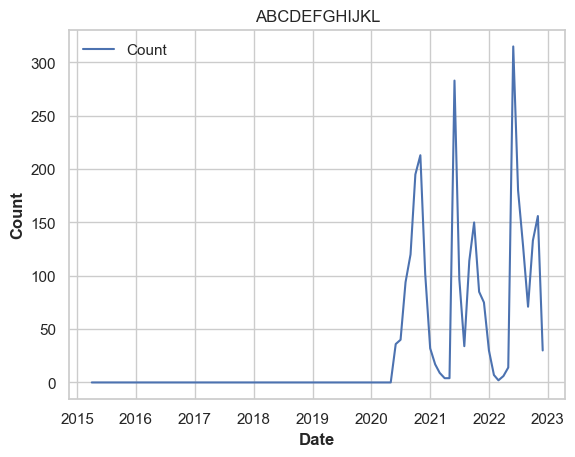

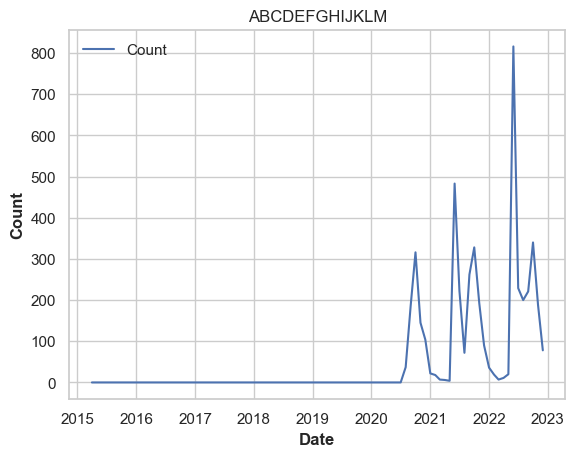

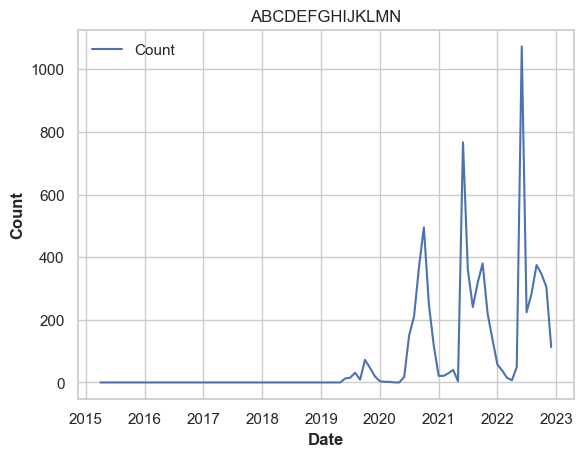

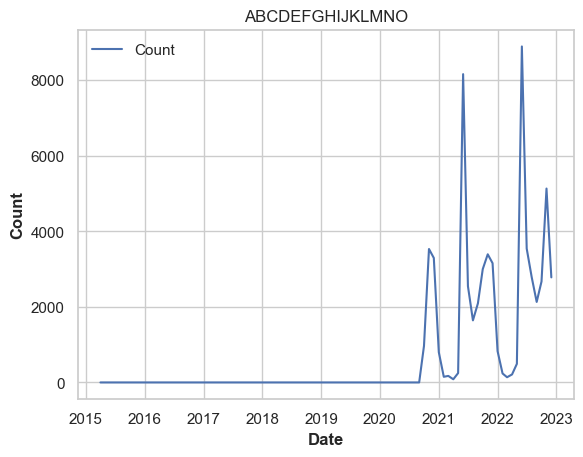

In [61]:
# Plotting the dataframes
for material_name, df in material_dataframes.items():
    sns.set(style="whitegrid")  
    sns.lineplot(data=df, x='Date', y='Count', label='Count')
    plt.title(material_name)
    plt.show()  
    print()

#looks seasonal

## Test for Stationarity

In [62]:
from statsmodels.tsa.stattools import adfuller

In [63]:
adf_results = pd.DataFrame(columns=['MaterialName', 'ADF Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used', 'Critical Values','Stationary'])

#HO: It is non stationary
#H1: It is stationary

adf_results_list = []

for material_name, df in material_dataframes.items():    
    adf_test_result = adfuller(df['Count'])    
    critical_values = ', '.join([f"{k}: {v:.3f}" for k, v in adf_test_result[4].items()])

    is_stationary = adf_test_result[1] < 0.05 # reject null if less than 0.05
    
    test_result_summary = {
        'MaterialName': material_name,
        'ADF Test Statistic': adf_test_result[0],
        'p-value': adf_test_result[1],
        '#Lags Used': adf_test_result[2],
        'Number of Observations Used': adf_test_result[3],
        'Critical Values': critical_values,
        'Stationary': 'Yes' if is_stationary else 'No'
    }
    adf_results_list.append(test_result_summary)

adf_results = pd.DataFrame(adf_results_list)

adf_results


MaterialName  ADF Test Statistic       p-value  #Lags Used  \
0                AB            6.777229  1.000000e+00          11   
1               ABC            3.636230  1.000000e+00          12   
2              ABCD            4.274989  1.000000e+00          12   
3             ABCDE           -1.191345  6.773076e-01          11   
4            ABCDEF           -1.401036  5.817794e-01          12   
5           ABCDEFG           -5.545876  1.661389e-06           0   
6          ABCDEFGH           -6.143645  7.861643e-08           0   
7         ABCDEFGHI           -1.149805  6.948075e-01           3   
8        ABCDEFGHIJ           -1.950724  3.085876e-01           5   
9       ABCDEFGHIJK           -1.338864  6.112100e-01          12   
10     ABCDEFGHIJKL            0.071592  9.640671e-01          12   
11    ABCDEFGHIJKLM            1.516679  9.975848e-01          12   
12   ABCDEFGHIJKLMN            0.511287  9.852121e-01          12   
13  ABCDEFGHIJKLMNO            0.938066  9.935675e-01          12   

    Number of Observations Used                      Critical Values  \
0                            81  1%: -3.514, 5%: -2.898, 10%: -2.586   
1                            80  1%: -3.515, 5%: -2.898, 10%: -2.586   
2                            80  1%: -3.515, 5%: -2.898, 10%: -2.586   
3                            81  1%: -3.514, 5%: -2.898, 10%: -2.586   
4                            80  1%: -3.515, 5%: -2.898, 10%: -2.586   
5                            92  1%: -3.504, 5%: -2.894, 10%: -2.584   
6                            92  1%: -3.504, 5%: -2.894, 10%: -2.584   
7                            89  1%: -3.506, 5%: -2.895, 10%: -2.584   
8                            87  1%: -3.508, 5%: -2.895, 10%: -2.585   
9                            80  1%: -3.515, 5%: -2.898, 10%: -2.586   
10                           80  1%: -3.515, 5%: -2.898, 10%: -2.586   
11                           80  1%: -3.515, 5%: -2.898, 10%: -2.586   
12                           80  1%: -3.515, 5%: -2.898, 10%: -2.586   
13                           80  1%: -3.515, 5%: -2.898, 10%: -2.586   

   Stationary  
0          No  
1          No  
2          No  
3          No  
4          No  
5         Yes  
6         Yes  
7          No  
8          No  
9          No  
10         No  
11         No  
12         No  
13         No

### Differencing
#### Some data is non stationary

In [64]:
# Using 12 month

adf_results_list = []

for material_name, df in material_dataframes.items():
    if material_name not in adf_results[adf_results['Stationary']=='Yes']['MaterialName']:
        df['Seasonal 12 First Difference']=df['Count']-df['Count'].shift(12)
        adf_test_result = adfuller(df['Seasonal 12 First Difference'].dropna())
        critical_values = ', '.join([f"{k}: {v:.3f}" for k, v in adf_test_result[4].items()])    
        is_stationary = adf_test_result[1] < 0.05 # reject null if less than 0.05        
        test_result_summary = {
            'MaterialName': material_name,
            'ADF Test Statistic': adf_test_result[0],
            'p-value': adf_test_result[1],
            '#Lags Used': adf_test_result[2],
            'Number of Observations Used': adf_test_result[3],
            'Critical Values': critical_values,
            'Stationary': 'Yes' if is_stationary else 'No'
        }
        adf_results_list.append(test_result_summary)

adf_results = pd.DataFrame(adf_results_list)
        
adf_results


MaterialName  ADF Test Statistic       p-value  #Lags Used  \
0                AB            1.725510  9.981892e-01          12   
1               ABC            1.163250  9.957219e-01          12   
2              ABCD            1.996666  9.986686e-01          12   
3             ABCDE           -1.826114  3.675762e-01          12   
4            ABCDEF           -2.052825  2.639018e-01          12   
5           ABCDEFG           -3.182332  2.103044e-02          11   
6          ABCDEFGH           -5.748133  6.054013e-07           0   
7         ABCDEFGHI           -1.097781  7.159561e-01           3   
8        ABCDEFGHIJ           -0.927401  7.788149e-01           3   
9       ABCDEFGHIJK           -4.684074  9.014490e-05           0   
10     ABCDEFGHIJKL           -2.693429  7.518220e-02           8   
11    ABCDEFGHIJKLM           -1.330899  6.149201e-01          12   
12   ABCDEFGHIJKLMN           -6.021071  1.493308e-07           0   
13  ABCDEFGHIJKLMNO           -5.747941  6.059876e-07           0   

    Number of Observations Used                      Critical Values  \
0                            68  1%: -3.530, 5%: -2.905, 10%: -2.590   
1                            68  1%: -3.530, 5%: -2.905, 10%: -2.590   
2                            68  1%: -3.530, 5%: -2.905, 10%: -2.590   
3                            68  1%: -3.530, 5%: -2.905, 10%: -2.590   
4                            68  1%: -3.530, 5%: -2.905, 10%: -2.590   
5                            69  1%: -3.529, 5%: -2.904, 10%: -2.590   
6                            80  1%: -3.515, 5%: -2.898, 10%: -2.586   
7                            77  1%: -3.518, 5%: -2.900, 10%: -2.587   
8                            77  1%: -3.518, 5%: -2.900, 10%: -2.587   
9                            80  1%: -3.515, 5%: -2.898, 10%: -2.586   
10                           72  1%: -3.525, 5%: -2.903, 10%: -2.589   
11                           68  1%: -3.530, 5%: -2.905, 10%: -2.590   
12                           80  1%: -3.515, 5%: -2.898, 10%: -2.586   
13                           80  1%: -3.515, 5%: -2.898, 10%: -2.586   

   Stationary  
0          No  
1          No  
2          No  
3          No  
4          No  
5         Yes  
6         Yes  
7          No  
8          No  
9         Yes  
10         No  
11         No  
12        Yes  
13        Yes

In [65]:
# Using 24 month

adf_results_list = []

for material_name, df in material_dataframes.items():
    if material_name not in adf_results[adf_results['Stationary']=='Yes']['MaterialName']:
        df['Seasonal 24 First Difference']=df['Count']-df['Count'].shift(24)
        adf_test_result = adfuller(df['Seasonal 24 First Difference'].dropna())
        critical_values = ', '.join([f"{k}: {v:.3f}" for k, v in adf_test_result[4].items()])    
        is_stationary = adf_test_result[1] < 0.05 # reject null if less than 0.05        
        test_result_summary = {
            'MaterialName': material_name,
            'ADF Test Statistic': adf_test_result[0],
            'p-value': adf_test_result[1],
            '#Lags Used': adf_test_result[2],
            'Number of Observations Used': adf_test_result[3],
            'Critical Values': critical_values,
            'Stationary': 'Yes' if is_stationary else 'No'
        }
        # Append the test results to the list
        adf_results_list.append(test_result_summary)

# Convert the list of dictionaries to a dataframe
adf_results = pd.DataFrame(adf_results_list)
        
adf_results


MaterialName  ADF Test Statistic       p-value  #Lags Used  \
0                AB            1.725510  9.981892e-01          12   
1               ABC            1.163250  9.957219e-01          12   
2              ABCD            1.996666  9.986686e-01          12   
3             ABCDE           -1.826114  3.675762e-01          12   
4            ABCDEF           -2.052825  2.639018e-01          12   
5           ABCDEFG           -3.182332  2.103044e-02          11   
6          ABCDEFGH           -5.748133  6.054013e-07           0   
7         ABCDEFGHI           -1.097781  7.159561e-01           3   
8        ABCDEFGHIJ           -0.927401  7.788149e-01           3   
9       ABCDEFGHIJK           -4.684074  9.014490e-05           0   
10     ABCDEFGHIJKL           -2.693429  7.518220e-02           8   
11    ABCDEFGHIJKLM           -1.330899  6.149201e-01          12   
12   ABCDEFGHIJKLMN           -6.021071  1.493308e-07           0   
13  ABCDEFGHIJKLMNO           -5.747941  6.059876e-07           0   

    Number of Observations Used                      Critical Values  \
0                            68  1%: -3.530, 5%: -2.905, 10%: -2.590   
1                            68  1%: -3.530, 5%: -2.905, 10%: -2.590   
2                            68  1%: -3.530, 5%: -2.905, 10%: -2.590   
3                            68  1%: -3.530, 5%: -2.905, 10%: -2.590   
4                            68  1%: -3.530, 5%: -2.905, 10%: -2.590   
5                            69  1%: -3.529, 5%: -2.904, 10%: -2.590   
6                            80  1%: -3.515, 5%: -2.898, 10%: -2.586   
7                            77  1%: -3.518, 5%: -2.900, 10%: -2.587   
8                            77  1%: -3.518, 5%: -2.900, 10%: -2.587   
9                            80  1%: -3.515, 5%: -2.898, 10%: -2.586   
10                           72  1%: -3.525, 5%: -2.903, 10%: -2.589   
11                           68  1%: -3.530, 5%: -2.905, 10%: -2.590   
12                           80  1%: -3.515, 5%: -2.898, 10%: -2.586   
13                           80  1%: -3.515, 5%: -2.898, 10%: -2.586   

   Stationary  
0          No  
1          No  
2          No  
3          No  
4          No  
5         Yes  
6         Yes  
7          No  
8          No  
9         Yes  
10         No  
11         No  
12        Yes  
13        Yes

In [66]:
# Using 6 month

adf_results_list = []

for material_name, df in material_dataframes.items():
    if material_name not in adf_results[adf_results['Stationary']=='Yes']['MaterialName']:
        df['Seasonal 6 First Difference']=df['Count']-df['Count'].shift(6)
        adf_test_result = adfuller(df['Seasonal 6 First Difference'].dropna())
        critical_values = ', '.join([f"{k}: {v:.3f}" for k, v in adf_test_result[4].items()])    
        is_stationary = adf_test_result[1] < 0.05 # reject null if less than 0.05        
        test_result_summary = {
            'MaterialName': material_name,
            'ADF Test Statistic': adf_test_result[0],
            'p-value': adf_test_result[1],
            '#Lags Used': adf_test_result[2],
            'Number of Observations Used': adf_test_result[3],
            'Critical Values': critical_values,
            'Stationary': 'Yes' if is_stationary else 'No'
        }
        adf_results_list.append(test_result_summary)

adf_results = pd.DataFrame(adf_results_list)
        
adf_results


MaterialName  ADF Test Statistic       p-value  #Lags Used  \
0                AB            1.725510  9.981892e-01          12   
1               ABC            1.163250  9.957219e-01          12   
2              ABCD            1.996666  9.986686e-01          12   
3             ABCDE           -1.826114  3.675762e-01          12   
4            ABCDEF           -2.052825  2.639018e-01          12   
5           ABCDEFG           -3.182332  2.103044e-02          11   
6          ABCDEFGH           -5.748133  6.054013e-07           0   
7         ABCDEFGHI           -1.097781  7.159561e-01           3   
8        ABCDEFGHIJ           -0.927401  7.788149e-01           3   
9       ABCDEFGHIJK           -4.684074  9.014490e-05           0   
10     ABCDEFGHIJKL           -2.693429  7.518220e-02           8   
11    ABCDEFGHIJKLM           -1.330899  6.149201e-01          12   
12   ABCDEFGHIJKLMN           -6.021071  1.493308e-07           0   
13  ABCDEFGHIJKLMNO           -5.747941  6.059876e-07           0   

    Number of Observations Used                      Critical Values  \
0                            68  1%: -3.530, 5%: -2.905, 10%: -2.590   
1                            68  1%: -3.530, 5%: -2.905, 10%: -2.590   
2                            68  1%: -3.530, 5%: -2.905, 10%: -2.590   
3                            68  1%: -3.530, 5%: -2.905, 10%: -2.590   
4                            68  1%: -3.530, 5%: -2.905, 10%: -2.590   
5                            69  1%: -3.529, 5%: -2.904, 10%: -2.590   
6                            80  1%: -3.515, 5%: -2.898, 10%: -2.586   
7                            77  1%: -3.518, 5%: -2.900, 10%: -2.587   
8                            77  1%: -3.518, 5%: -2.900, 10%: -2.587   
9                            80  1%: -3.515, 5%: -2.898, 10%: -2.586   
10                           72  1%: -3.525, 5%: -2.903, 10%: -2.589   
11                           68  1%: -3.530, 5%: -2.905, 10%: -2.590   
12                           80  1%: -3.515, 5%: -2.898, 10%: -2.586   
13                           80  1%: -3.515, 5%: -2.898, 10%: -2.586   

   Stationary  
0          No  
1          No  
2          No  
3          No  
4          No  
5         Yes  
6         Yes  
7          No  
8          No  
9         Yes  
10         No  
11         No  
12        Yes  
13        Yes

In [67]:
# Using 4 month

adf_results_list = []

for material_name, df in material_dataframes.items():
    if material_name not in adf_results[adf_results['Stationary']=='Yes']['MaterialName']:
        df['Seasonal 4 First Difference']=df['Count']-df['Count'].shift(4)
        adf_test_result = adfuller(df['Seasonal 4 First Difference'].dropna())
        critical_values = ', '.join([f"{k}: {v:.3f}" for k, v in adf_test_result[4].items()])    
        is_stationary = adf_test_result[1] < 0.05 # reject null if less than 0.05        
        test_result_summary = {
            'MaterialName': material_name,
            'ADF Test Statistic': adf_test_result[0],
            'p-value': adf_test_result[1],
            '#Lags Used': adf_test_result[2],
            'Number of Observations Used': adf_test_result[3],
            'Critical Values': critical_values,
            'Stationary': 'Yes' if is_stationary else 'No'
        }
        adf_results_list.append(test_result_summary)

adf_results = pd.DataFrame(adf_results_list)
        
adf_results


MaterialName  ADF Test Statistic       p-value  #Lags Used  \
0                AB            1.725510  9.981892e-01          12   
1               ABC            1.163250  9.957219e-01          12   
2              ABCD            1.996666  9.986686e-01          12   
3             ABCDE           -1.826114  3.675762e-01          12   
4            ABCDEF           -2.052825  2.639018e-01          12   
5           ABCDEFG           -3.182332  2.103044e-02          11   
6          ABCDEFGH           -5.748133  6.054013e-07           0   
7         ABCDEFGHI           -1.097781  7.159561e-01           3   
8        ABCDEFGHIJ           -0.927401  7.788149e-01           3   
9       ABCDEFGHIJK           -4.684074  9.014490e-05           0   
10     ABCDEFGHIJKL           -2.693429  7.518220e-02           8   
11    ABCDEFGHIJKLM           -1.330899  6.149201e-01          12   
12   ABCDEFGHIJKLMN           -6.021071  1.493308e-07           0   
13  ABCDEFGHIJKLMNO           -5.747941  6.059876e-07           0   

    Number of Observations Used                      Critical Values  \
0                            68  1%: -3.530, 5%: -2.905, 10%: -2.590   
1                            68  1%: -3.530, 5%: -2.905, 10%: -2.590   
2                            68  1%: -3.530, 5%: -2.905, 10%: -2.590   
3                            68  1%: -3.530, 5%: -2.905, 10%: -2.590   
4                            68  1%: -3.530, 5%: -2.905, 10%: -2.590   
5                            69  1%: -3.529, 5%: -2.904, 10%: -2.590   
6                            80  1%: -3.515, 5%: -2.898, 10%: -2.586   
7                            77  1%: -3.518, 5%: -2.900, 10%: -2.587   
8                            77  1%: -3.518, 5%: -2.900, 10%: -2.587   
9                            80  1%: -3.515, 5%: -2.898, 10%: -2.586   
10                           72  1%: -3.525, 5%: -2.903, 10%: -2.589   
11                           68  1%: -3.530, 5%: -2.905, 10%: -2.590   
12                           80  1%: -3.515, 5%: -2.898, 10%: -2.586   
13                           80  1%: -3.515, 5%: -2.898, 10%: -2.586   

   Stationary  
0          No  
1          No  
2          No  
3          No  
4          No  
5         Yes  
6         Yes  
7          No  
8          No  
9         Yes  
10         No  
11         No  
12        Yes  
13        Yes

In [68]:
# Using 1 month

adf_results_list = []

for material_name, df in material_dataframes.items():
    if material_name not in adf_results[adf_results['Stationary']=='Yes']['MaterialName']:
        df['Seasonal 1 First Difference']=df['Count']-df['Count'].shift(1)
        adf_test_result = adfuller(df['Seasonal 1 First Difference'].dropna())
        critical_values = ', '.join([f"{k}: {v:.3f}" for k, v in adf_test_result[4].items()])    
        is_stationary = adf_test_result[1] < 0.05 # reject null if less than 0.05        
        test_result_summary = {
            'MaterialName': material_name,
            'ADF Test Statistic': adf_test_result[0],
            'p-value': adf_test_result[1],
            '#Lags Used': adf_test_result[2],
            'Number of Observations Used': adf_test_result[3],
            'Critical Values': critical_values,
            'Stationary': 'Yes' if is_stationary else 'No'
        }
        adf_results_list.append(test_result_summary)

adf_results = pd.DataFrame(adf_results_list)
        
adf_results


MaterialName  ADF Test Statistic       p-value  #Lags Used  \
0                AB            1.725510  9.981892e-01          12   
1               ABC            1.163250  9.957219e-01          12   
2              ABCD            1.996666  9.986686e-01          12   
3             ABCDE           -1.826114  3.675762e-01          12   
4            ABCDEF           -2.052825  2.639018e-01          12   
5           ABCDEFG           -3.182332  2.103044e-02          11   
6          ABCDEFGH           -5.748133  6.054013e-07           0   
7         ABCDEFGHI           -1.097781  7.159561e-01           3   
8        ABCDEFGHIJ           -0.927401  7.788149e-01           3   
9       ABCDEFGHIJK           -4.684074  9.014490e-05           0   
10     ABCDEFGHIJKL           -2.693429  7.518220e-02           8   
11    ABCDEFGHIJKLM           -1.330899  6.149201e-01          12   
12   ABCDEFGHIJKLMN           -6.021071  1.493308e-07           0   
13  ABCDEFGHIJKLMNO           -5.747941  6.059876e-07           0   

    Number of Observations Used                      Critical Values  \
0                            68  1%: -3.530, 5%: -2.905, 10%: -2.590   
1                            68  1%: -3.530, 5%: -2.905, 10%: -2.590   
2                            68  1%: -3.530, 5%: -2.905, 10%: -2.590   
3                            68  1%: -3.530, 5%: -2.905, 10%: -2.590   
4                            68  1%: -3.530, 5%: -2.905, 10%: -2.590   
5                            69  1%: -3.529, 5%: -2.904, 10%: -2.590   
6                            80  1%: -3.515, 5%: -2.898, 10%: -2.586   
7                            77  1%: -3.518, 5%: -2.900, 10%: -2.587   
8                            77  1%: -3.518, 5%: -2.900, 10%: -2.587   
9                            80  1%: -3.515, 5%: -2.898, 10%: -2.586   
10                           72  1%: -3.525, 5%: -2.903, 10%: -2.589   
11                           68  1%: -3.530, 5%: -2.905, 10%: -2.590   
12                           80  1%: -3.515, 5%: -2.898, 10%: -2.586   
13                           80  1%: -3.515, 5%: -2.898, 10%: -2.586   

   Stationary  
0          No  
1          No  
2          No  
3          No  
4          No  
5         Yes  
6         Yes  
7          No  
8          No  
9         Yes  
10         No  
11         No  
12        Yes  
13        Yes

In [69]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import STL


adf_results_list = []

for material_name, df in material_dataframes.items():
    # STL decomposition
    stl = STL(df['Count'], seasonal=11)  
    res = stl.fit()

    # Extract trend component and residual
    df['Trend'] = res.trend
    df['Residual'] = res.resid

    # Perform ADF test on the residual
    adf_test_result = adfuller(df['Residual'].dropna())
    critical_values = ', '.join([f"{k}: {v:.3f}" for k, v in adf_test_result[4].items()])
    is_stationary = adf_test_result[1] < 0.05  # Reject null if p-value < 0.05

    test_result_summary = {
        'MaterialName': material_name,
        'ADF Test Statistic': adf_test_result[0],
        'p-value': adf_test_result[1],
        '#Lags Used': adf_test_result[2],
        'Number of Observations Used': adf_test_result[3],
        'Critical Values': critical_values,
        'Stationary': 'Yes' if is_stationary else 'No'
    }

    adf_results_list.append(test_result_summary)

adf_results = pd.DataFrame(adf_results_list)

adf_results


MaterialName  ADF Test Statistic       p-value  #Lags Used  \
0                AB           -7.184948  2.591381e-10           6   
1               ABC           -7.608125  2.293118e-11           5   
2              ABCD           -5.881016  3.078360e-07           8   
3             ABCDE           -4.548967  1.602337e-04          11   
4            ABCDEF           -7.390082  8.043696e-11           5   
5           ABCDEFG           -3.637291  5.086843e-03          11   
6          ABCDEFGH           -6.238896  4.750415e-08           5   
7         ABCDEFGHI           -5.770162  5.415689e-07           5   
8        ABCDEFGHIJ           -5.826661  4.064336e-07           5   
9       ABCDEFGHIJK           -4.123591  8.851247e-04          12   
10     ABCDEFGHIJKL           -7.449525  5.719315e-11           4   
11    ABCDEFGHIJKLM           -6.197147  5.927372e-08           9   
12   ABCDEFGHIJKLMN           -7.158073  3.018001e-10           6   
13  ABCDEFGHIJKLMNO           -7.895621  4.318919e-12           4   

    Number of Observations Used                      Critical Values  \
0                            86  1%: -3.509, 5%: -2.896, 10%: -2.585   
1                            87  1%: -3.508, 5%: -2.895, 10%: -2.585   
2                            84  1%: -3.511, 5%: -2.897, 10%: -2.585   
3                            81  1%: -3.514, 5%: -2.898, 10%: -2.586   
4                            87  1%: -3.508, 5%: -2.895, 10%: -2.585   
5                            81  1%: -3.514, 5%: -2.898, 10%: -2.586   
6                            87  1%: -3.508, 5%: -2.895, 10%: -2.585   
7                            87  1%: -3.508, 5%: -2.895, 10%: -2.585   
8                            87  1%: -3.508, 5%: -2.895, 10%: -2.585   
9                            80  1%: -3.515, 5%: -2.898, 10%: -2.586   
10                           88  1%: -3.507, 5%: -2.895, 10%: -2.585   
11                           83  1%: -3.512, 5%: -2.897, 10%: -2.586   
12                           86  1%: -3.509, 5%: -2.896, 10%: -2.585   
13                           88  1%: -3.507, 5%: -2.895, 10%: -2.585   

   Stationary  
0         Yes  
1         Yes  
2         Yes  
3         Yes  
4         Yes  
5         Yes  
6         Yes  
7         Yes  
8         Yes  
9         Yes  
10        Yes  
11        Yes  
12        Yes  
13        Yes

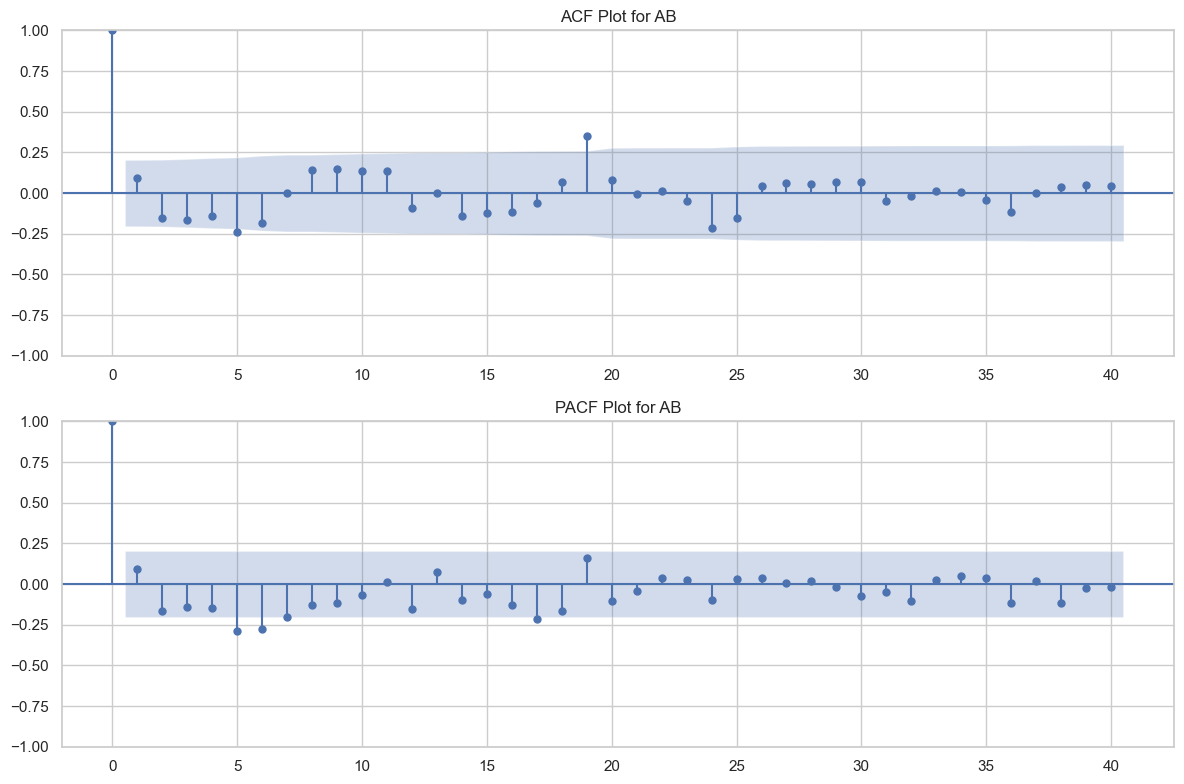

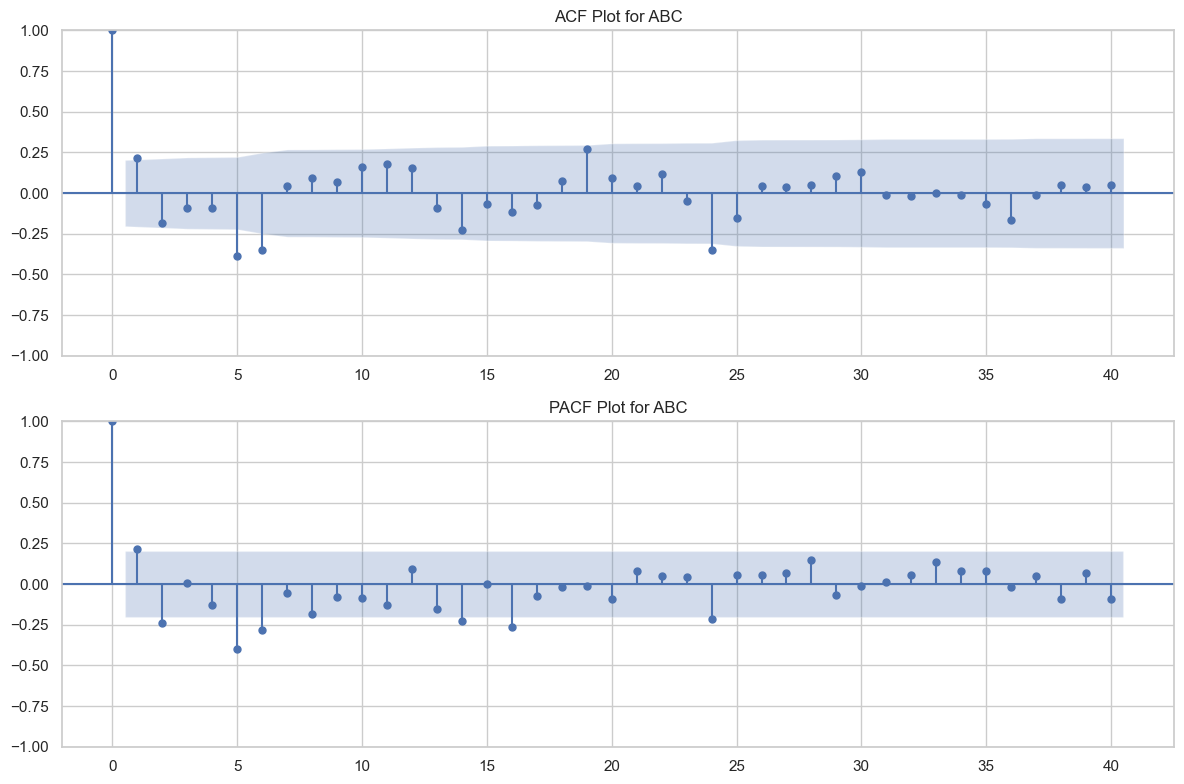

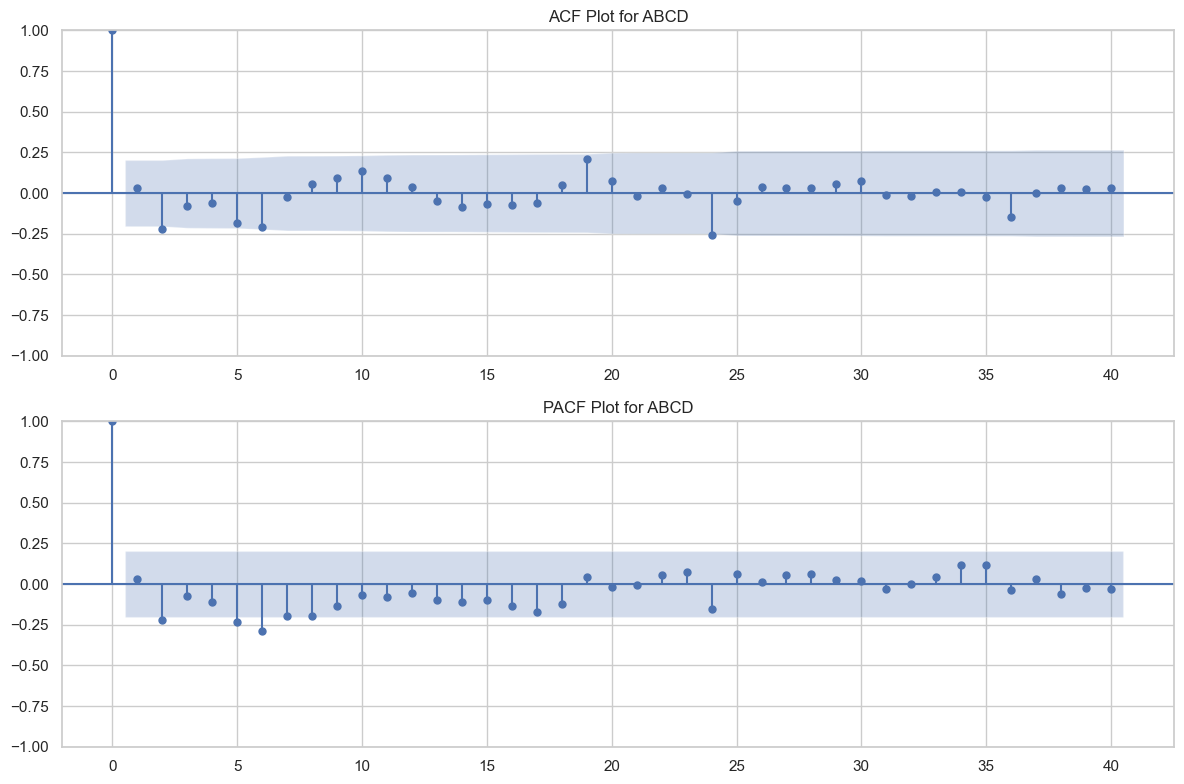

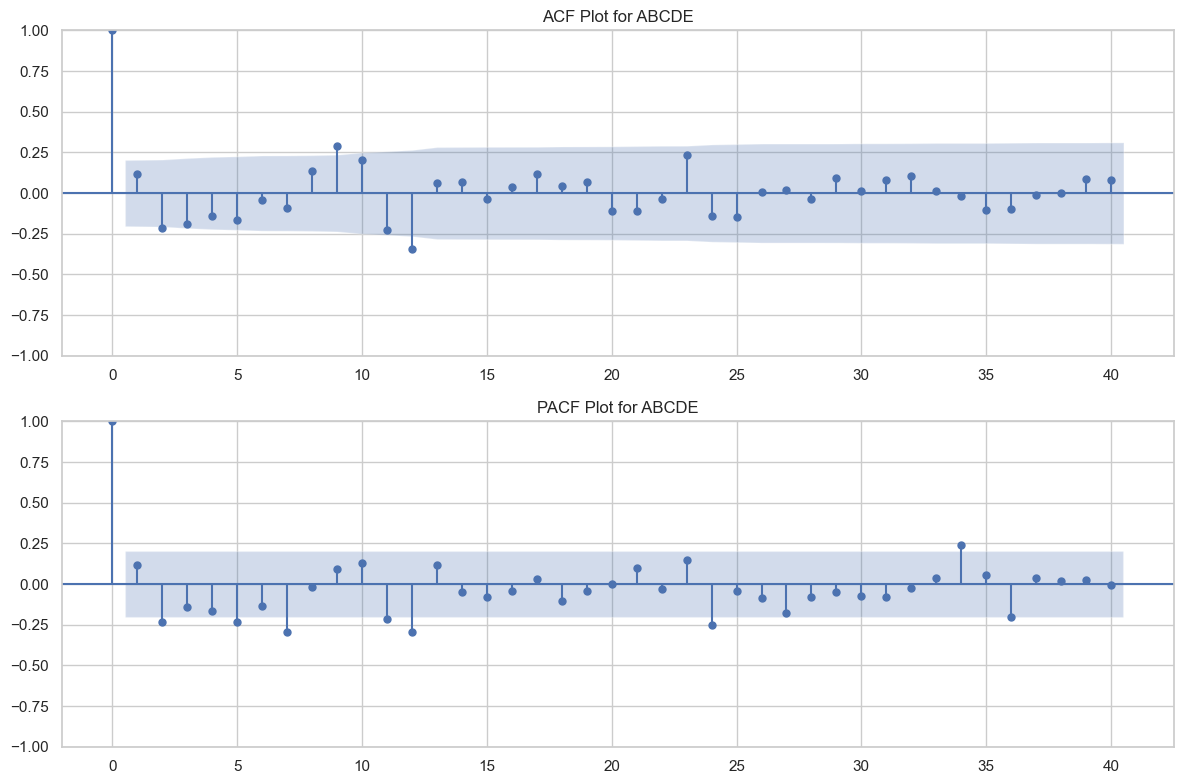

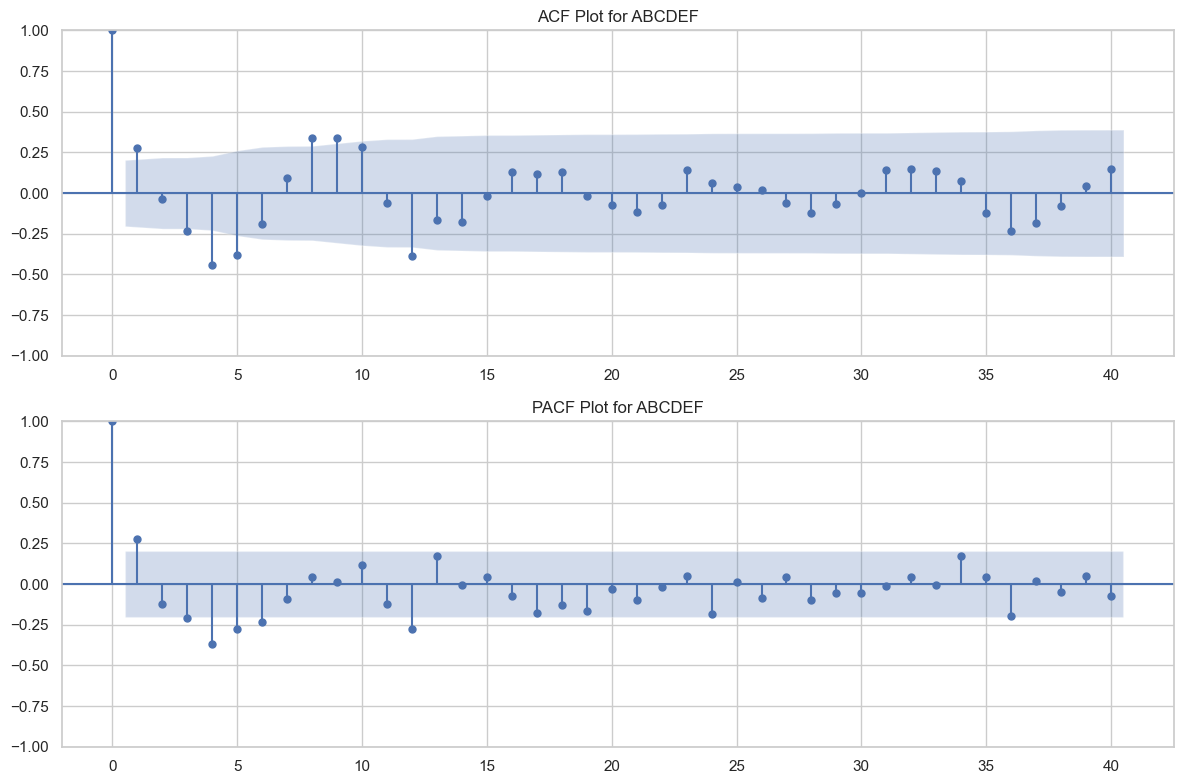

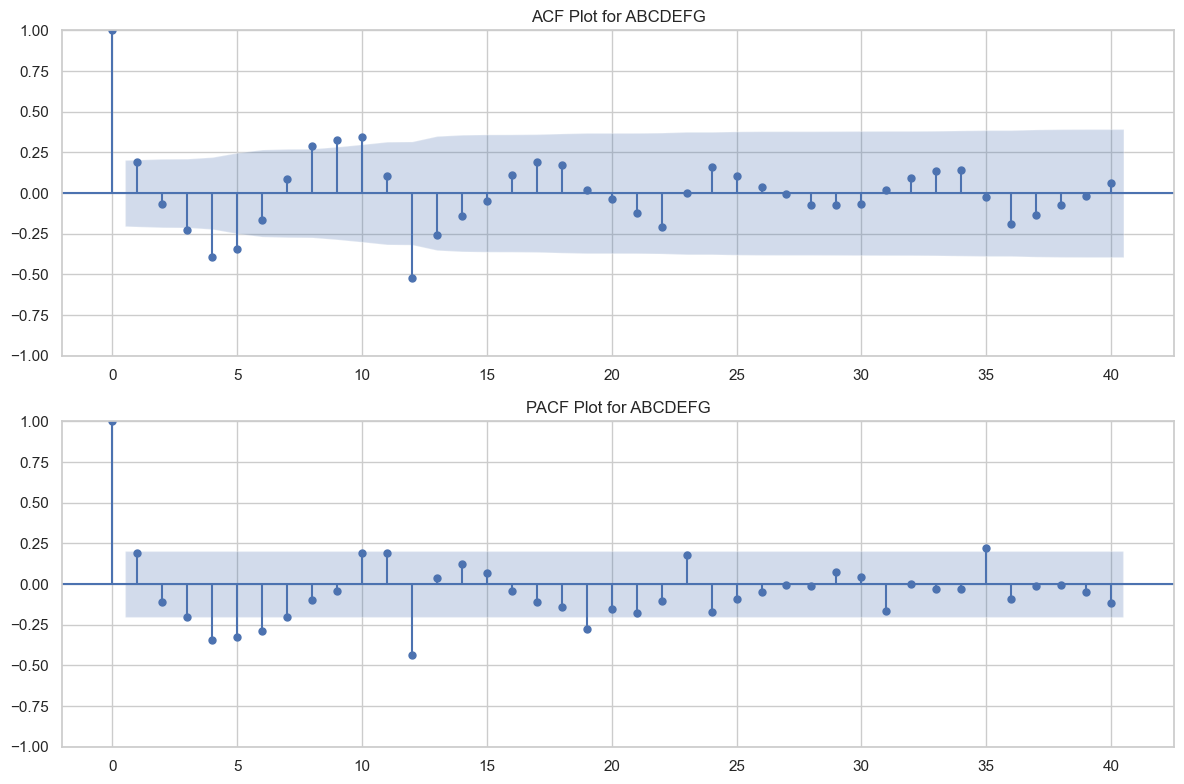

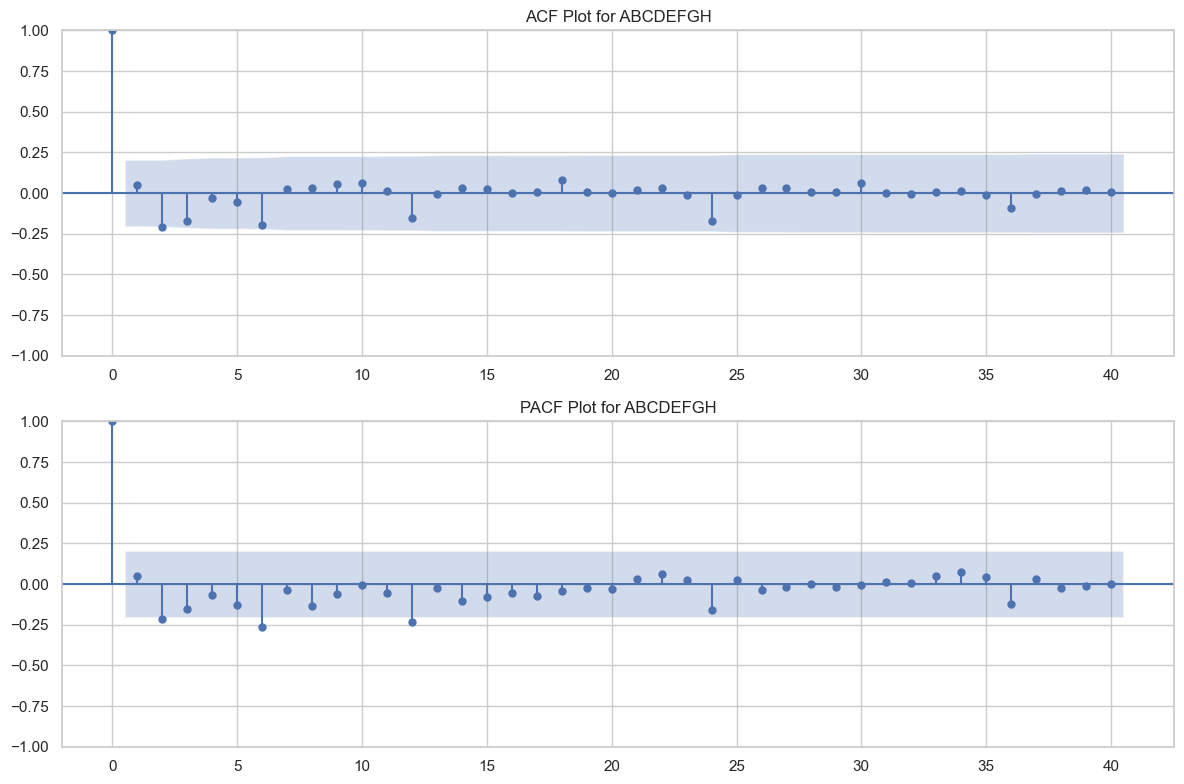

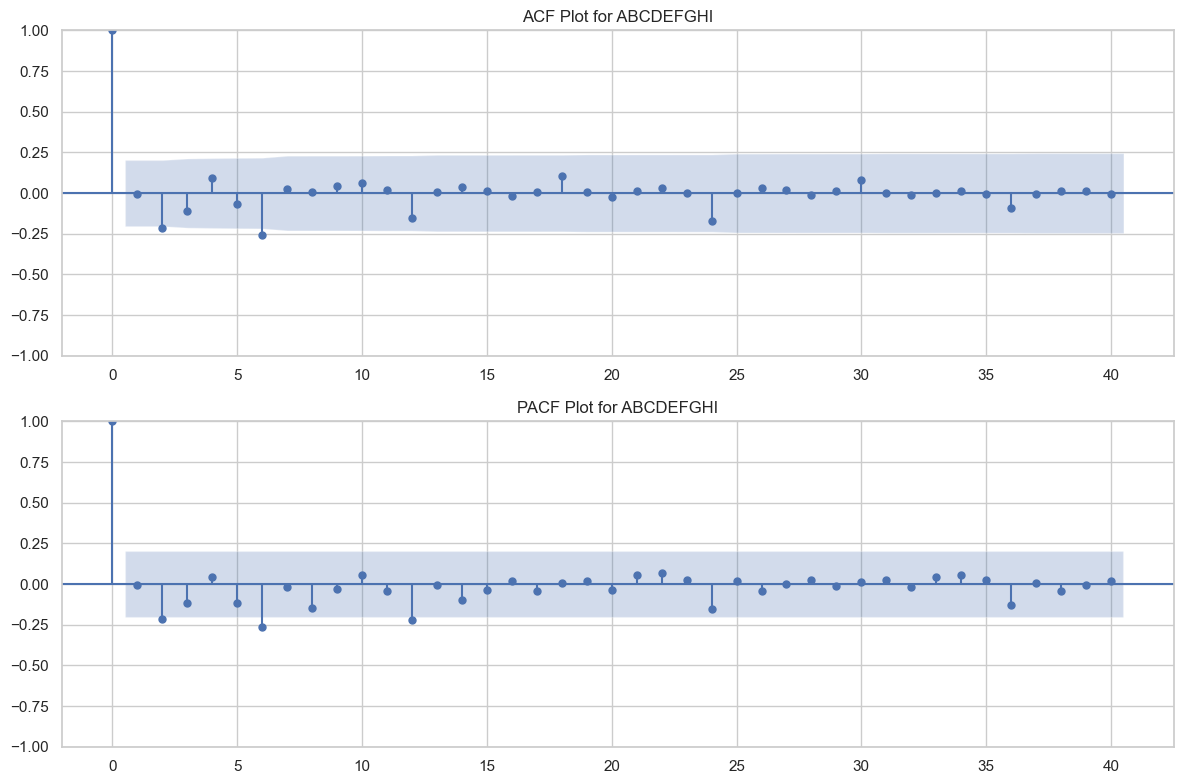

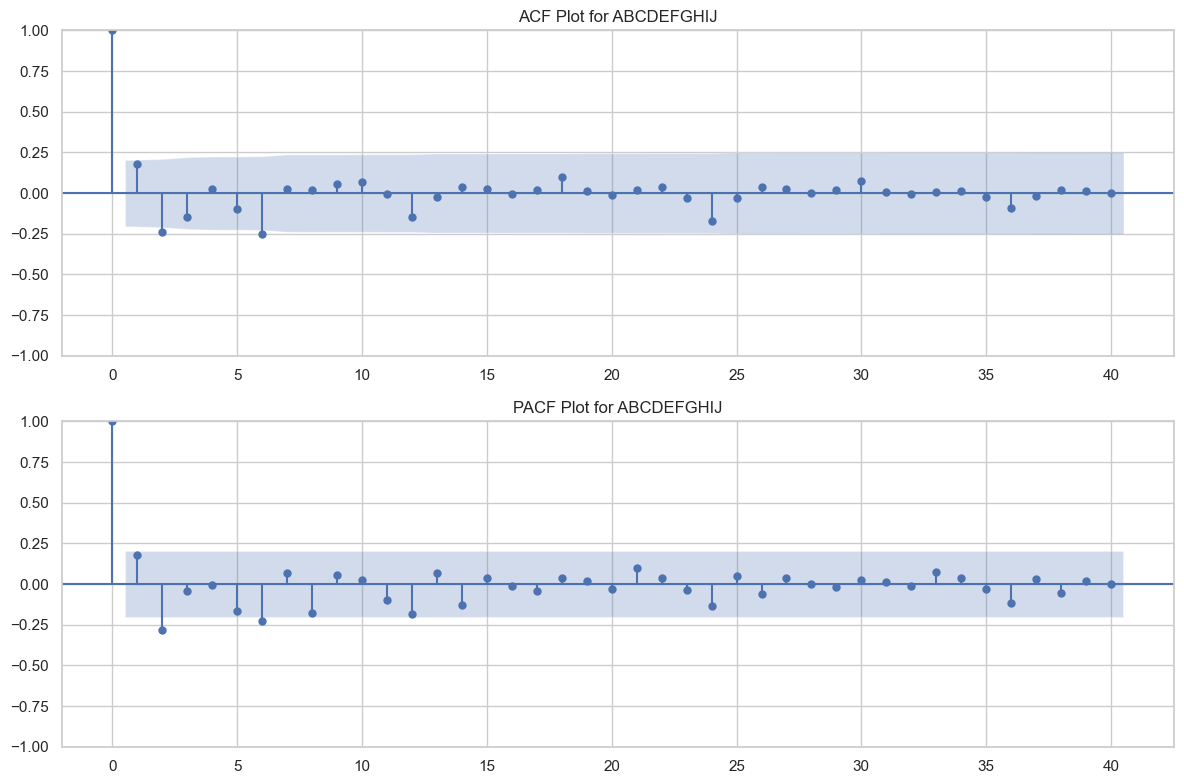

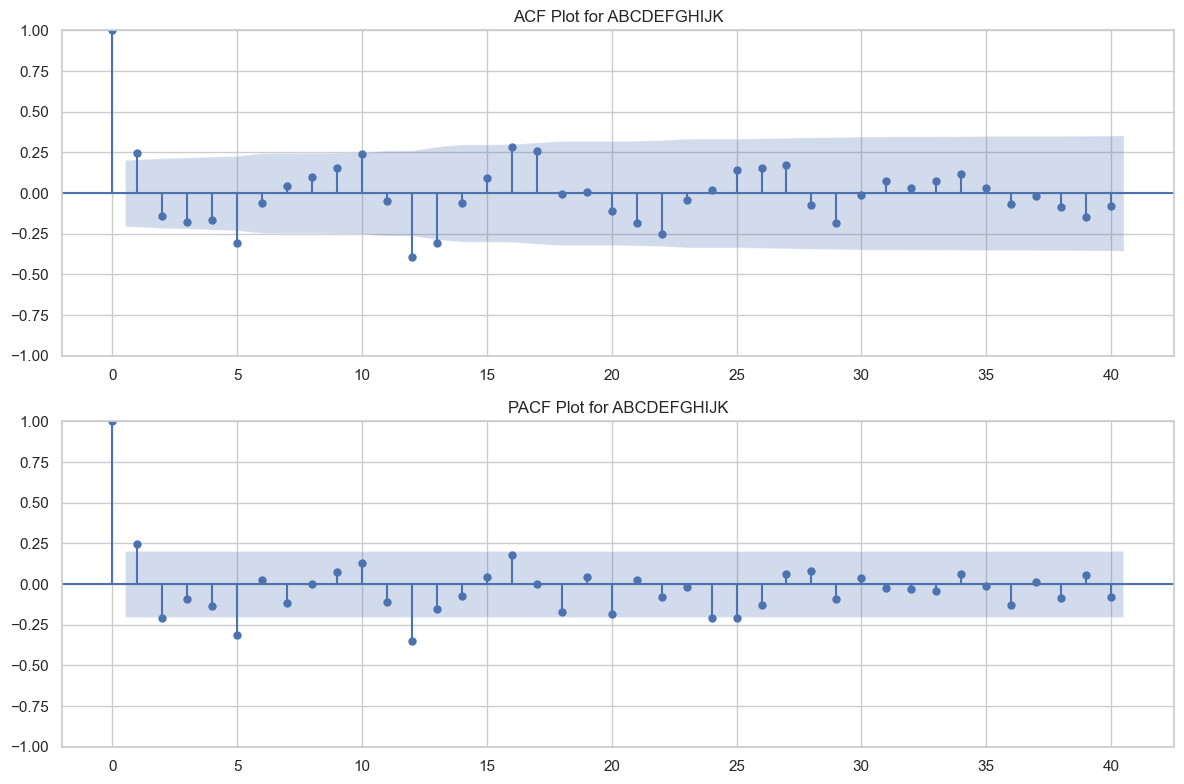

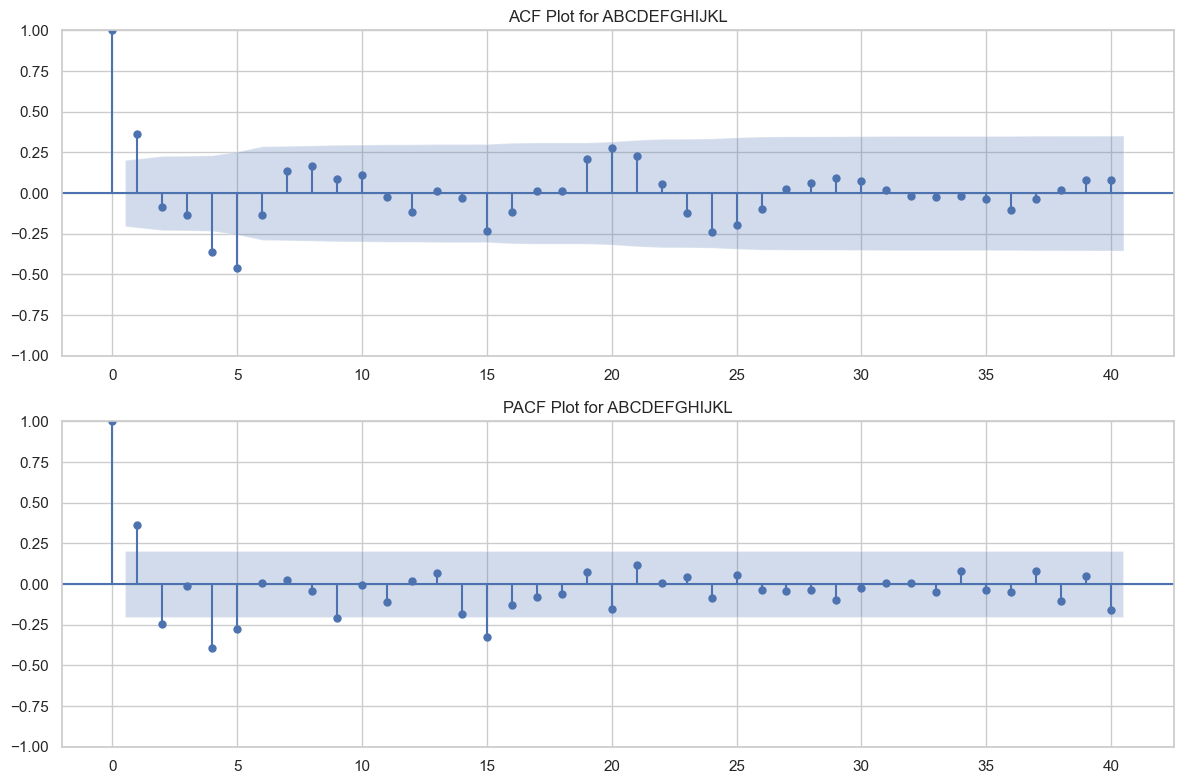

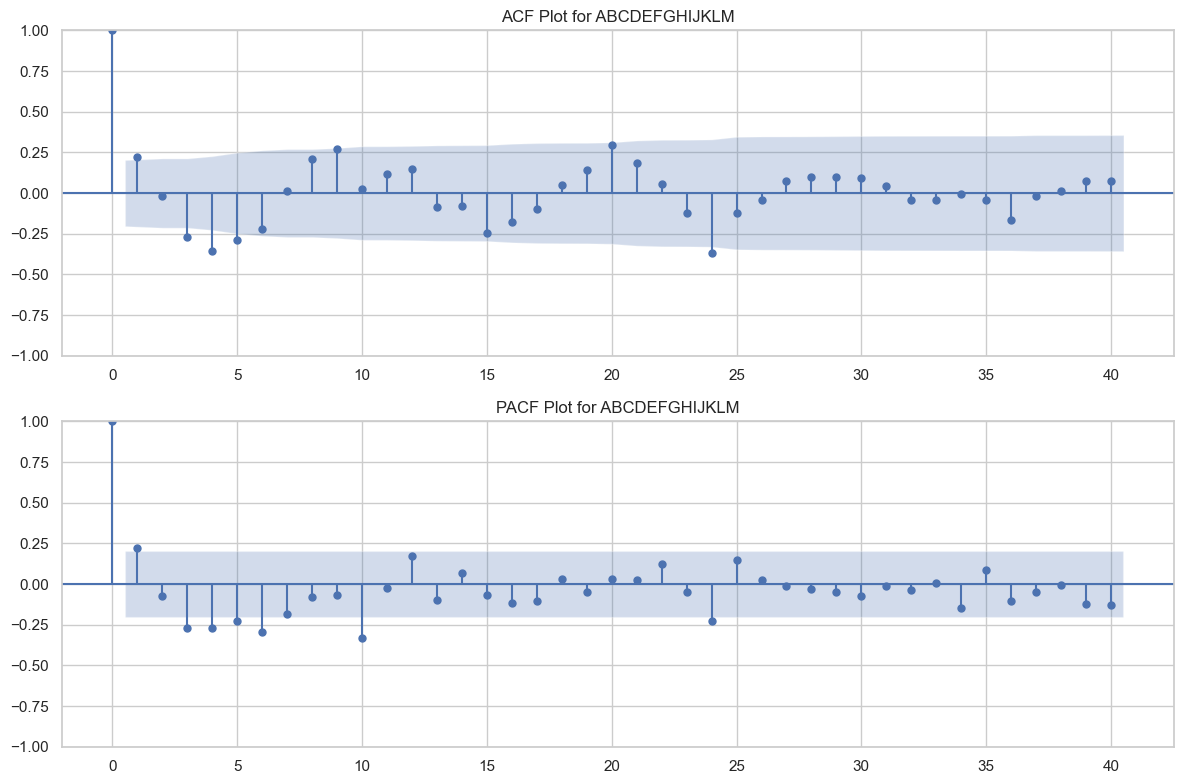

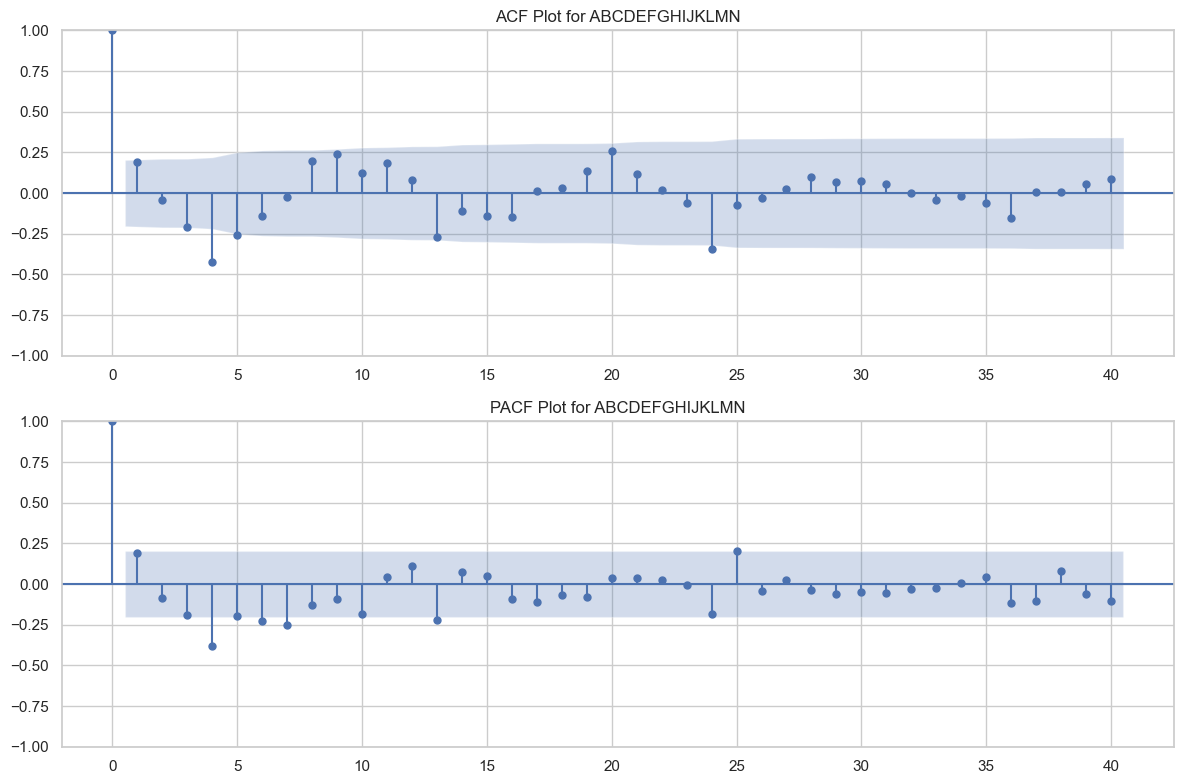

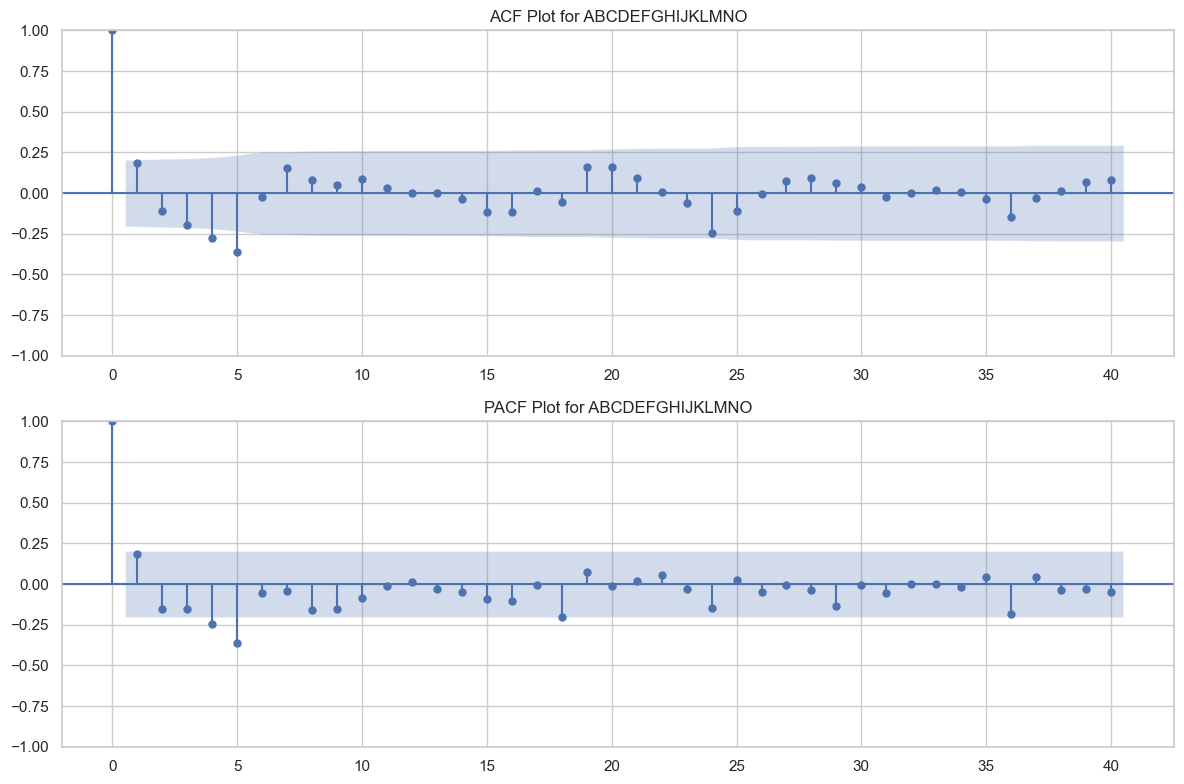

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

for material_name, df in material_dataframes.items():    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    plot_acf(df['Residual'], lags=40, ax=ax1)
    ax1.set_title(f'ACF Plot for {material_name}')
    plot_pacf(df['Residual'], lags=40, ax=ax2)
    ax2.set_title(f'PACF Plot for {material_name}')
    plt.tight_layout()
    plt.show()


AB: Predicted=681.07, Expected=442.00


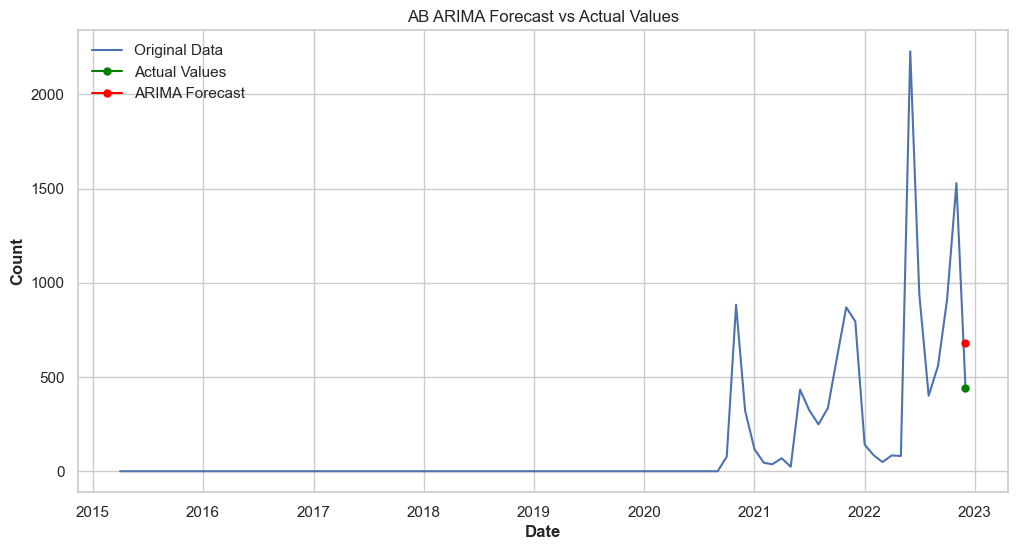

ABC: Predicted=1228.73, Expected=648.00


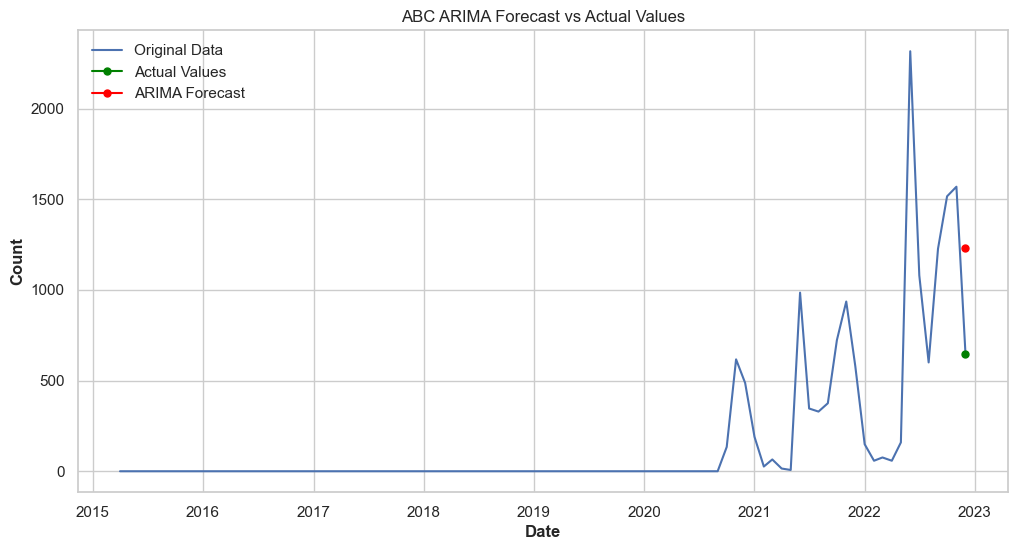

ABCD: Predicted=1445.90, Expected=836.00


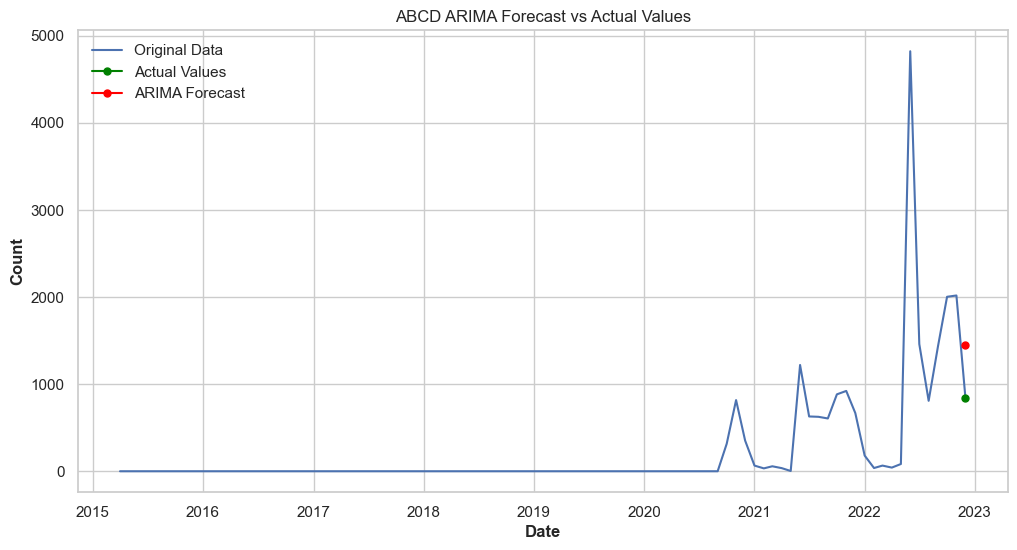

ABCDE: Predicted=392.68, Expected=200.00


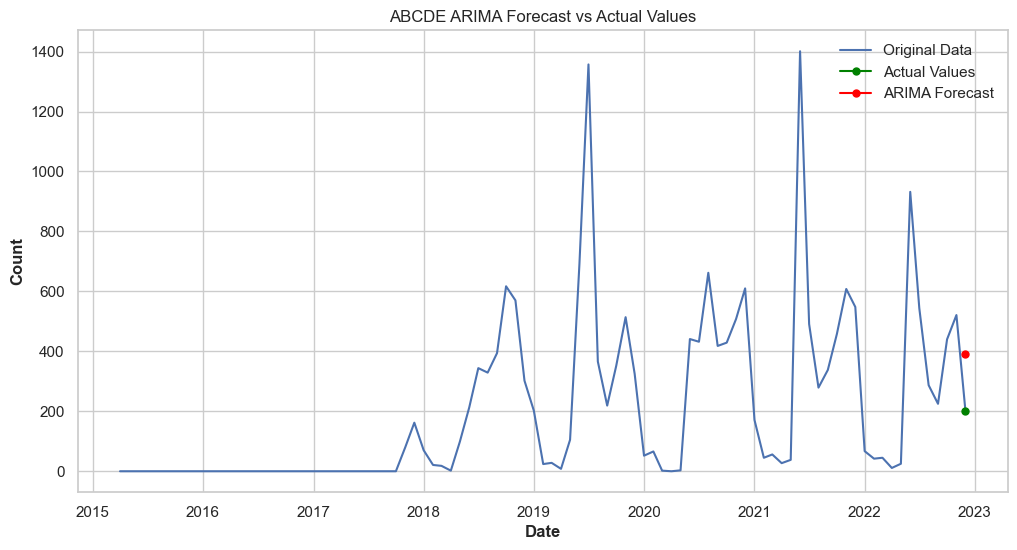

ABCDEF: Predicted=287.20, Expected=101.00


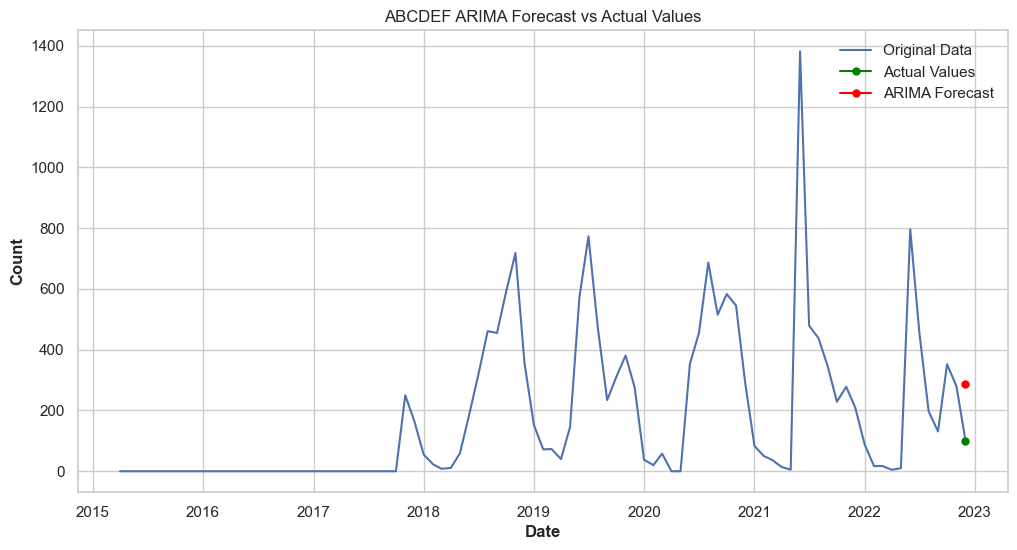

ABCDEFG: Predicted=211.65, Expected=104.00


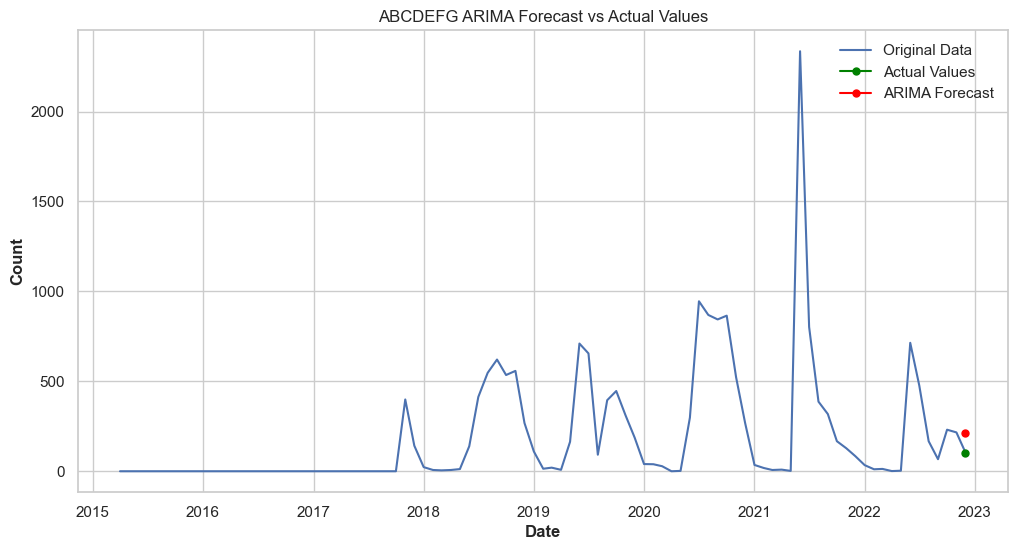

ABCDEFGH: Predicted=456.35, Expected=163.00


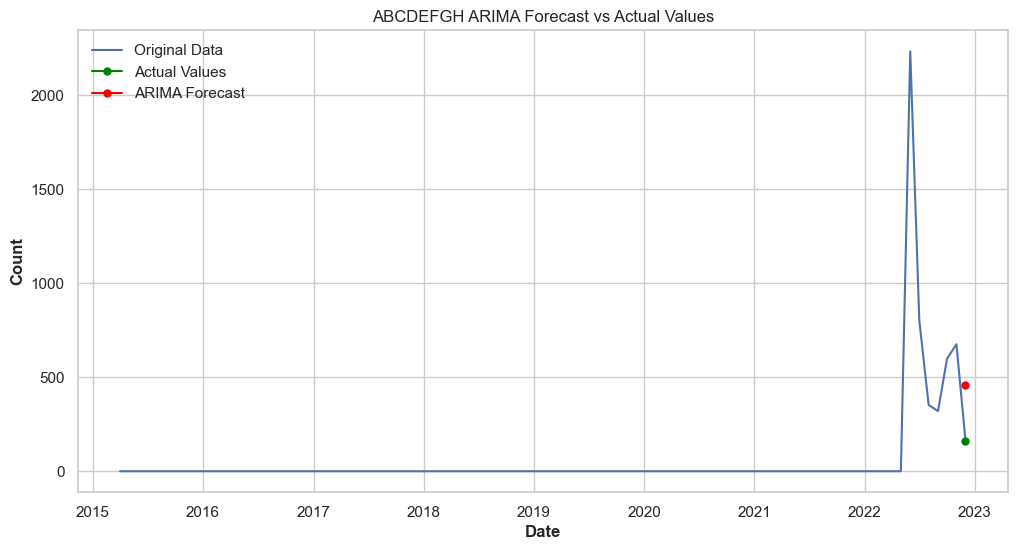

ABCDEFGHI: Predicted=357.12, Expected=148.00


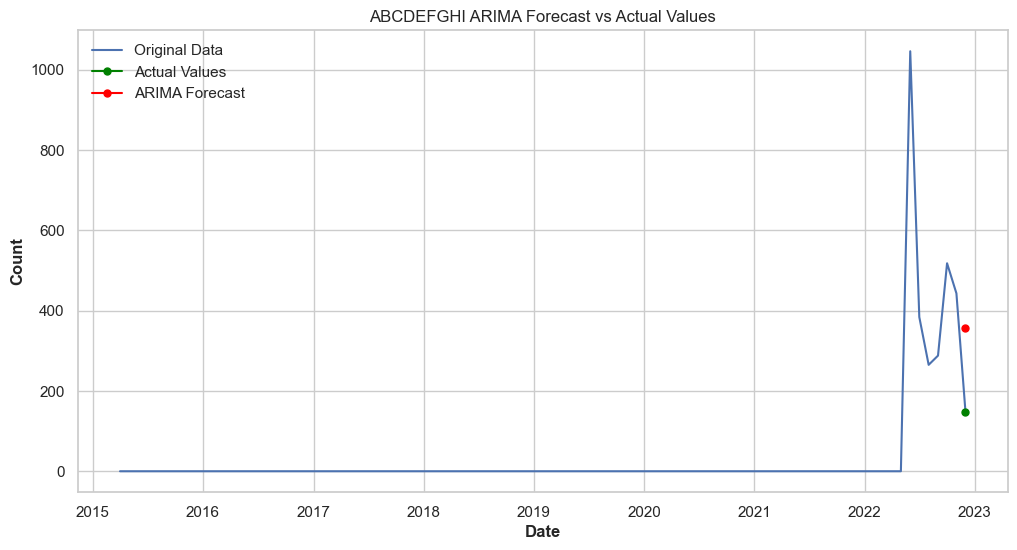

ABCDEFGHIJ: Predicted=476.42, Expected=257.00


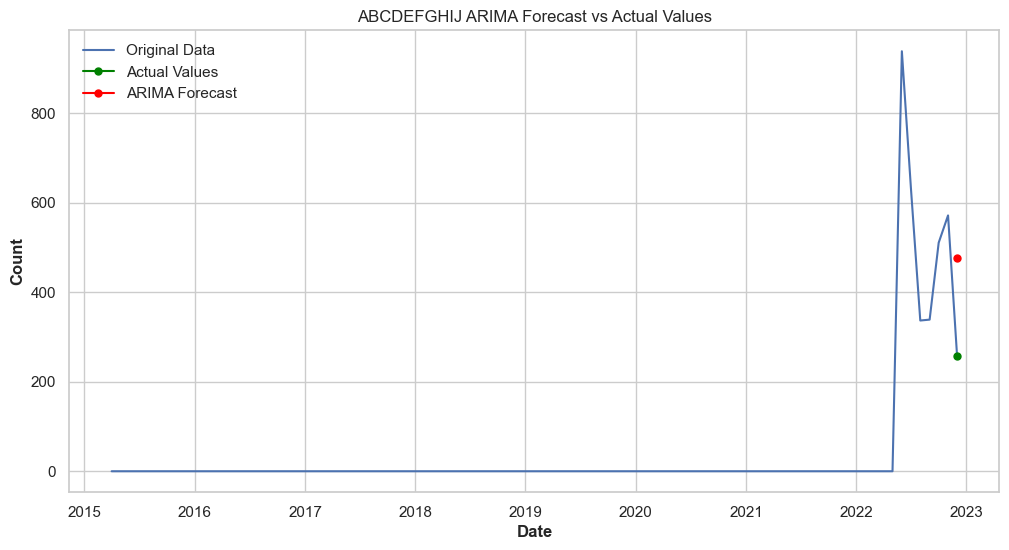

ABCDEFGHIJK: Predicted=571.99, Expected=289.00


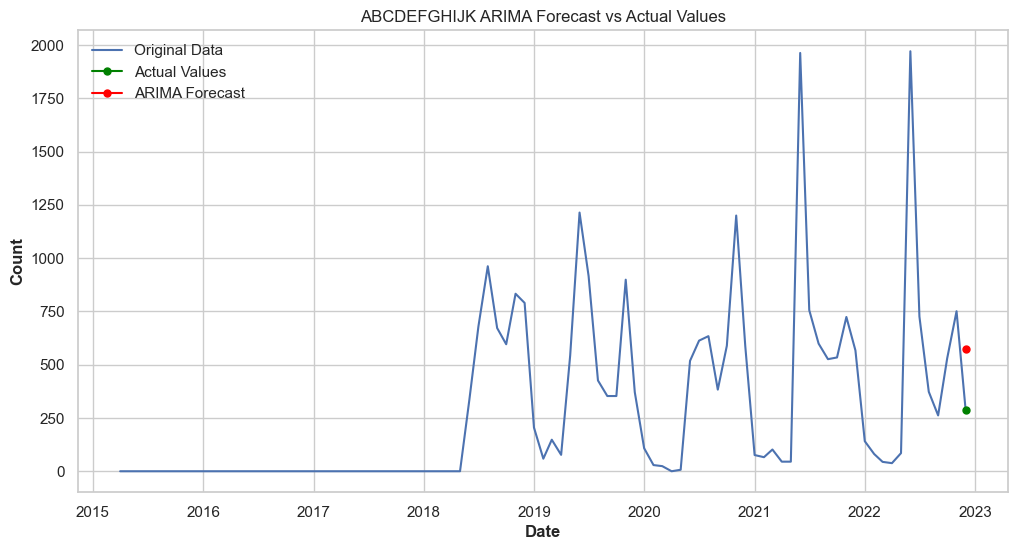

ABCDEFGHIJKL: Predicted=120.04, Expected=30.00


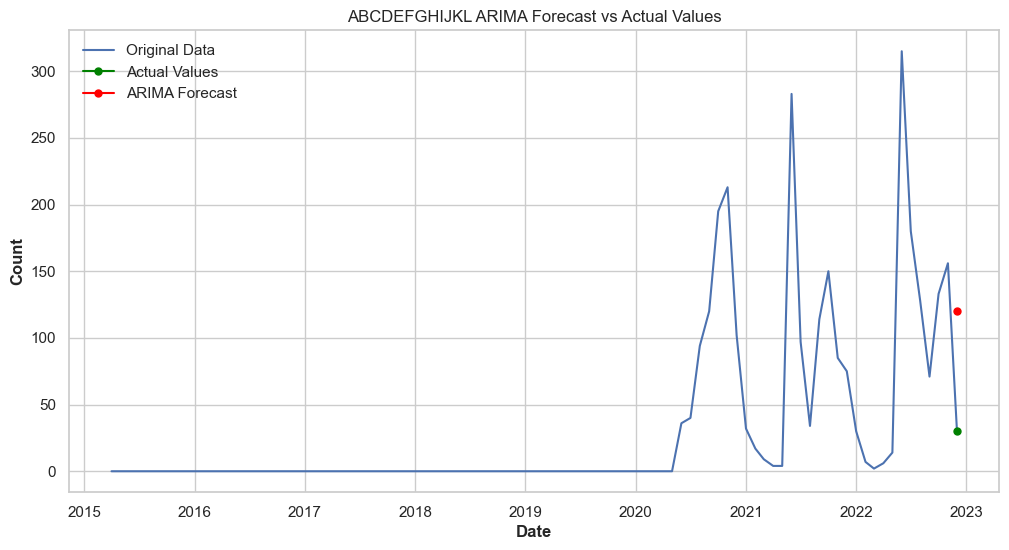

ABCDEFGHIJKLM: Predicted=184.12, Expected=78.00


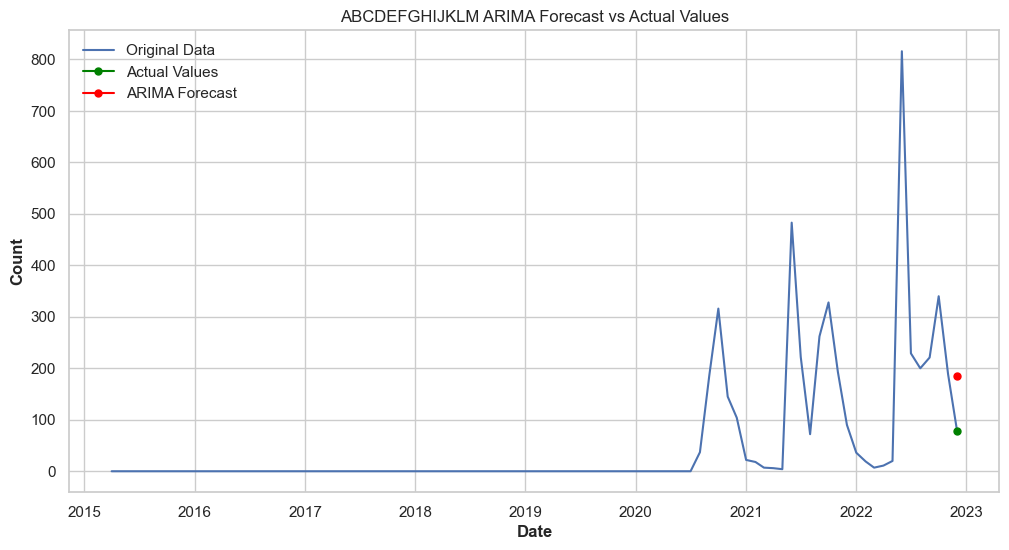

ABCDEFGHIJKLMN: Predicted=262.30, Expected=113.00


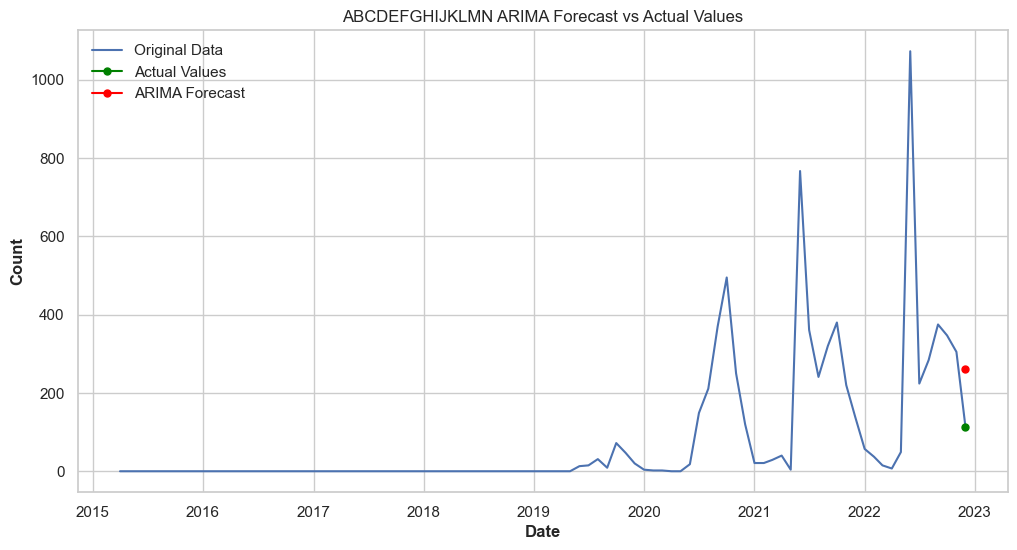

ABCDEFGHIJKLMNO: Predicted=3295.66, Expected=2781.00


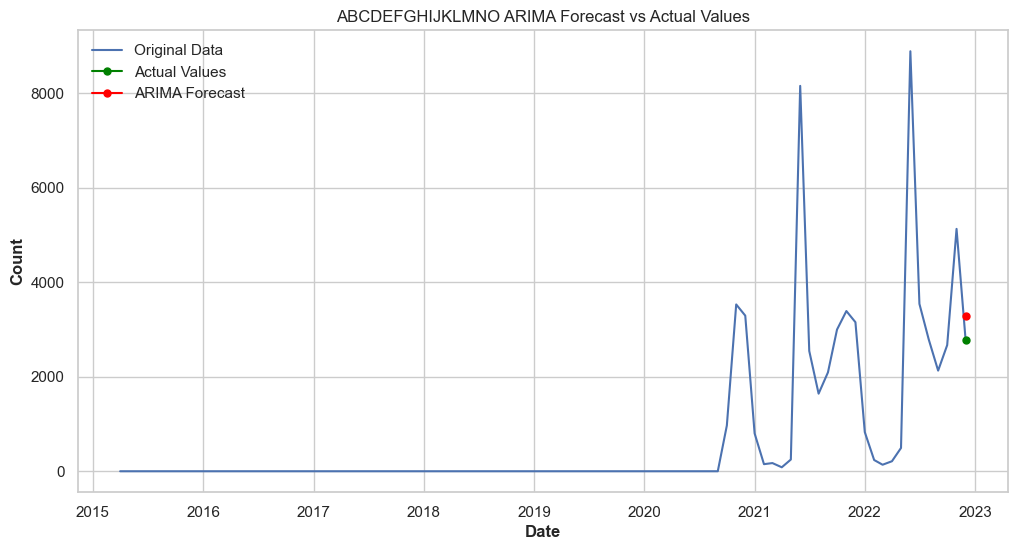

AB: RMSE = 239.07
ABC: RMSE = 580.73
ABCD: RMSE = 609.90
ABCDE: RMSE = 192.68
ABCDEF: RMSE = 186.20
ABCDEFG: RMSE = 107.65
ABCDEFGH: RMSE = 293.35
ABCDEFGHI: RMSE = 209.12
ABCDEFGHIJ: RMSE = 219.42
ABCDEFGHIJK: RMSE = 282.99
ABCDEFGHIJKL: RMSE = 90.04
ABCDEFGHIJKLM: RMSE = 106.12
ABCDEFGHIJKLMN: RMSE = 149.30
ABCDEFGHIJKLMNO: RMSE = 514.66


In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

rmse_results = {}

for material_name, df in material_dataframes.items():
    train_size = int(92)  
    train, test = df['Count'][:train_size], df['Count'][train_size:]

    # Initialize lists to store forecasts and actual values
    history = train.tolist()
    predictions = []
    actuals = test.tolist()

    for t in range(len(test)):
        model = ARIMA(history, order=(2, 0, 2))
        model_fit = model.fit()

        # Forecast next value
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)

        # Update history with actual value (simulate online learning)
        history.append(actuals[t])

        # Print forecasted and actual value for validation
        print(f"{material_name}: Predicted={yhat:.2f}, Expected={actuals[t]:.2f}")

    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    rmse_results[material_name] = rmse

    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['Count'], label='Original Data')
    plt.plot(df.index[train_size:], test, label='Actual Values', color='green', markersize=5, marker='o')
    plt.plot(df.index[train_size:], predictions, label='ARIMA Forecast', color='red', markersize=5, marker='o')
    plt.title(f'{material_name} ARIMA Forecast vs Actual Values')
    plt.xlabel('Date')
    plt.ylabel('Count')
    plt.legend()
    plt.show()

for material_name, rmse in rmse_results.items():
    print(f"{material_name}: RMSE = {rmse:.2f}")



In [72]:
# Create TimeSeries objects for each material
time_series_dict = {}
for material_name, df in material_dataframes.items():
    series = TimeSeries.from_dataframe(df, value_cols='Count', fill_missing_dates=True, freq='MS')
    time_series_dict[material_name] = series

In [73]:
train_series = {}
val_series = {}
for material_name, series in time_series_dict.items():
    train_series[material_name] = series[:-1]  # All data except the last point
    val_series[material_name] = series[-1:]    # The last point (December 2022)

In [74]:
# Fit Exponential Smoothing model for each material
exponential_smoothing_models = {}
for material_name, series in train_series.items():
    model = ExponentialSmoothing(series.values(), trend='add', seasonal='add', seasonal_periods=12)
    model_fit = model.fit()
    exponential_smoothing_models[material_name] = model_fit

In [75]:
# Make forecasts for December 2022 for each material
forecasts = {}
for material_name, model in exponential_smoothing_models.items():
    forecast = model.forecast(steps=1)  # Forecast for 1 step ahead (December 2022)
    forecasts[material_name] = forecast[0]  # Store the forecasted value

In [76]:
# Validate forecasts against actual data for December 2022 for each material
validation_results = {}
for material_name, actual_series in val_series.items():
    forecast = forecasts[material_name]  
    
    actual_value = actual_series.values()[0] 
    
    error = actual_value - forecast
    
    # Store validation results
    validation_results[material_name] = {
        'Forecast': forecast,
        'Actual': actual_value,
        'Error': error
    }

for material_name, result in validation_results.items():
    print(f"{material_name}: Forecast={result['Forecast']}, Actual={result['Actual']}, Error={result['Error']}")
    print()

AB: Forecast=1169.6167918597673, Actual=[442.], Error=[-727.61679186]

ABC: Forecast=1218.4499654169508, Actual=[648.], Error=[-570.44996542]

ABCD: Forecast=1451.7833764529873, Actual=[836.], Error=[-615.78337645]

ABCDE: Forecast=472.5183546594516, Actual=[200.], Error=[-272.51835466]

ABCDEF: Forecast=165.2984025848081, Actual=[101.], Error=[-64.29840258]

ABCDEFG: Forecast=33.73951176650746, Actual=[104.], Error=[70.26048823]

ABCDEFGH: Forecast=579.3273873872434, Actual=[163.], Error=[-416.32738739]

ABCDEFGHI: Forecast=469.2425123070479, Actual=[148.], Error=[-321.24251231]

ABCDEFGHIJ: Forecast=526.9526223263754, Actual=[257.], Error=[-269.95262233]

ABCDEFGHIJK: Forecast=503.73139624567193, Actual=[289.], Error=[-214.73139625]

ABCDEFGHIJKL: Forecast=104.71064710016938, Actual=[30.], Error=[-74.7106471]

ABCDEFGHIJKLM: Forecast=133.4497020393122, Actual=[78.], Error=[-55.44970204]

ABCDEFGHIJKLMN: Forecast=183.831013353591, Actual=[113.], Error=[-70.83101335]

ABCDEFGHIJKLMNO: 

### Data Preparation

In [77]:
# Load the dataset
file_path = 'practise_data_with_ABN_till_dec.csv'
data = pd.read_csv(file_path)

# Function to prepare the data for a specific material
def prepare_data(df, material):
    df_material = df[df['MaterialNumber'] == material].drop('MaterialNumber', axis=1).T
    df_material.columns = ['Sales']
    df_material.index = pd.to_datetime(df_material.index, format='%d-%m-%Y')
    return df_material

materials = data['MaterialNumber'].unique()

In [78]:
# ARIMA model
def forecast_sales_arima(df, material, order=(2,0,2)):
    df_material = prepare_data(df, material)
    train = df_material[:-1]  # Up to November 2022
    test = df_material[-1:]  # December 2022
    
    model = ARIMA(train, order=order)
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=1)
    
    actual = test.values
    predicted = forecast.values
    
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    
    return actual[0], predicted[0], rmse

results = []

for material in materials:
    actual, predicted, rmse = forecast_sales_arima(data, material)
    results.append((material, actual, predicted, rmse))

results_df = pd.DataFrame(results, columns=['MaterialNumber', 'Actual', 'Predicted', 'RMSE'])

results_df


MaterialNumber  Actual    Predicted        RMSE
0                AB   [442]   681.067632  239.067632
1               ABC   [648]  1228.730808  580.730808
2              ABCD   [836]  1445.898109  609.898109
3             ABCDE   [200]   392.682568  192.682568
4            ABCDEF   [101]   287.204401  186.204401
5           ABCDEFG   [104]   211.653638  107.653638
6          ABCDEFGH   [163]   456.350488  293.350488
7         ABCDEFGHI   [148]   357.122840  209.122840
8        ABCDEFGHIJ   [257]   476.423486  219.423486
9       ABCDEFGHIJK   [289]   571.992732  282.992732
10     ABCDEFGHIJKL    [30]   120.039512   90.039512
11    ABCDEFGHIJKLM    [78]   184.116071  106.116071
12   ABCDEFGHIJKLMN   [113]   262.304320  149.304320
13  ABCDEFGHIJKLMNO  [2781]  3295.657674  514.657674

In [79]:
# Exponential Smoothing model
def forecast_sales_ets(df, material, seasonal_periods=11, trend='add', seasonal='add'):
    df_material = prepare_data(df, material)
    train = df_material[:-1]  # Up to November 2022
    test = df_material[-1:]  # December 2022
    
    model = ExponentialSmoothing(train, trend=trend, seasonal=seasonal, seasonal_periods=seasonal_periods)
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=1)
    
    actual = test.values
    predicted = forecast.values
    
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    
    return actual[0], predicted[0], rmse

results_ets = []

for material in materials:
    actual, predicted, rmse = forecast_sales_ets(data, material)
    results_ets.append((material, actual, predicted, rmse))

results_ets_df = pd.DataFrame(results_ets, columns=['MaterialNumber', 'Actual', 'Predicted', 'RMSE'])
results_ets_df


MaterialNumber  Actual    Predicted        RMSE
0                AB   [442]   391.446076   50.553924
1               ABC   [648]   750.819030  102.819030
2              ABCD   [836]   745.929770   90.070230
3             ABCDE   [200]   225.375447   25.375447
4            ABCDEF   [101]   157.693072   56.693072
5           ABCDEFG   [104]   115.050596   11.050596
6          ABCDEFGH   [163]   583.693957  420.693957
7         ABCDEFGHI   [148]   486.573769  338.573769
8        ABCDEFGHIJ   [257]   523.379667  266.379667
9       ABCDEFGHIJK   [289]   398.809991  109.809991
10     ABCDEFGHIJKL    [30]    99.946954   69.946954
11    ABCDEFGHIJKLM    [78]   177.711062   99.711062
12   ABCDEFGHIJKLMN   [113]   180.117535   67.117535
13  ABCDEFGHIJKLMNO  [2781]  3484.360781  703.360781

In [80]:
# tune ARIMA parameters
def forecast_sales_arima_tuned(df, material):
    df_material = prepare_data(df, material)
    train = df_material[:-1]  # Up to November 2022
    test = df_material[-1:]  # December 2022
    
    best_rmse = float('inf')
    best_order = None
    best_forecast = None
    
    # Grid search for ARIMA parameters
    for p in range(0, 3):
        for d in range(0, 3):
            for q in range(0, 3):
                try:
                    model = ARIMA(train, order=(p, d, q))
                    model_fit = model.fit()
                    forecast = model_fit.forecast(steps=1)
                    mse = mean_squared_error(test.values, forecast.values)
                    rmse = np.sqrt(mse)
                    
                    if rmse < best_rmse:
                        best_rmse = rmse
                        best_order = (p, d, q)
                        best_forecast = forecast.values
                except:
                    continue
    
    actual = test.values
    return actual[0], best_forecast[0], best_rmse, best_order

results_arima_tuned = []

for material in materials:
    actual, predicted, rmse, order = forecast_sales_arima_tuned(data, material)
    results_arima_tuned.append((material, actual, predicted, rmse, order))

results_arima_tuned_df = pd.DataFrame(results_arima_tuned, columns=['MaterialNumber', 'Actual', 'Predicted', 'RMSE', 'Order'])

results_arima_tuned_df


MaterialNumber  Actual    Predicted        RMSE      Order
0                AB   [442]   663.932534  221.932534  (0, 0, 1)
1               ABC   [648]   661.429614   13.429614  (0, 0, 1)
2              ABCD   [836]   876.281857   40.281857  (0, 0, 2)
3             ABCDE   [200]   202.543506    2.543506  (0, 0, 0)
4            ABCDEF   [101]   180.467380   79.467380  (0, 0, 0)
5           ABCDEFG   [104]   187.049198   83.049198  (0, 0, 1)
6          ABCDEFGH   [163]   213.139738   50.139738  (0, 0, 1)
7         ABCDEFGHI   [148]   128.926142   19.073858  (0, 0, 1)
8        ABCDEFGHIJ   [257]   217.080489   39.919511  (0, 0, 1)
9       ABCDEFGHIJK   [289]   284.041165    4.958835  (0, 0, 0)
10     ABCDEFGHIJKL    [30]    29.847822    0.152178  (0, 0, 0)
11    ABCDEFGHIJKLM    [78]    66.526203   11.473797  (0, 0, 1)
12   ABCDEFGHIJKLMN   [113]   134.287828   21.287828  (0, 0, 1)
13  ABCDEFGHIJKLMNO  [2781]  2903.417176  122.417176  (1, 0, 1)

In [81]:
comparison_df = results_df.merge(results_ets_df, on='MaterialNumber', suffixes=('_ARIMA', '_ETS'))
comparison_df = comparison_df.merge(results_arima_tuned_df, on='MaterialNumber', suffixes=('', '_Tuned_ARIMA'))

comparison_df

MaterialNumber Actual_ARIMA  Predicted_ARIMA  RMSE_ARIMA Actual_ETS  \
0                AB        [442]       681.067632  239.067632      [442]   
1               ABC        [648]      1228.730808  580.730808      [648]   
2              ABCD        [836]      1445.898109  609.898109      [836]   
3             ABCDE        [200]       392.682568  192.682568      [200]   
4            ABCDEF        [101]       287.204401  186.204401      [101]   
5           ABCDEFG        [104]       211.653638  107.653638      [104]   
6          ABCDEFGH        [163]       456.350488  293.350488      [163]   
7         ABCDEFGHI        [148]       357.122840  209.122840      [148]   
8        ABCDEFGHIJ        [257]       476.423486  219.423486      [257]   
9       ABCDEFGHIJK        [289]       571.992732  282.992732      [289]   
10     ABCDEFGHIJKL         [30]       120.039512   90.039512       [30]   
11    ABCDEFGHIJKLM         [78]       184.116071  106.116071       [78]   
12   ABCDEFGHIJKLMN        [113]       262.304320  149.304320      [113]   
13  ABCDEFGHIJKLMNO       [2781]      3295.657674  514.657674     [2781]   

    Predicted_ETS    RMSE_ETS  Actual    Predicted        RMSE      Order  
0      391.446076   50.553924   [442]   663.932534  221.932534  (0, 0, 1)  
1      750.819030  102.819030   [648]   661.429614   13.429614  (0, 0, 1)  
2      745.929770   90.070230   [836]   876.281857   40.281857  (0, 0, 2)  
3      225.375447   25.375447   [200]   202.543506    2.543506  (0, 0, 0)  
4      157.693072   56.693072   [101]   180.467380   79.467380  (0, 0, 0)  
5      115.050596   11.050596   [104]   187.049198   83.049198  (0, 0, 1)  
6      583.693957  420.693957   [163]   213.139738   50.139738  (0, 0, 1)  
7      486.573769  338.573769   [148]   128.926142   19.073858  (0, 0, 1)  
8      523.379667  266.379667   [257]   217.080489   39.919511  (0, 0, 1)  
9      398.809991  109.809991   [289]   284.041165    4.958835  (0, 0, 0)  
10      99.946954   69.946954    [30]    29.847822    0.152178  (0, 0, 0)  
11     177.711062   99.711062    [78]    66.526203   11.473797  (0, 0, 1)  
12     180.117535   67.117535   [113]   134.287828   21.287828  (0, 0, 1)  
13    3484.360781  703.360781  [2781]  2903.417176  122.417176  (1, 0, 1)

In [33]:
def forecast_sales_lstm(df, material):
    df_material = prepare_data(df, material).values
    scaler = MinMaxScaler(feature_range=(0, 1))
    df_material_scaled = scaler.fit_transform(df_material)
    
    train_size = len(df_material_scaled) - 1
    train, test = df_material_scaled[0:train_size], df_material_scaled[train_size:]
    
    # Convert to a format suitable for LSTM
    def create_dataset(dataset):
        X, Y = [], []
        for i in range(len(dataset) - 1):
            X.append(dataset[i, 0])
            Y.append(dataset[i + 1, 0])
        return np.array(X), np.array(Y)
    
    trainX, trainY = create_dataset(train)
    trainX = np.reshape(trainX, (trainX.shape[0], 1, 1))
    
    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(4, input_shape=(1, 1)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    # Train the model
    model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
    
    # Make predictions
    testX = np.reshape(test, (1, 1, 1))
    predicted = model.predict(testX)
    predicted = scaler.inverse_transform(predicted)
    
    actual = scaler.inverse_transform(test)
    
    return actual[0][0], predicted[0][0]

results_lstm = []

for material in materials:
    actual, predicted = forecast_sales_lstm(data, material)
    results_lstm.append((material, actual, predicted))

results_lstm_df = pd.DataFrame(results_lstm, columns=['MaterialNumber', 'Actual', 'Predicted'])


Epoch 1/100
91/91 - 1s - 11ms/step - loss: 0.0255
Epoch 2/100
91/91 - 0s - 1ms/step - loss: 0.0239
Epoch 3/100
91/91 - 0s - 1ms/step - loss: 0.0234
Epoch 4/100
91/91 - 0s - 1ms/step - loss: 0.0230
Epoch 5/100
91/91 - 0s - 1ms/step - loss: 0.0226
Epoch 6/100
91/91 - 0s - 1ms/step - loss: 0.0222
Epoch 7/100
91/91 - 0s - 1ms/step - loss: 0.0219
Epoch 8/100
91/91 - 0s - 1ms/step - loss: 0.0216
Epoch 9/100
91/91 - 0s - 1ms/step - loss: 0.0209
Epoch 10/100
91/91 - 0s - 1000us/step - loss: 0.0205
Epoch 11/100
91/91 - 0s - 1ms/step - loss: 0.0200
Epoch 12/100
91/91 - 0s - 1ms/step - loss: 0.0195
Epoch 13/100
91/91 - 0s - 1ms/step - loss: 0.0191
Epoch 14/100
91/91 - 0s - 1ms/step - loss: 0.0187
Epoch 15/100
91/91 - 0s - 1ms/step - loss: 0.0186
Epoch 16/100
91/91 - 0s - 1ms/step - loss: 0.0182
Epoch 17/100
91/91 - 0s - 1ms/step - loss: 0.0180
Epoch 18/100
91/91 - 0s - 1ms/step - loss: 0.0178
Epoch 19/100
91/91 - 0s - 1ms/step - loss: 0.0174
Epoch 20/100
91/91 - 0s - 993us/step - loss: 0.0176
Epo

In [34]:
results_lstm_df

MaterialNumber  Actual    Predicted
0                AB   442.0   395.731995
1               ABC   648.0   607.410217
2              ABCD   836.0   742.403931
3             ABCDE   200.0   224.038620
4            ABCDEF   101.0   135.661423
5           ABCDEFG   104.0   153.304901
6          ABCDEFGH   163.0   150.866440
7         ABCDEFGHI   148.0   128.678146
8        ABCDEFGHIJ   257.0   261.129547
9       ABCDEFGHIJK   289.0   357.925842
10     ABCDEFGHIJKL    30.0    33.598316
11    ABCDEFGHIJKLM    78.0    85.092300
12   ABCDEFGHIJKLMN   113.0   137.969437
13  ABCDEFGHIJKLMNO  2781.0  2643.148193

Material: AB
 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=1307.588, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=1286.708, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=1282.652, Time=0.10 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=1284.210, Time=0.14 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=1282.471, Time=0.13 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=1304.316, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=1284.409, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=1298.809, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=1282.323, Time=0.08 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(3,1,0)(0,0,0)[1] int

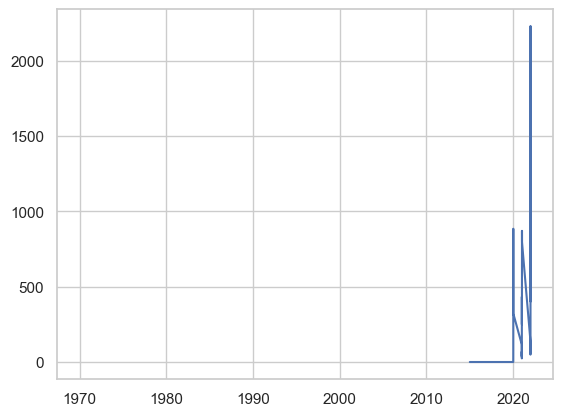

575.5070888454519

Material: ABC
 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=1310.079, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=1293.610, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=1289.076, Time=0.07 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=1290.477, Time=0.12 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=1292.405, Time=0.11 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=1294.383, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=1306.022, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=1291.242, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=1290.595, Time=0.10 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=1291.757, Time=0.17 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=1295.129, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=1290.619, Time=0.10 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=1292.415, Time=0.13 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=inf, T

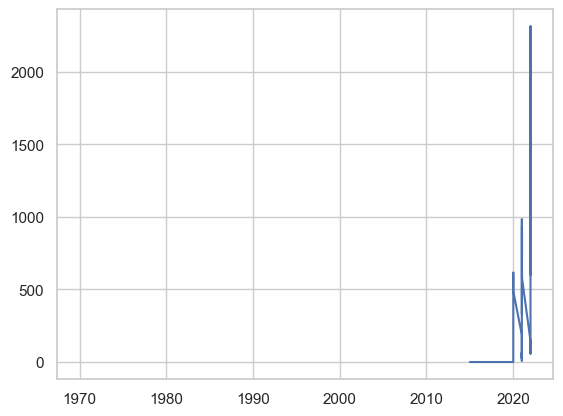

617.627243800707

Material: ABCD
 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=1439.372, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=1404.271, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=1405.099, Time=0.07 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=1406.042, Time=0.12 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=1408.017, Time=0.15 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=1412.512, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=1427.714, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=1405.420, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=1417.673, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=1405.832, Time=0.09 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=1409.616, Time=0.15 s

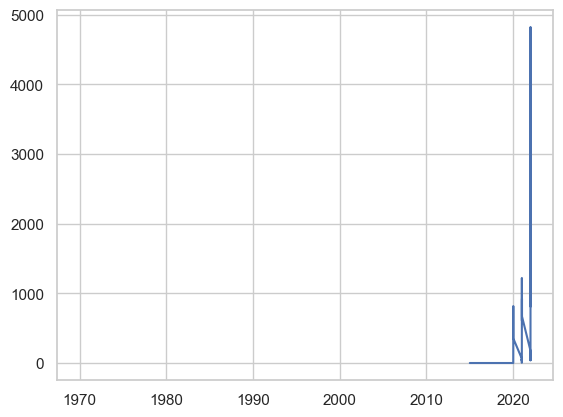

734.057883232585

Material: ABCDE
 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=1283.737, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=1282.800, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=1277.748, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(3,1,0)(0,0,0)[1] intercept   

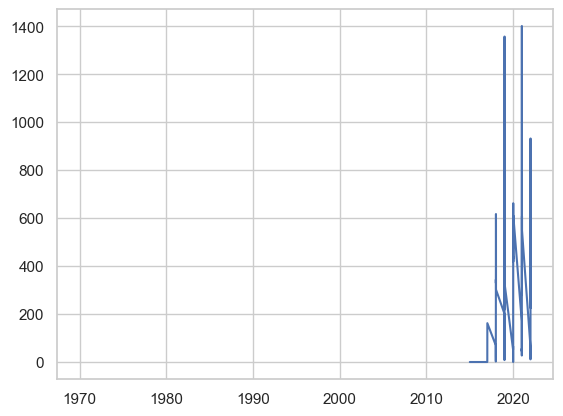

368.8433615717014

Material: ABCDEF
 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=1251.189, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=1246.497, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=1248.533, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=1248.566, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=1236.114, Time=0.17 sec
 ARIMA(3,1,0)(0,0,0)[1] 

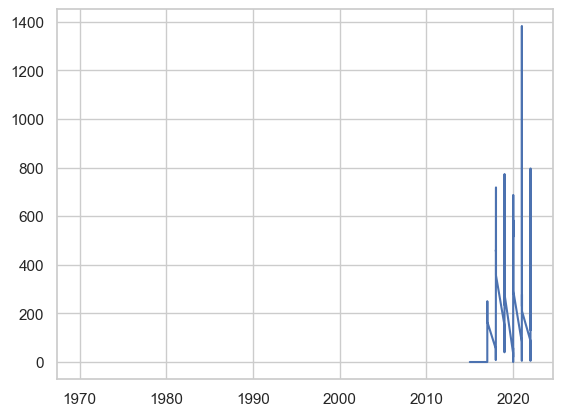

260.65925196798395

Material: ABCDEFG
 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=1324.808, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=1317.263, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.04 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=1320.959, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=1319.313, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(3,1,0)(0,0,0)[1] int

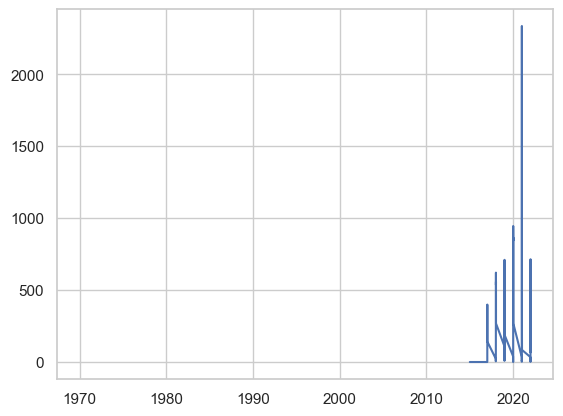

109.83626001938339

Material: ABCDEFGH
 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=1290.217, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=1260.974, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=1260.656, Time=0.06 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=1262.425, Time=0.08 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=1263.201, Time=0.13 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=1265.160, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=1280.748, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=1261.109, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=1262.589, Time=0.18 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=1273.893, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=1261.910, Time=0.08 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=1265.159, 

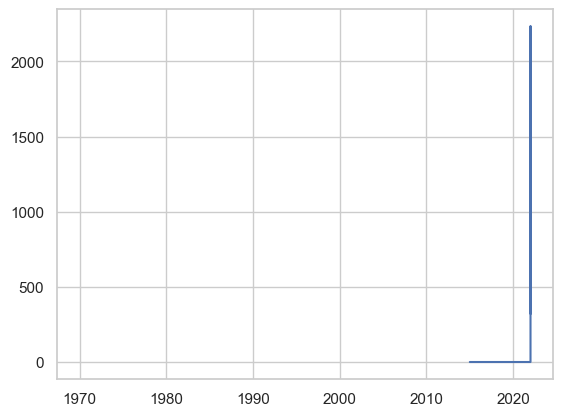

386.0744013561256

Material: ABCDEFGHI
 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=1151.935, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=1123.005, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=1124.745, Time=0.05 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=1125.584, Time=0.07 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=1125.223, Time=0.10 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=1126.817, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=1138.724, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=1124.823, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=1126.999, Time=0.07 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=1126.844, Time=0.19 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=1131.762, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=1125.366, Time=0.09 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=1126.151, Time=0.14 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=

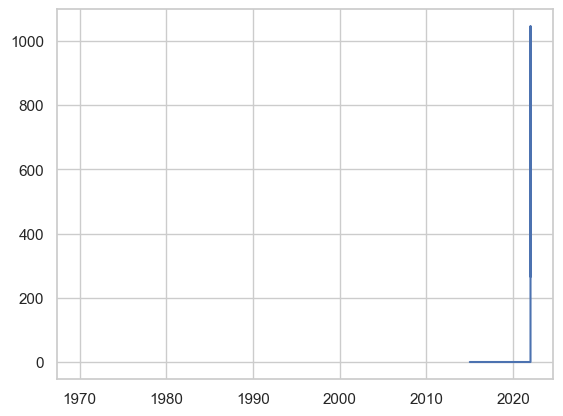

267.741937053033

Material: ABCDEFGHIJ
 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=1117.036, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=1109.647, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=1104.202, Time=0.05 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=1105.924, Time=0.07 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=1105.192, Time=0.10 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=1106.981, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=1116.272, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=1107.247, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=1106.103, Time=0.09 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=1108.162, Time=0.16 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=1107.008, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=1106.549, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=1103.771, Time=0.09 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=1104.963, Time=0.10 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   :

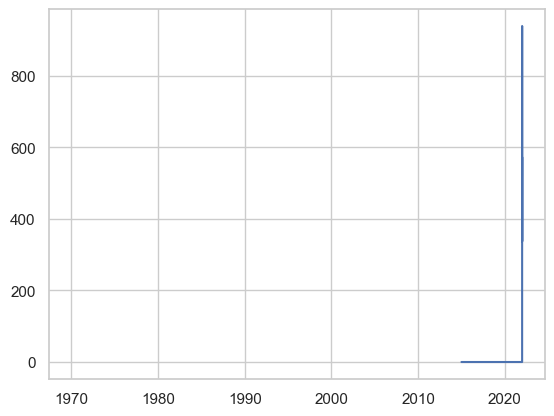

235.12942170717895

Material: ABCDEFGHIJK
 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=1353.276, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=1350.303, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=1346.757, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=1330.943, Time=0.18 sec
 ARIMA(3,1,0)(0,0,0)[1]

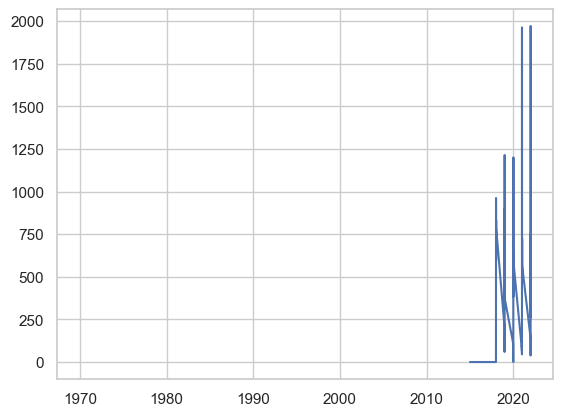

288.7017677578283

Material: ABCDEFGHIJKL
 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=992.595, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=984.505, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=972.517, Time=0.05 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=973.220, Time=0.07 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=975.147, Time=0.09 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=990.165, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=973.456, Time=0.07 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=986.485, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=973.305, Time=0.09 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(

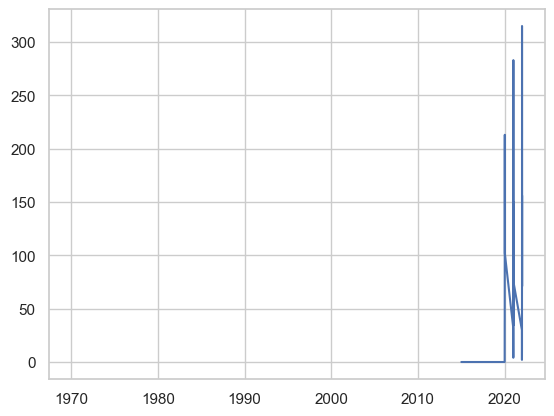

93.11519478173761

Material: ABCDEFGHIJKLM
 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=1145.081, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=1112.155, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=1110.770, Time=0.05 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=1112.765, Time=0.08 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=1114.425, Time=0.13 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=1134.257, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=1111.037, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=1112.767, Time=0.09 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=1111.973, Time=0.11 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=1114.157, Time=0.20 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=1127.038, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=1112.712, Time=0.08 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=1113.568, Time=0.09 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : 

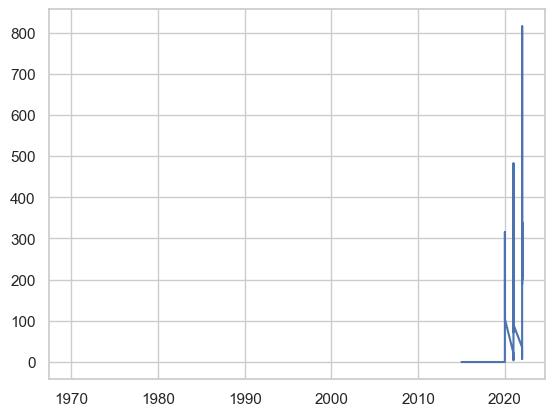

123.2838210289178

Material: ABCDEFGHIJKLMN
 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=1201.111, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=1170.817, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=1168.824, Time=0.06 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=1170.408, Time=0.09 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=1187.315, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=1168.320, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=1170.771, Time=0.14 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=1182.607, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=1170.163, Time=0.12 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=1170.905, Time=0.16 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=inf, Time=

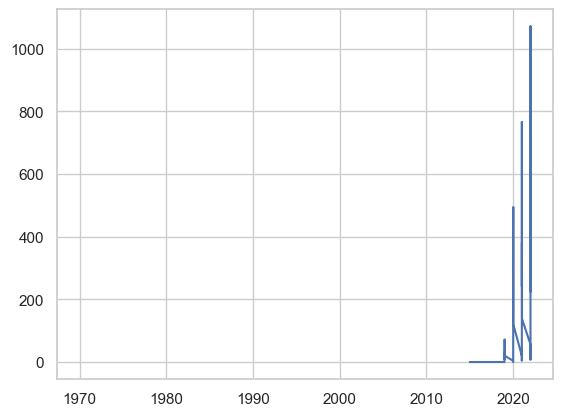

172.33142331860506

Material: ABCDEFGHIJKLMNO
 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=1600.816, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=1571.680, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=1569.644, Time=0.08 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=1571.759, Time=0.16 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=1571.675, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=1593.411, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=1570.205, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=1572.274, Time=0.15 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=1574.744, Time=0.23 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=1590.077, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=1570.912, Time=0.12 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=inf

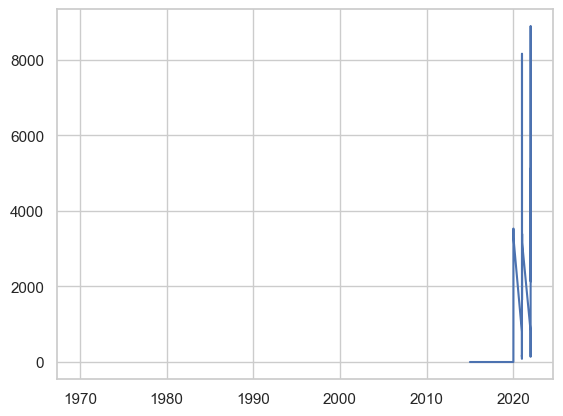

748.9041174370395



MaterialNumber    Actual             Predicted        RMSE
0                AB   [[442]]  [1017.5070888454519]  575.507089
1               ABC   [[648]]   [1265.627243800707]  617.627244
2              ABCD   [[836]]   [1570.057883232585]  734.057883
3             ABCDE   [[200]]   [568.8433615717014]  368.843362
4            ABCDEF   [[101]]  [361.65925196798395]  260.659252
5           ABCDEFG   [[104]]   [213.8362600193834]  109.836260
6          ABCDEFGH   [[163]]   [549.0744013561256]  386.074401
7         ABCDEFGHI   [[148]]    [415.741937053033]  267.741937
8        ABCDEFGHIJ   [[257]]  [492.12942170717895]  235.129422
9       ABCDEFGHIJK   [[289]]   [577.7017677578283]  288.701768
10     ABCDEFGHIJKL    [[30]]  [123.11519478173761]   93.115195
11    ABCDEFGHIJKLM    [[78]]   [201.2838210289178]  123.283821
12   ABCDEFGHIJKLMN   [[113]]  [285.33142331860506]  172.331423
13  ABCDEFGHIJKLMNO  [[2781]]  [3529.9041174370395]  748.904117

In [35]:
def forecast_sales_autoarima(df, material):
    df_material = prepare_data(df, material)
    print(f"Material: {material}")
    train = df_material[:-1]
    test = df_material[-1:]
    
    model = auto_arima(train, seasonal=True, stepwise=False, trace=True, error_action='ignore', suppress_warnings=True)
    model.fit(train)
    forecast = model.predict(n_periods=1)
    actual = test.values
    predicted = forecast.values
    forecast = pd.DataFrame(forecast,columns=['Prediction'])
    

    plt.plot(train, label='Train')
    plt.plot(actual, label='Actual')
    plt.plot(forecast, label='Prediction')
    plt.show()

    rms = np.sqrt(mean_squared_error(actual,forecast))
    print(rms)
    print()
    
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    
    return actual, predicted, rmse

results_autoarima = []

for material in materials:
    actual, predicted, rmse = forecast_sales_autoarima(data, material)
    results_autoarima.append((material, actual, predicted, rmse))

results_autoarima_df = pd.DataFrame(results_autoarima, columns=['MaterialNumber', 'Actual', 'Predicted', 'RMSE'])

results_autoarima_df

In [82]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [83]:

# SARIMA model
def forecast_sales_sarima(df, material, order=(2,0,2), seasonal_order=(0,1,1,11)):
    df_material = prepare_data(df, material)
    train = df_material[:-1]  # Up to November 2022
    test = df_material[-1:]  # December 2022
    
    model = SARIMAX(train, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit(disp=False)
    forecast = model_fit.forecast(steps=1)
    
    actual = test.values
    predicted = forecast.values
    
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    
    return actual[0], predicted[0], rmse

results_sarima = []

for material in materials:
    actual, predicted, rmse = forecast_sales_sarima(data, material)
    results_sarima.append((material, actual, predicted, rmse))

results_sarima_df = pd.DataFrame(results_sarima, columns=['MaterialNumber', 'Actual', 'Predicted', 'RMSE'])
results_sarima_df

MaterialNumber  Actual    Predicted        RMSE
0                AB   [442]   280.833897  161.166103
1               ABC   [648]   666.161134   18.161134
2              ABCD   [836]   792.785449   43.214551
3             ABCDE   [200]   121.783268   78.216732
4            ABCDEF   [101]   231.663572  130.663572
5           ABCDEFG   [104]   165.923044   61.923044
6          ABCDEFGH   [163]   488.246105  325.246105
7         ABCDEFGHI   [148]   375.844800  227.844800
8        ABCDEFGHIJ   [257]   485.419951  228.419951
9       ABCDEFGHIJK   [289]   442.319681  153.319681
10     ABCDEFGHIJKL    [30]    93.586345   63.586345
11    ABCDEFGHIJKLM    [78]   134.617888   56.617888
12   ABCDEFGHIJKLMN   [113]   163.883151   50.883151
13  ABCDEFGHIJKLMNO  [2781]  2494.201307  286.798693

In [ ]:
# SARIMA model for all
def forecast_sales_sarima(df, material, test_size, order=(2,0,2), seasonal_order=(0,1,1,11)):
    df_material = prepare_data(df, material)
    train = df_material[:-test_size]
    test = df_material[-test_size:]
    
    model = SARIMAX(train, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit(disp=False)
    forecast = model_fit.forecast(steps=test_size)
    
    actual = test.values
    predicted = forecast.values
    
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    
    return actual, predicted, rmse

# Evaluate SARIMA for all materials with variable window sizes
materials = data['MaterialNumber'].unique()  # Assuming data is a DataFrame
window_sizes = [24, 18, 12, 6, 3, 1]  # Window sizes in months
results_sarima = []

for material in materials:
    for window_size in window_sizes:
        try:
            actual, predicted, rmse = forecast_sales_sarima(data, material, test_size=window_size)
            for a, p in zip(actual, predicted):
                results_sarima.append((material, a, p, rmse, window_size))
        except Exception as e:
            print(f"Error for material {material} with window size {window_size}: {e}")

results_sarima_df = pd.DataFrame(results_sarima, columns=['MaterialNumber', 'Actual', 'Predicted', 'RMSE', 'WindowSize'])

plt.figure(figsize=(12, 8))
for material in materials:
    material_data = results_sarima_df[results_sarima_df['MaterialNumber'] == material]
    plt.plot(material_data['WindowSize'], material_data['RMSE'], label=f'Material {material}')
    plt.xlabel('Window Size (Months)')
    plt.ylabel('RMSE')
    plt.title('RMSE vs Window Size for Different Materials')
    plt.legend()
    plt.show()

results_sarima_df

In [ ]:
# Save the DataFrame to a CSV file
results_sarima_df.to_csv('sarima_forecast_results.csv', index=False)

In [38]:
def forecast_sales_sarima_tuned_parallel(df, material, params):
    df_material = prepare_data(df, material)
    train = df_material[:-1]
    test = df_material[-1:]
    
    p, d, q, P, D, Q = params
    try:
        model = SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, 11))
        model_fit = model.fit(disp=False)
        forecast = model_fit.forecast(steps=1)
        mse = mean_squared_error(test.values, forecast.values)
        rmse = np.sqrt(mse)
        return rmse, (p, d, q), (P, D, Q, 11), forecast.values
    except:
        return float('inf'), None, None, None

# Evaluate tuned SARIMA for all materials in parallel
def evaluate_material_parallel(material):
    params = [(p, d, q, P, D, Q) for p in range(0, 2) for d in range(0, 2) for q in range(0, 2) for P in range(0, 2) for D in range(0, 2) for Q in range(0, 2)]
    
    with concurrent.futures.ProcessPoolExecutor() as executor:
        futures = [executor.submit(forecast_sales_sarima_tuned_parallel, data, material, param) for param in params]
        results = [future.result() for future in concurrent.futures.as_completed(futures)]
    
    best_result = min(results, key=lambda x: x[0])
    best_rmse, best_order, best_seasonal_order, best_forecast = best_result
    
    df_material = prepare_data(data, material)
    actual = df_material.values[-1][0]
    
    return material, actual, best_forecast[0], best_rmse, best_order, best_seasonal_order

results_sarima_tuned_parallel = []

for material in materials:
    result = evaluate_material_parallel(material)
    results_sarima_tuned_parallel.append(result)

# Convert results to DataFrame for better visualization
results_sarima_tuned_parallel_df = pd.DataFrame(results_sarima_tuned_parallel, columns=['MaterialNumber', 'Actual', 'Predicted', 'RMSE', 'Order', 'SeasonalOrder'])
results_sarima_tuned_parallel_df


MaterialNumber  Actual    Predicted       RMSE      Order  SeasonalOrder
0                AB     442   444.750810   2.750810  (1, 1, 1)  (0, 1, 0, 11)
1               ABC     648   663.363604  15.363604  (1, 0, 1)  (1, 1, 1, 11)
2              ABCD     836   835.778295   0.221705  (1, 0, 1)  (0, 1, 0, 11)
3             ABCDE     200   185.067357  14.932643  (0, 1, 1)  (1, 1, 1, 11)
4            ABCDEF     101   100.162076   0.837924  (1, 0, 0)  (0, 1, 0, 11)
5           ABCDEFG     104   105.802888   1.802888  (1, 1, 1)  (1, 1, 0, 11)
6          ABCDEFGH     163   176.478990  13.478990  (0, 0, 1)  (1, 1, 1, 11)
7         ABCDEFGHI     148   106.421025  41.578975  (0, 0, 1)  (0, 0, 1, 11)
8        ABCDEFGHIJ     257   193.001110  63.998890  (0, 0, 1)  (1, 1, 1, 11)
9       ABCDEFGHIJK     289   282.744566   6.255434  (1, 1, 0)  (1, 1, 0, 11)
10     ABCDEFGHIJKL      30    30.000000   0.000000  (0, 0, 0)  (0, 1, 0, 11)
11    ABCDEFGHIJKLM      78    77.803549   0.196451  (1, 0, 0)  (1, 0, 0, 11)
12   ABCDEFGHIJKLMN     113   111.531393   1.468607  (1, 0, 1)  (1, 1, 0, 11)
13  ABCDEFGHIJKLMNO    2781  2781.310840   0.310840  (0, 1, 1)  (1, 0, 0, 11)

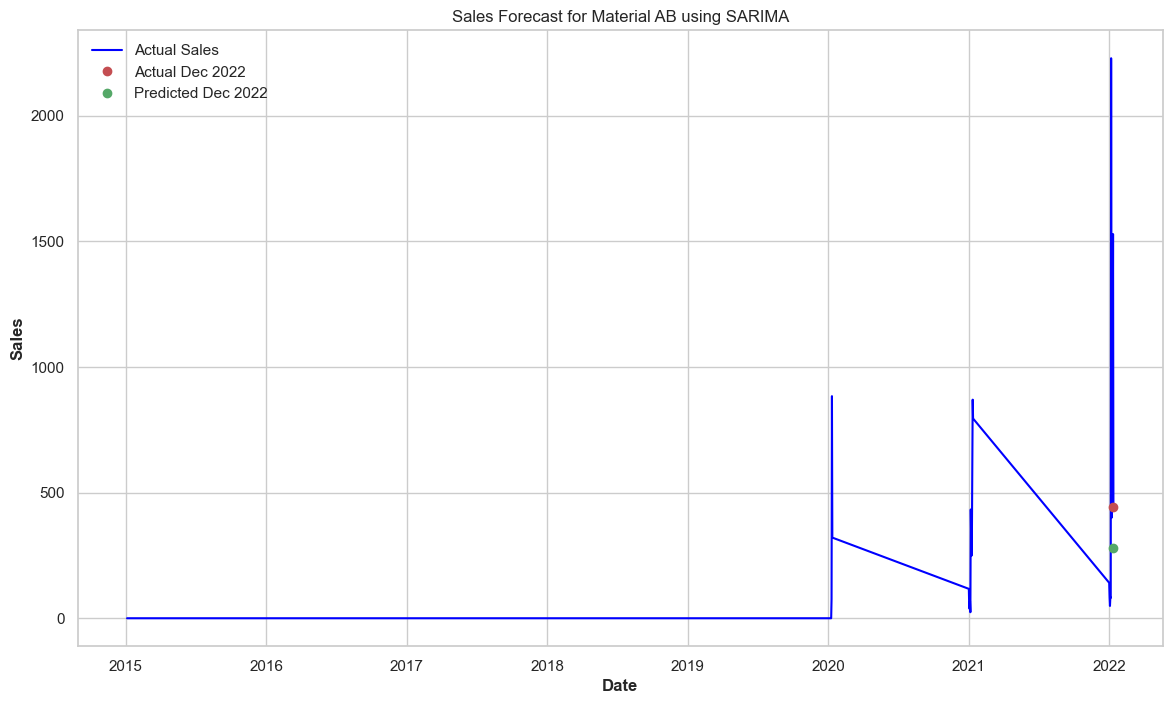

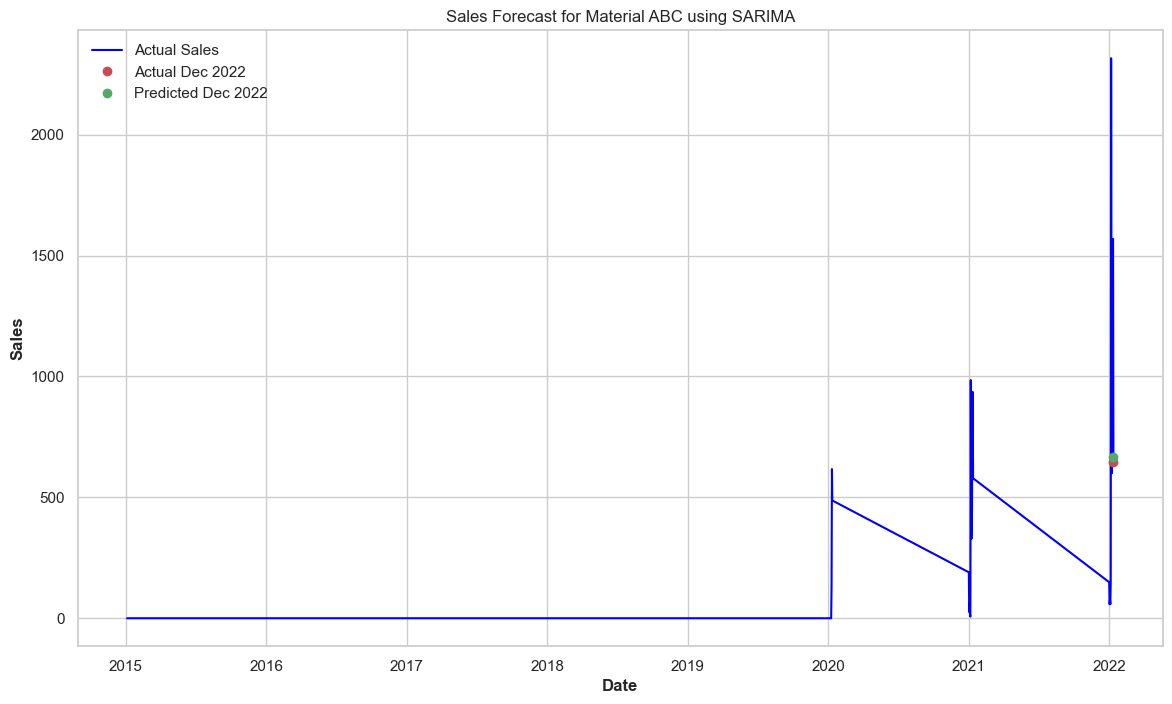

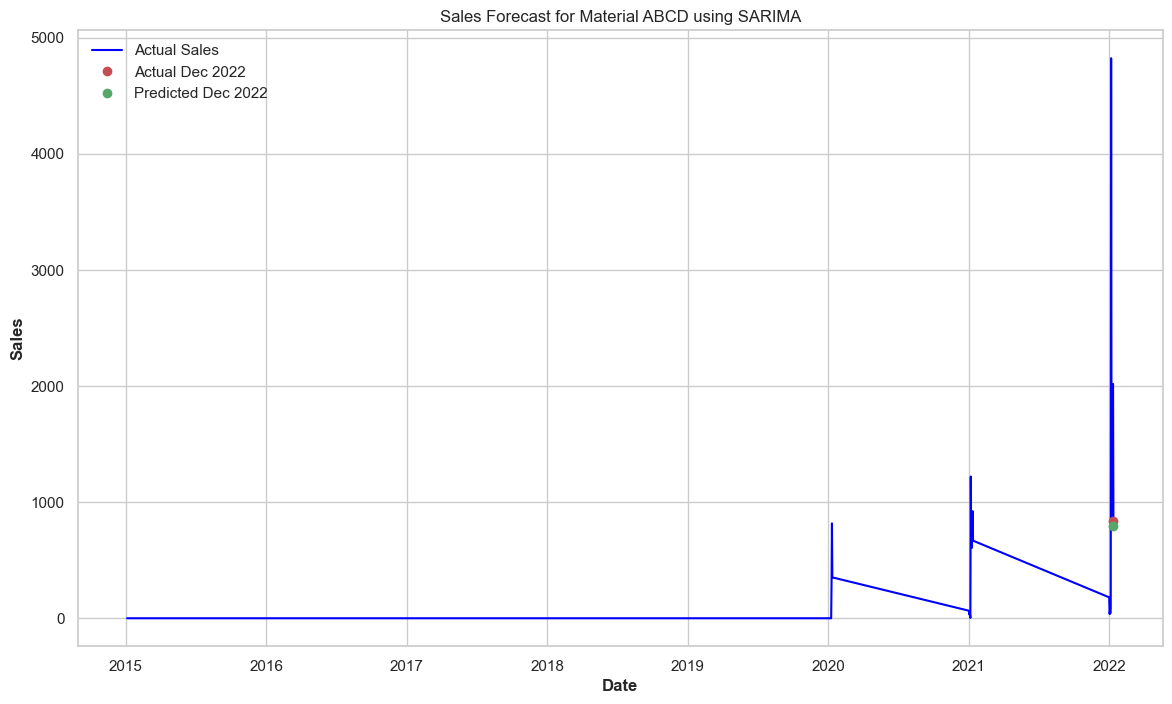

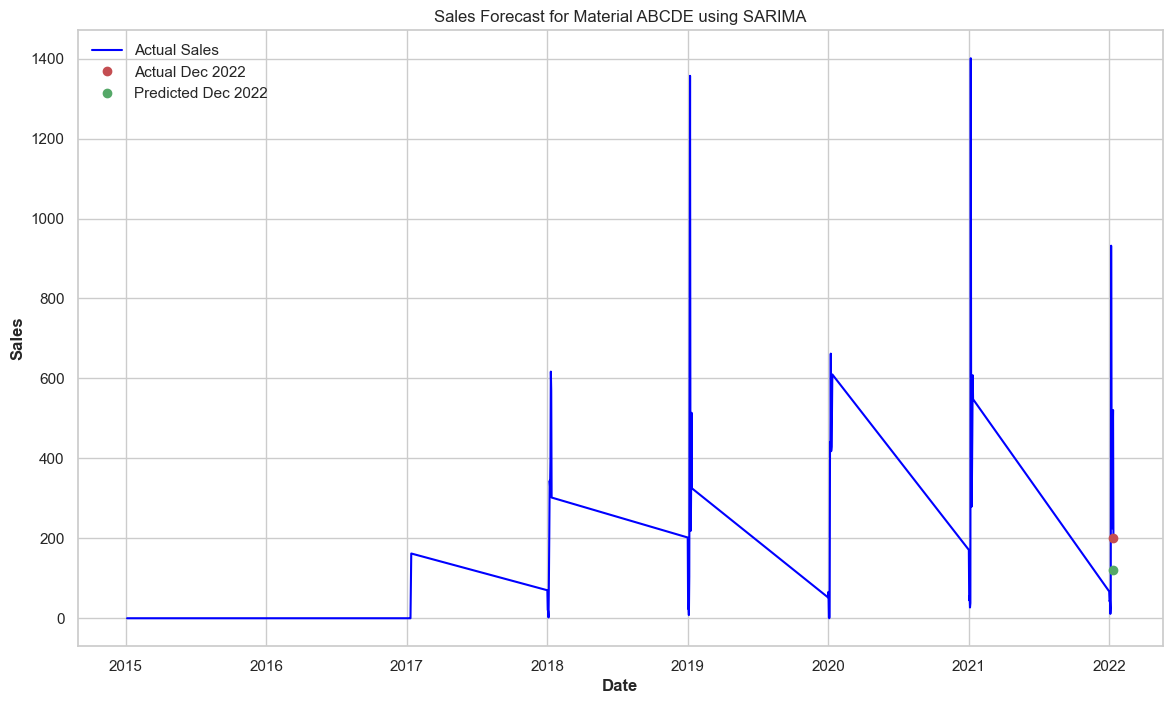

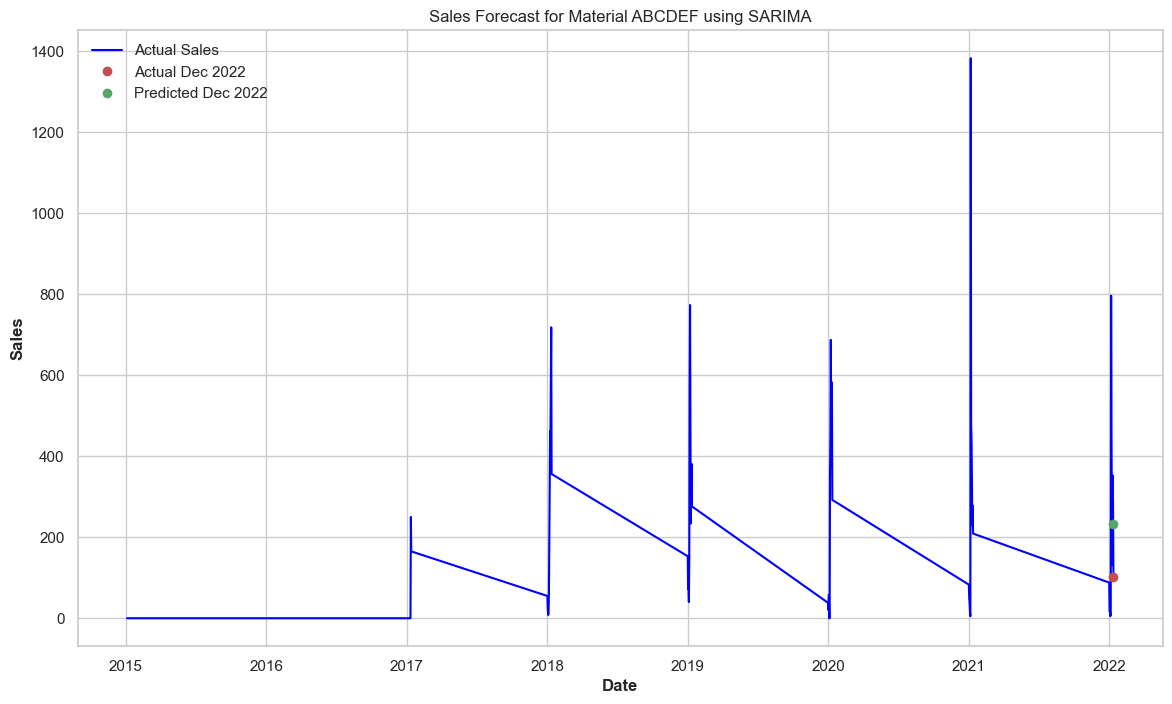

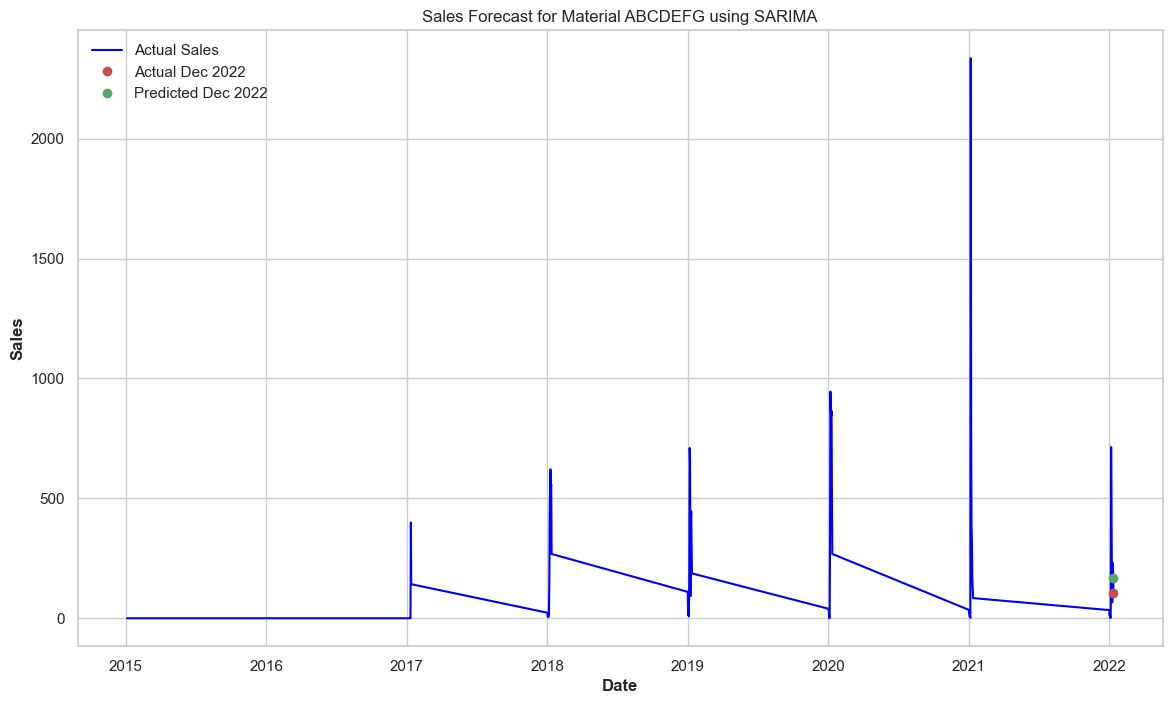

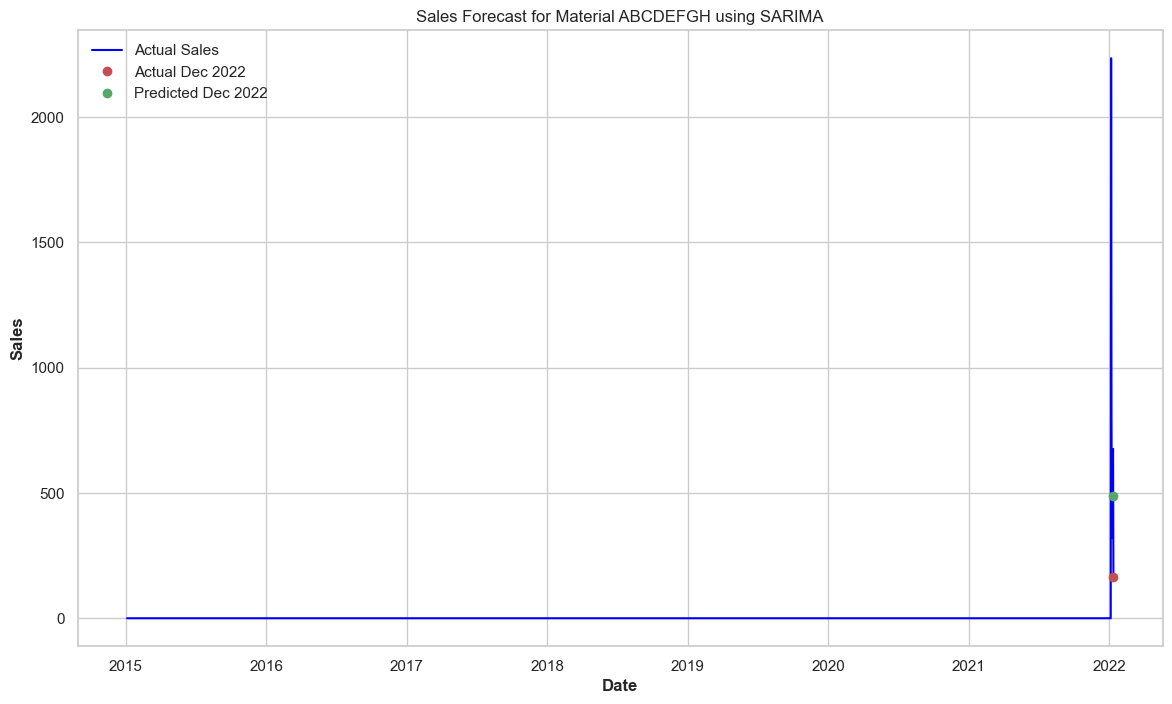

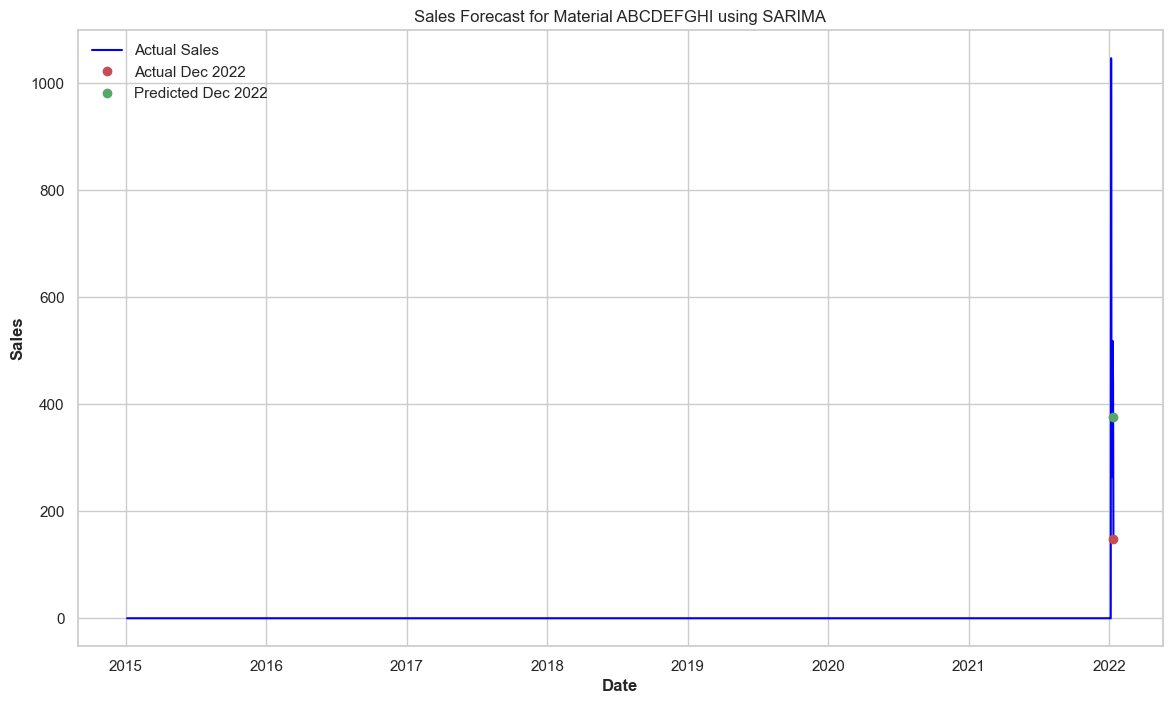

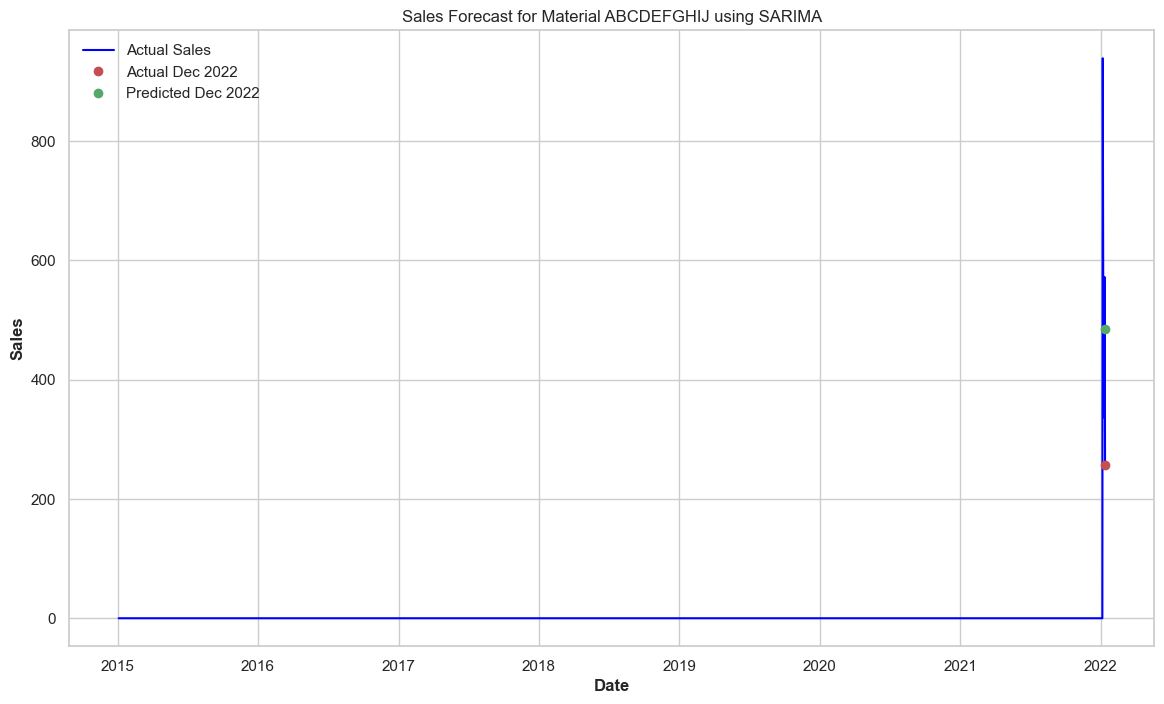

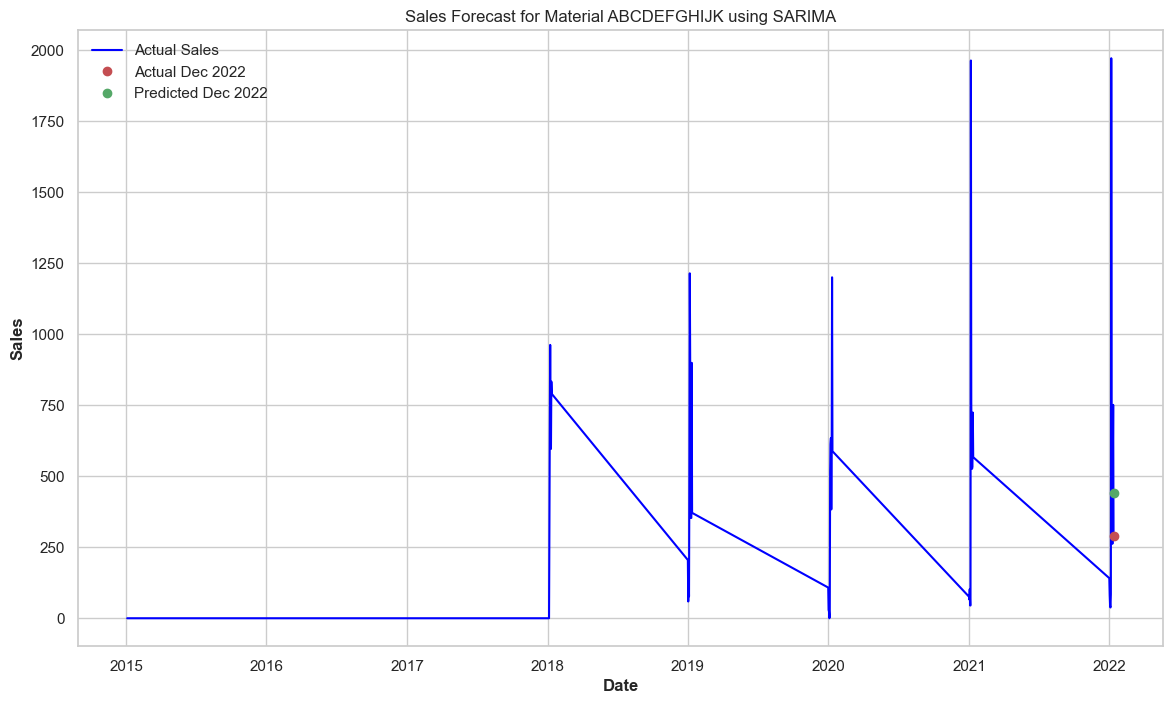

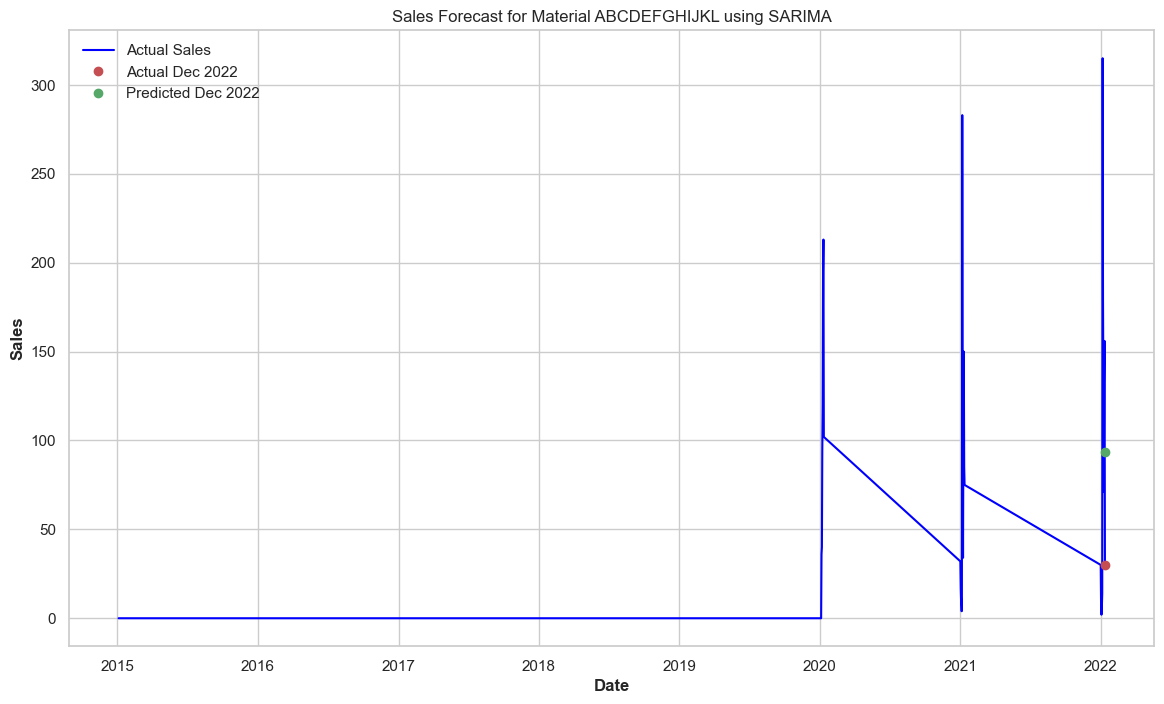

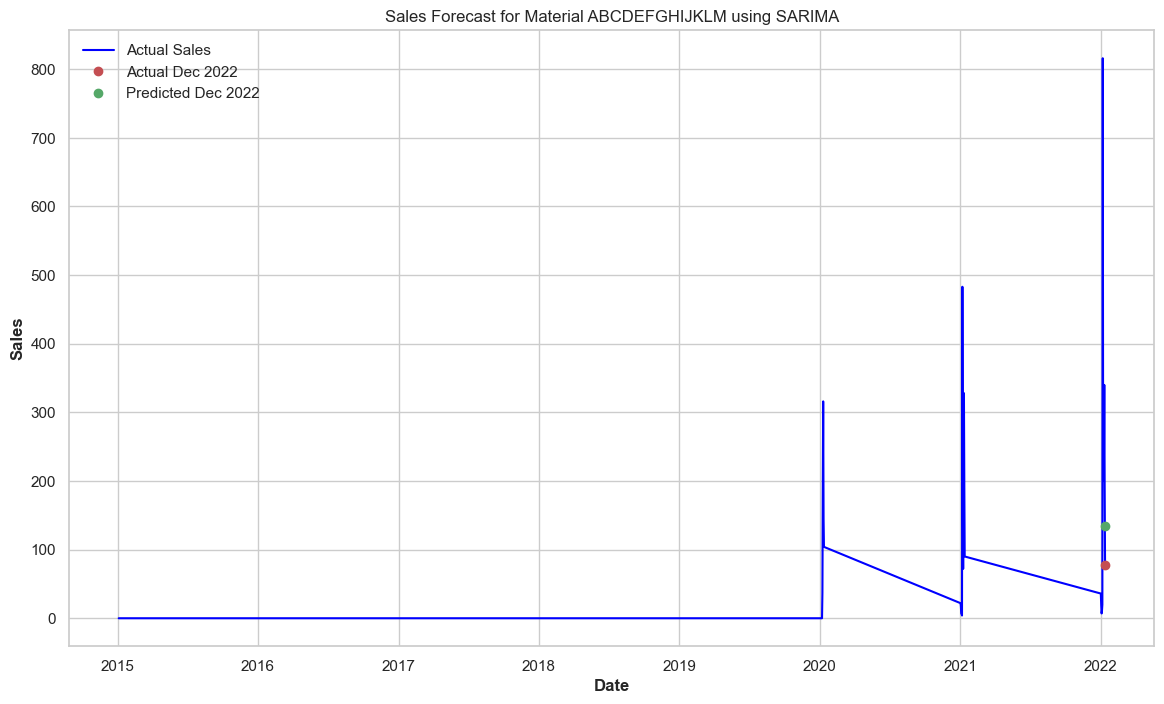

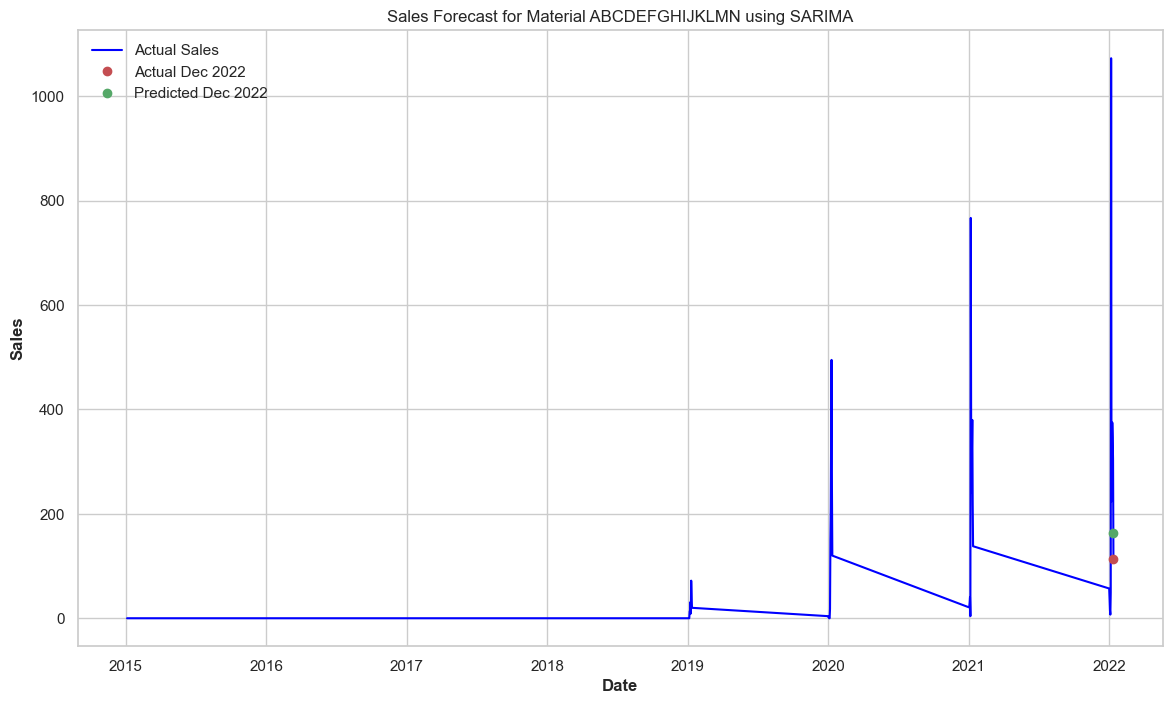

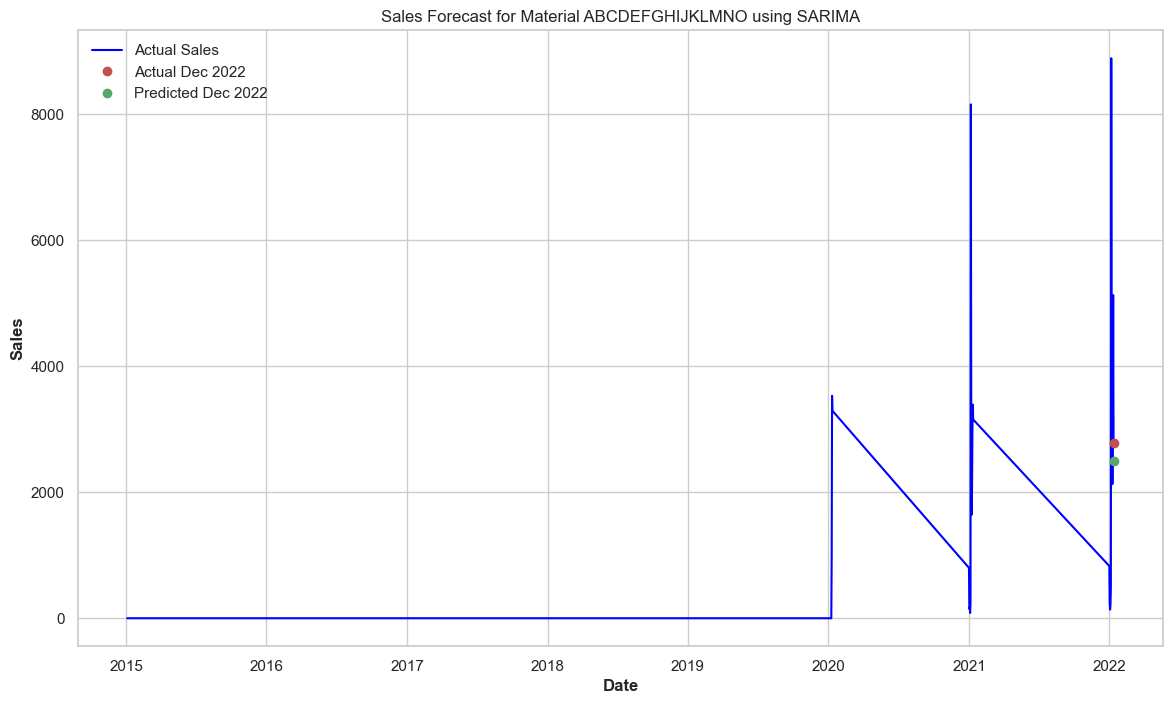

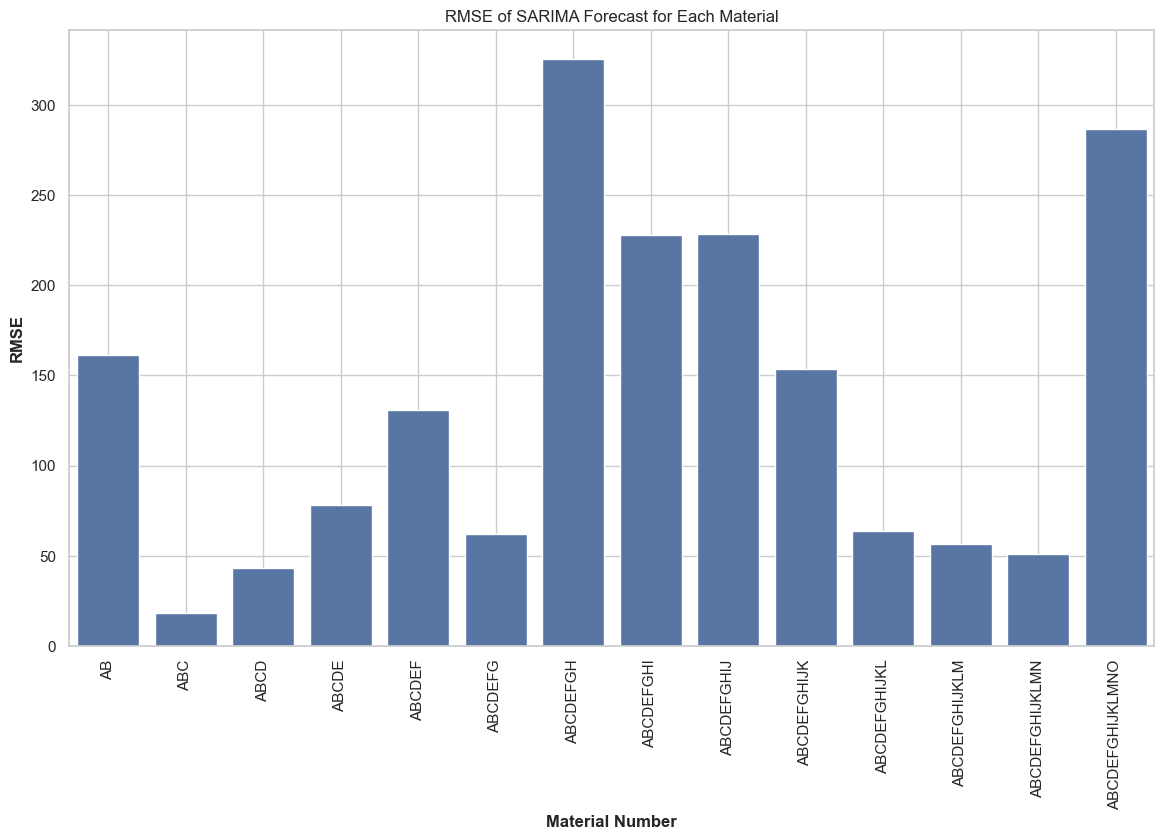

In [39]:
# Function to plot the results for a specific material
def plot_forecast_sarima(df, material, actual, predicted):
    df_material = prepare_data(df, material)
    
    plt.figure(figsize=(14, 8))
    plt.plot(df_material.index, df_material['Sales'], label='Actual Sales', color='blue')
    plt.plot(df_material.index[-1:], actual, 'ro', label='Actual Dec 2022')
    plt.plot(df_material.index[-1:], predicted, 'go', label='Predicted Dec 2022')
    
    # forecast_index = pd.date_range(start=df_material.index[-1], periods=2, freq='M')[1]
    # plt.plot(forecast_index, predicted, 'go', label='Predicted Dec 2022')
    
    plt.title(f'Sales Forecast for Material {material} using SARIMA')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plotting results for all materials
for index, row in results_sarima_df.iterrows():
    material = row['MaterialNumber']
    actual = row['Actual']
    predicted = row['Predicted']
    plot_forecast_sarima(data, material, actual, predicted)

# Plot RMSE for all materials
plt.figure(figsize=(14, 8))
sns.barplot(x='MaterialNumber', y='RMSE', data=results_sarima_df)
plt.title('RMSE of SARIMA Forecast for Each Material')
plt.xlabel('Material Number')
plt.ylabel('RMSE')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()


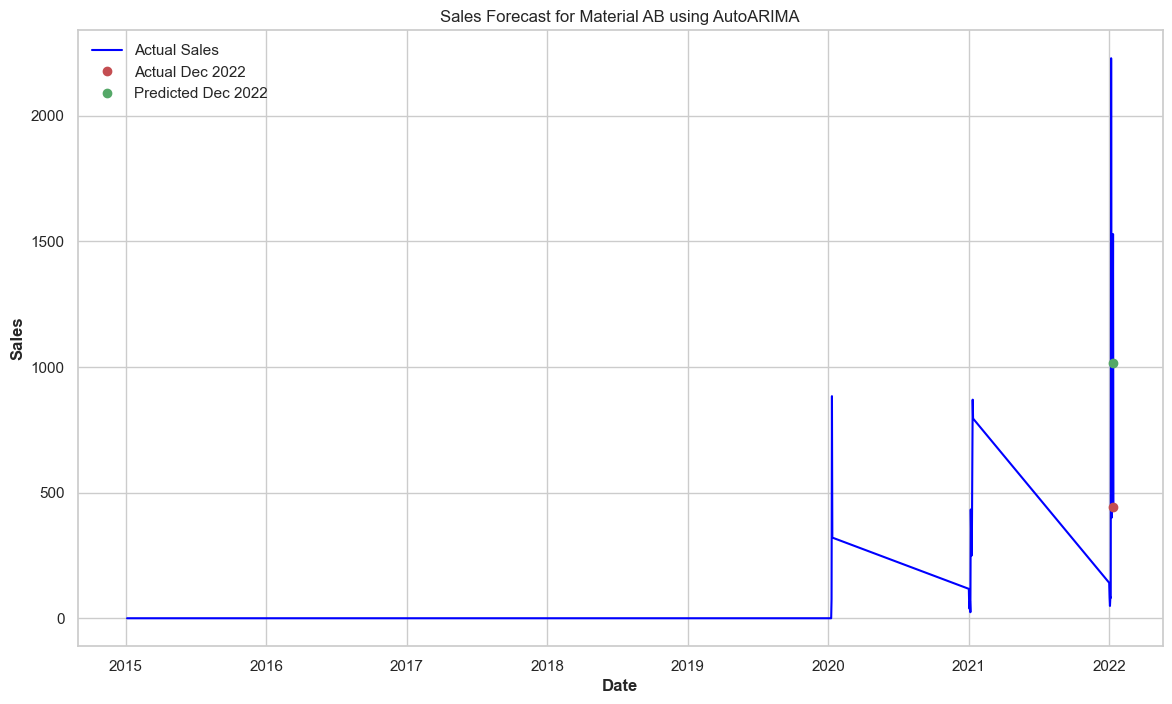

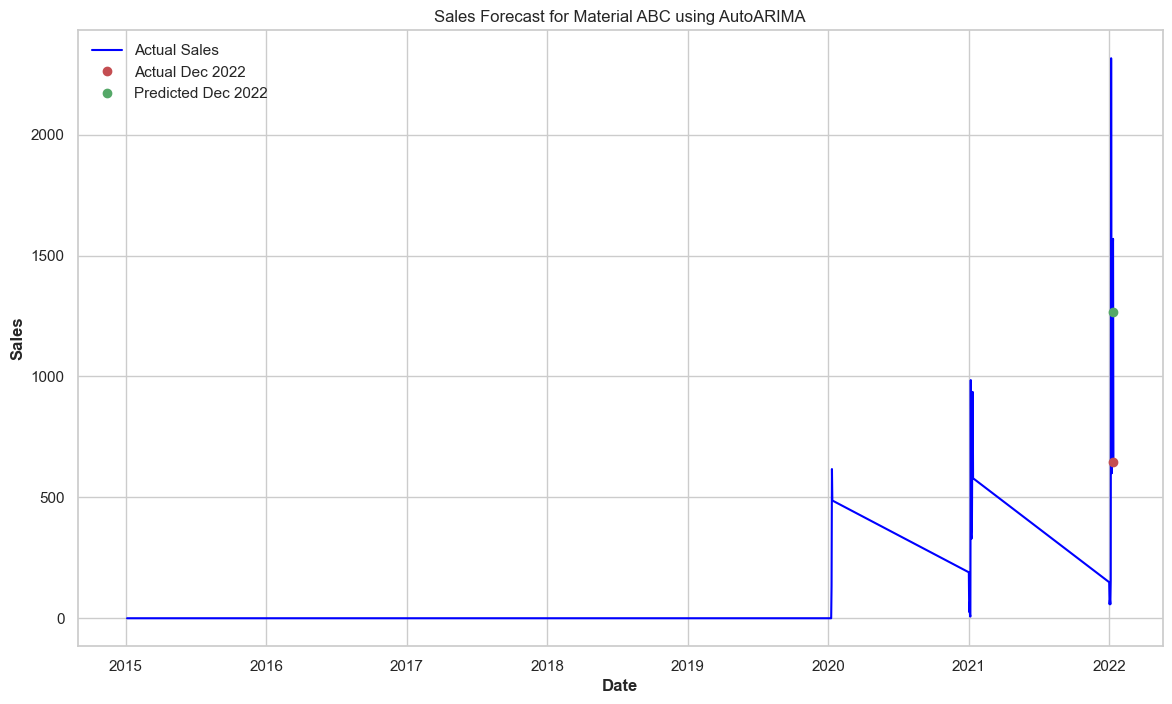

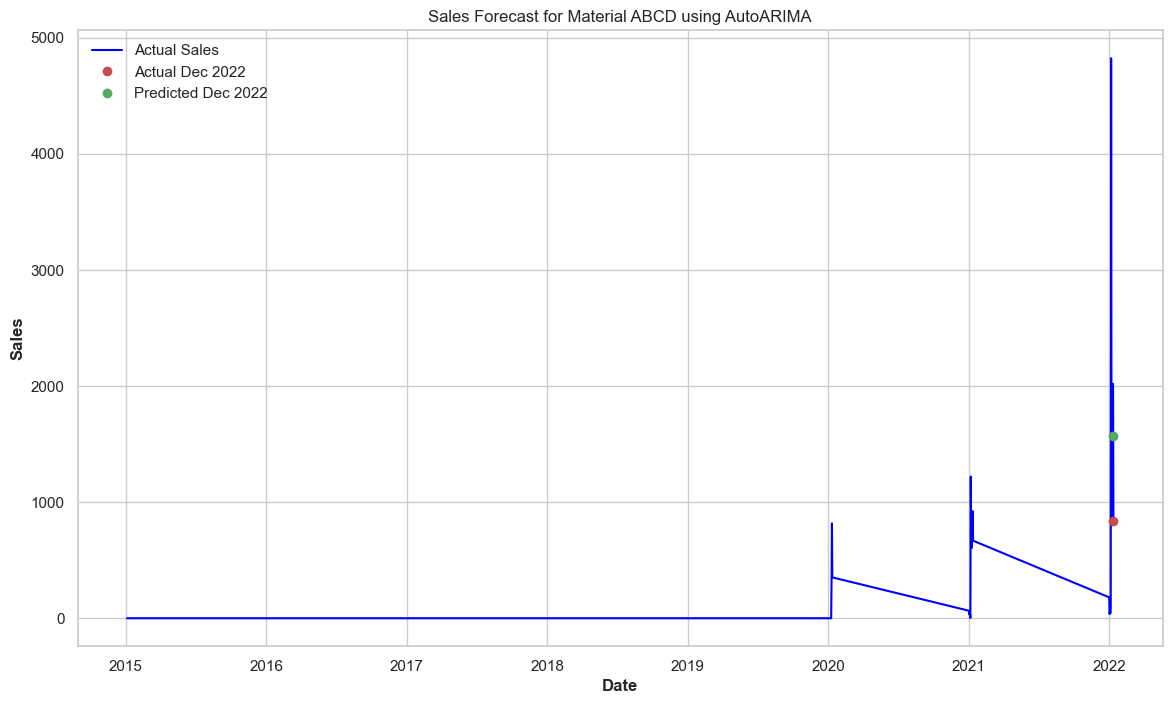

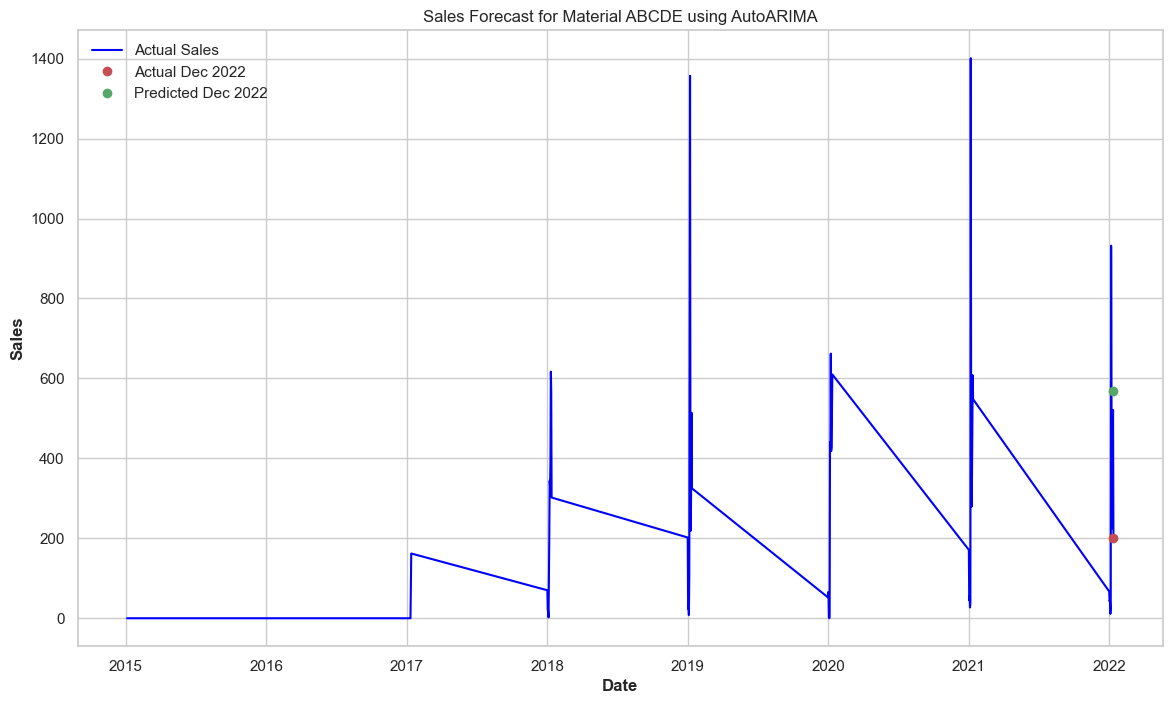

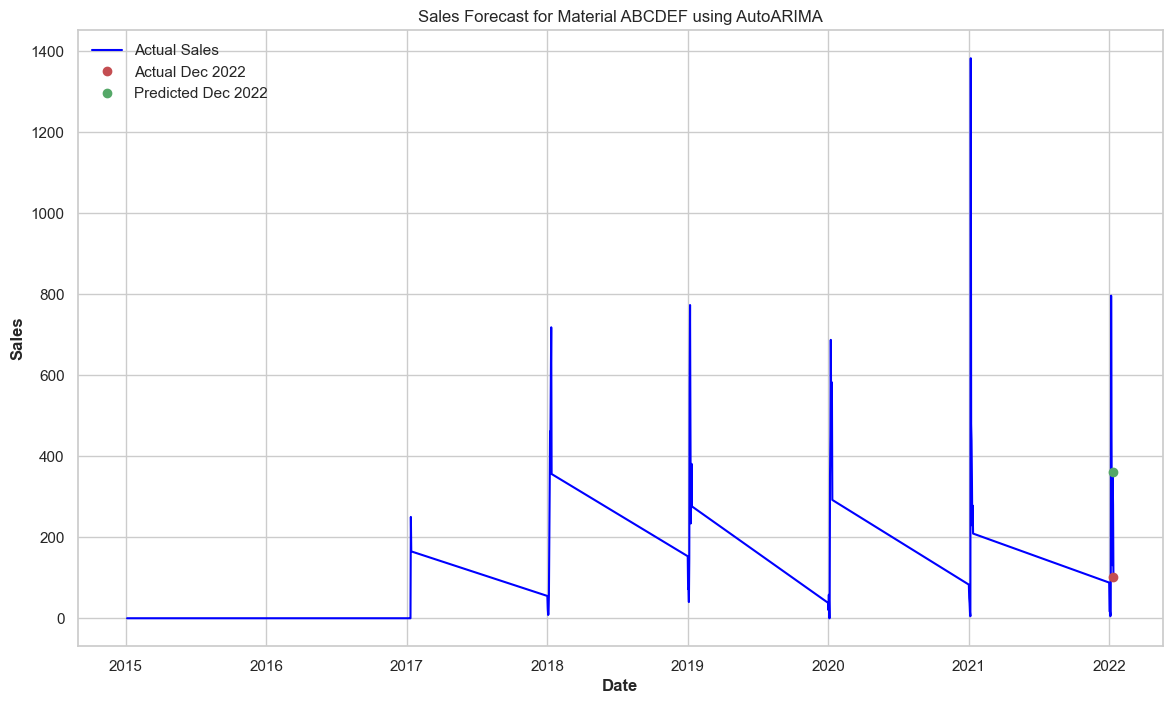

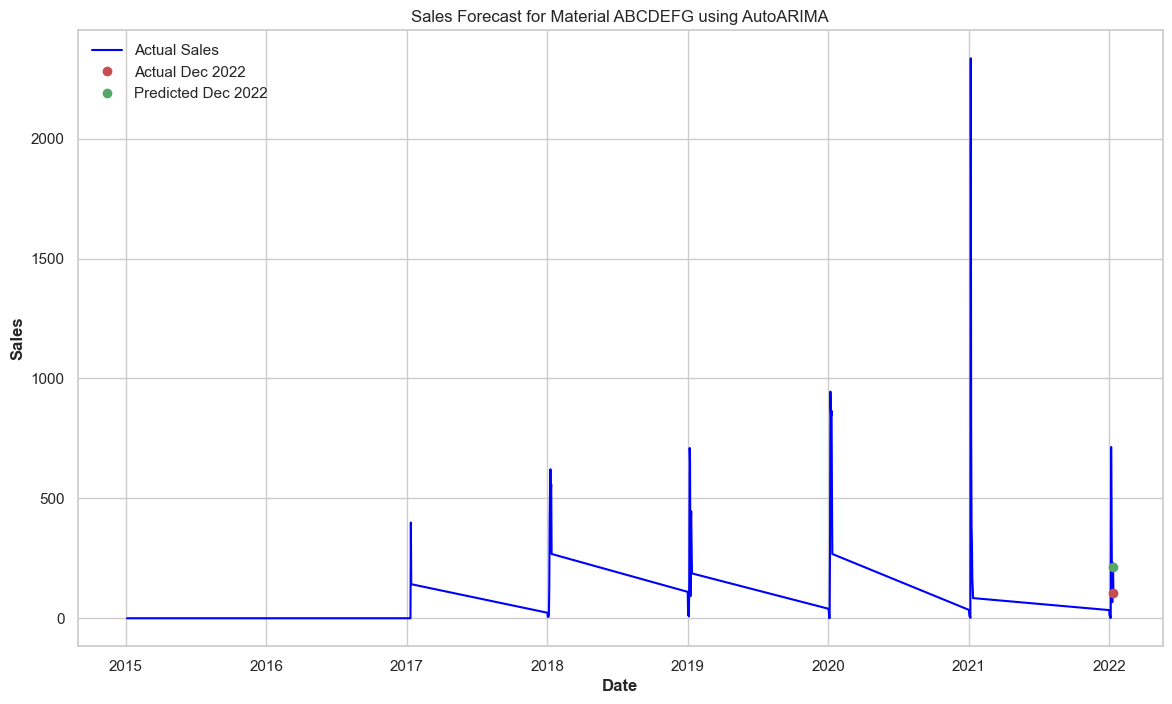

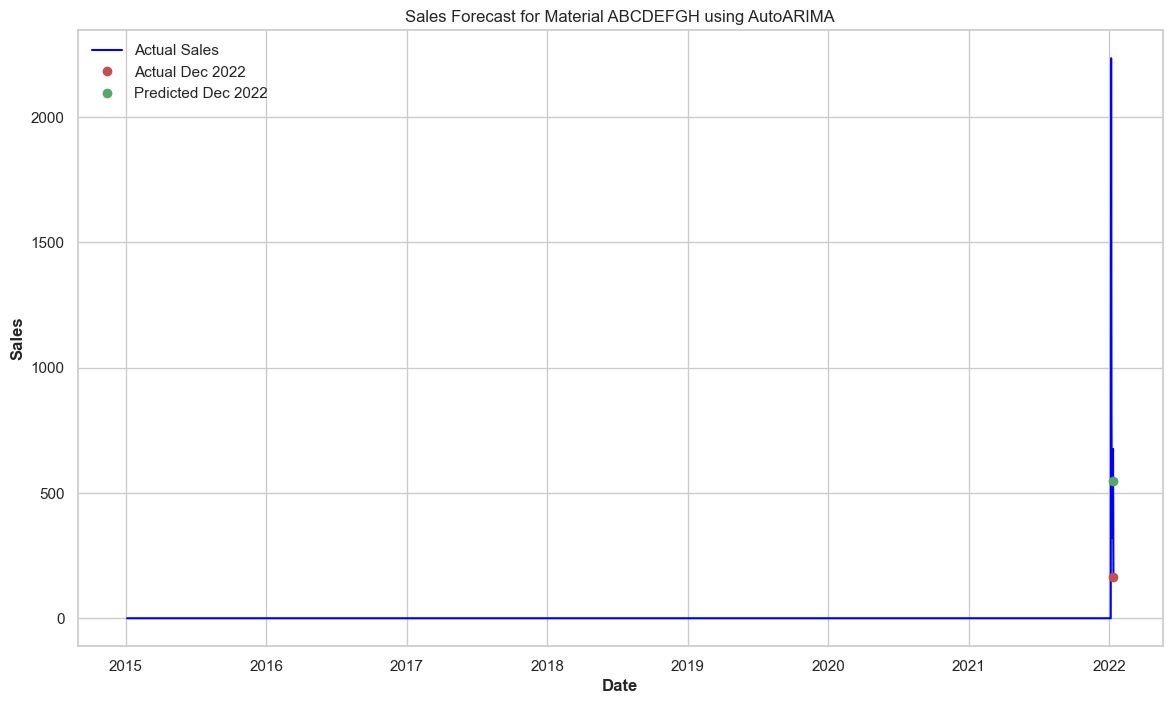

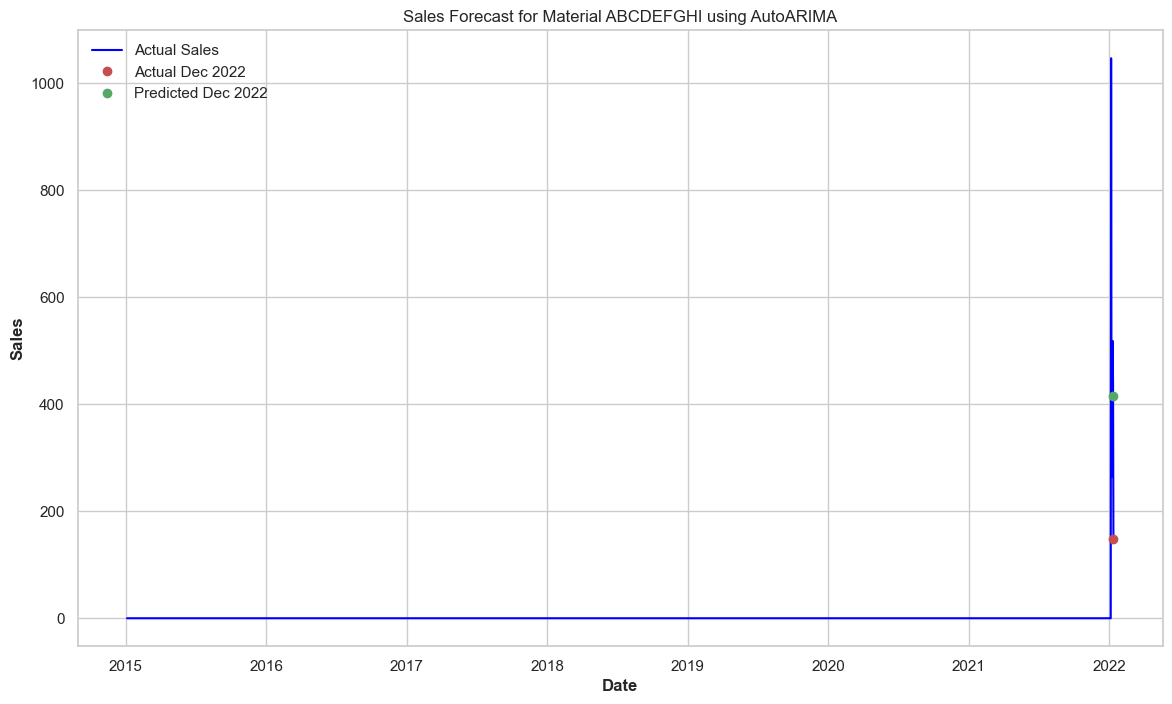

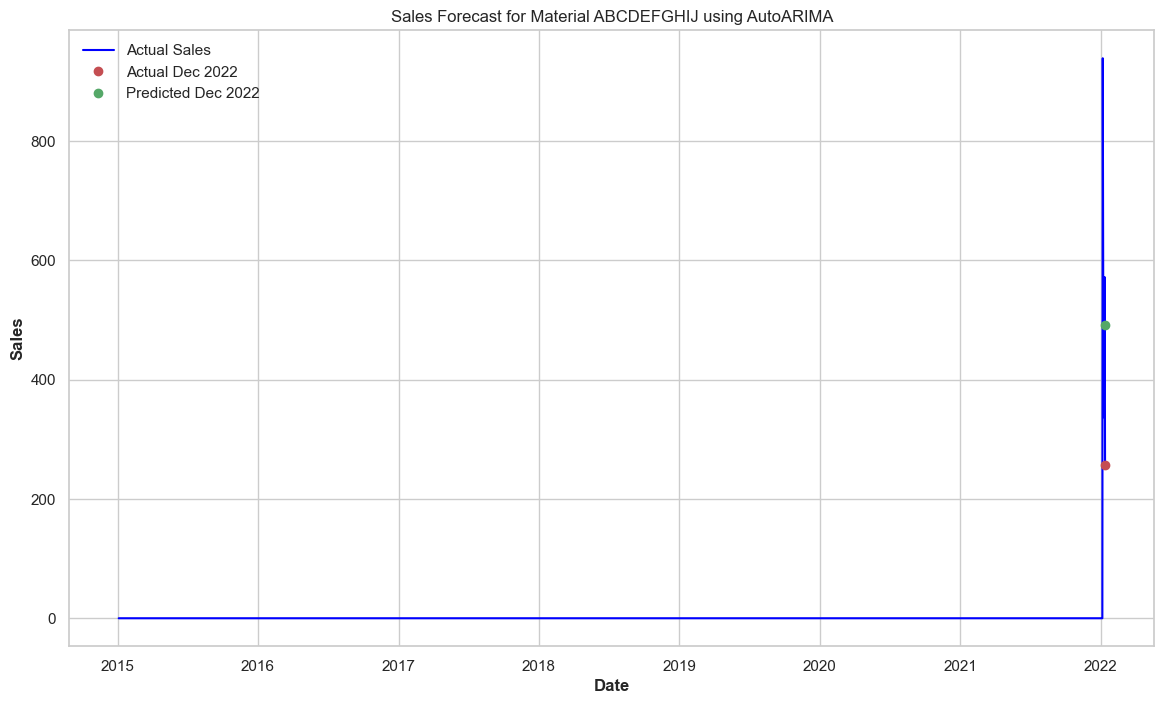

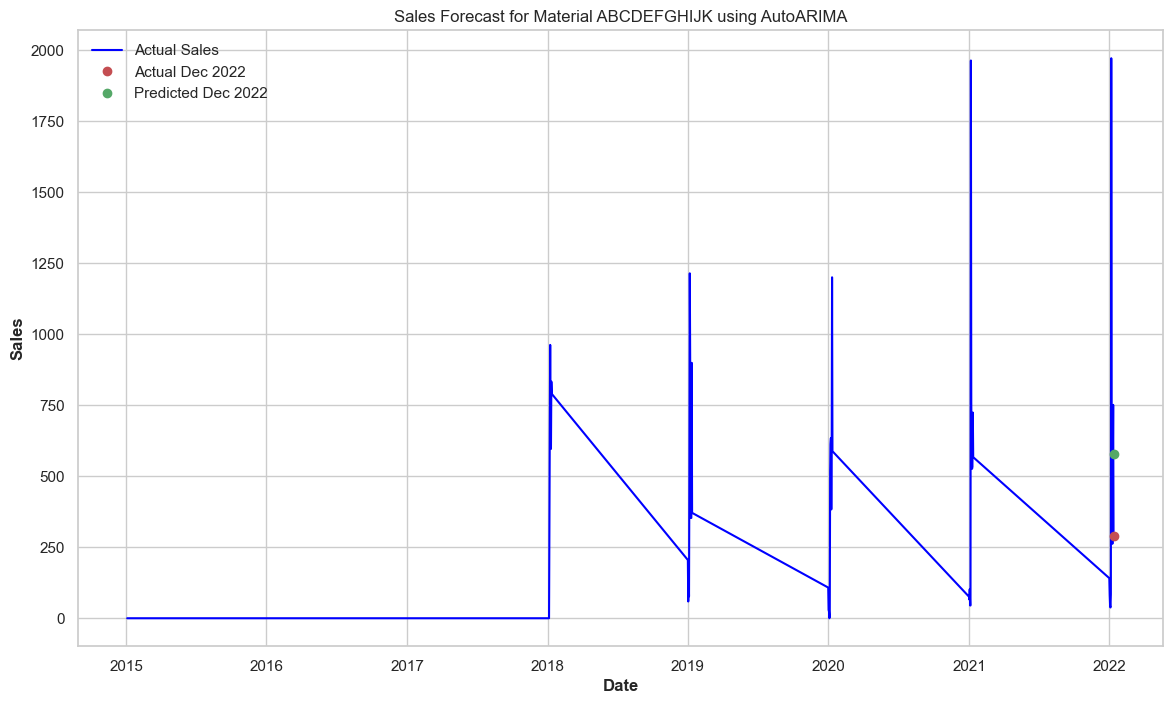

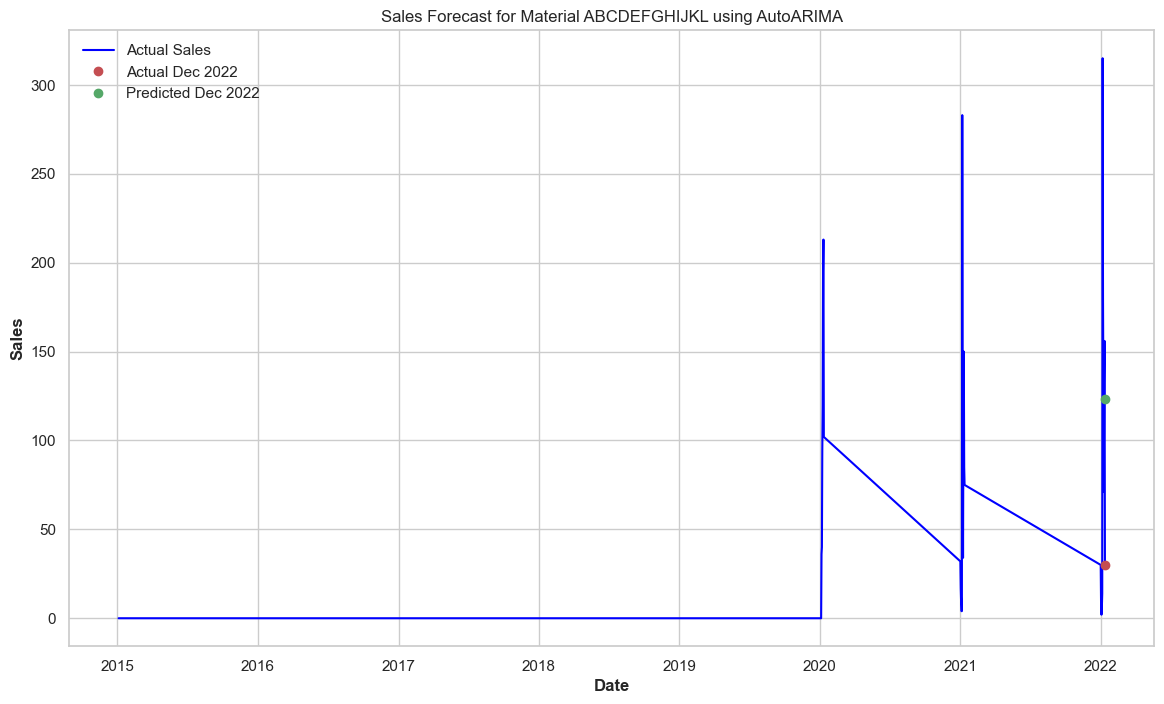

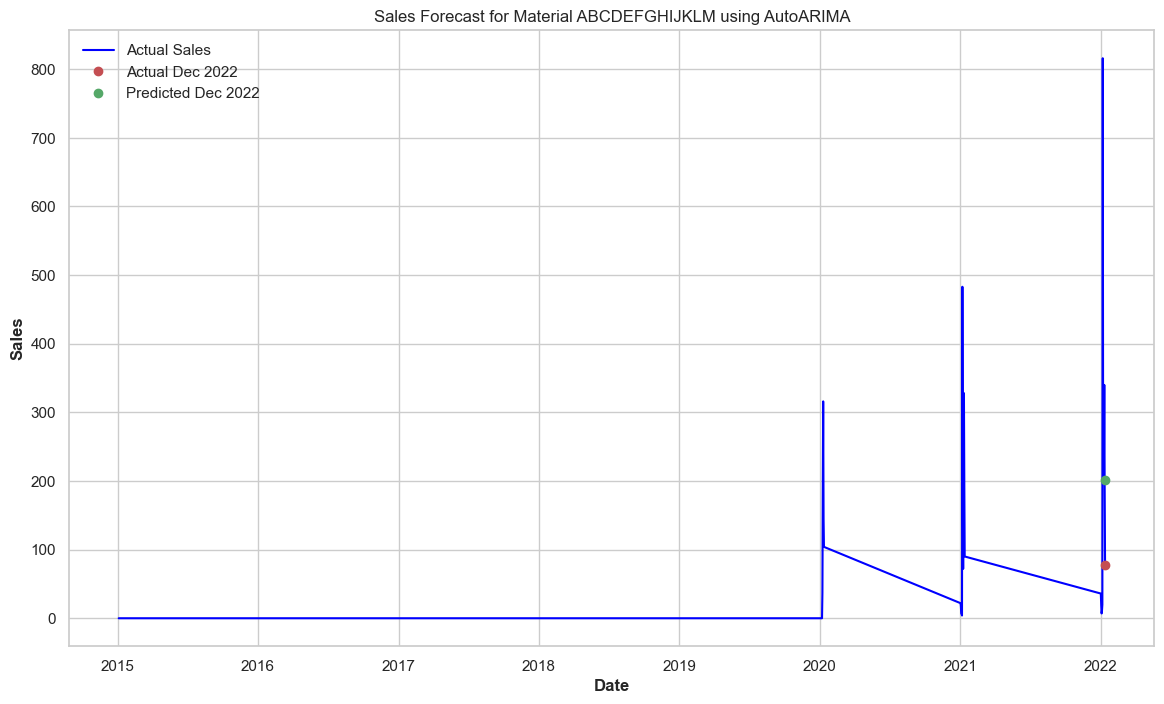

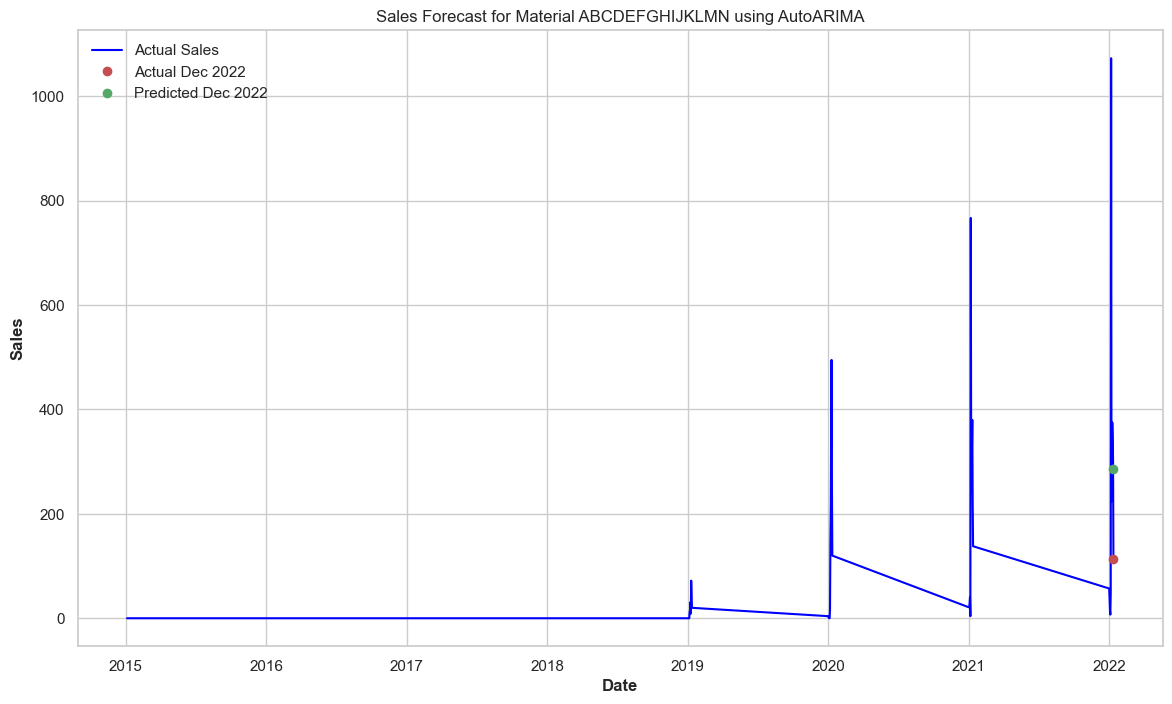

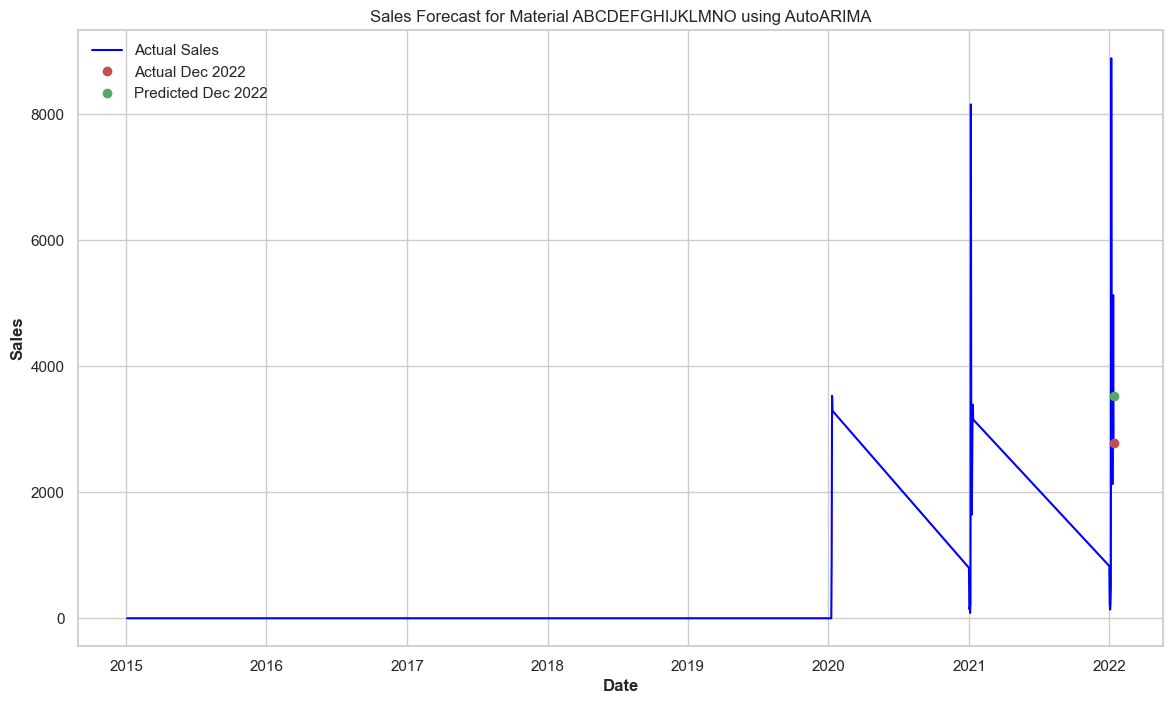

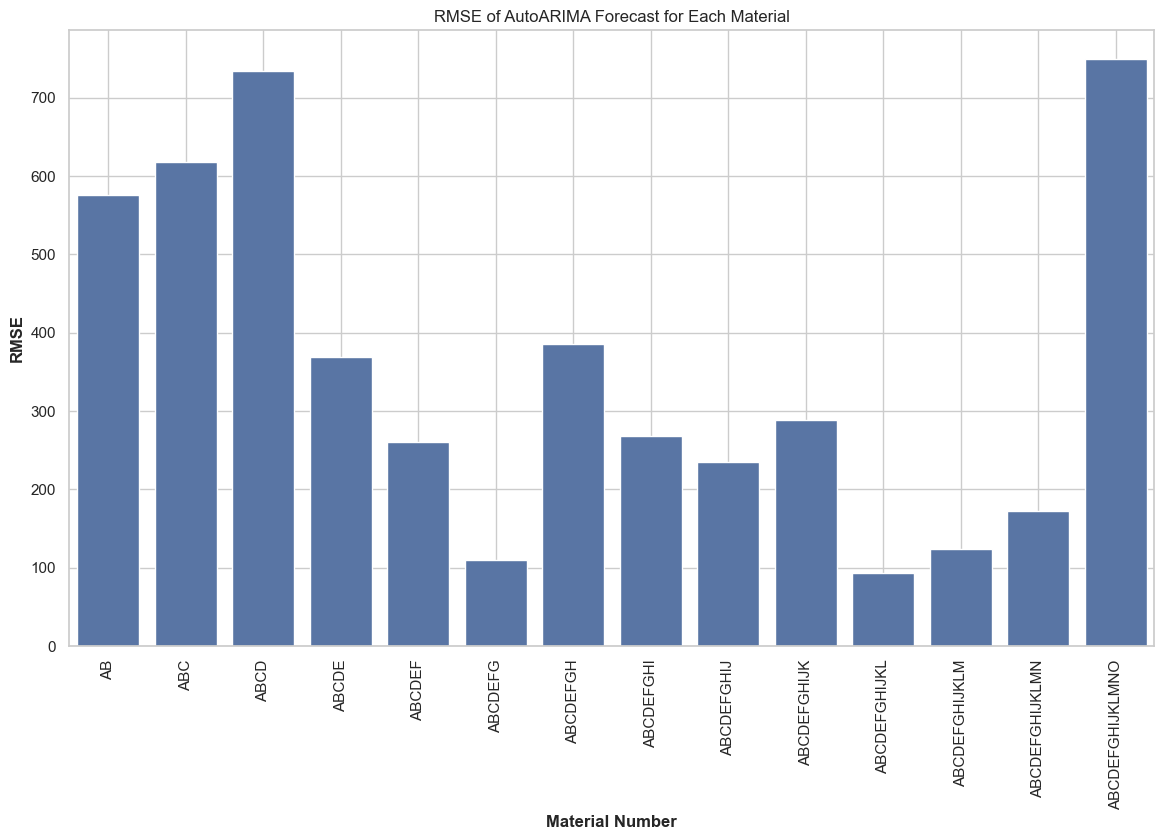

In [40]:
# Function to plot the results for a specific material using AutoARIMA
def plot_forecast_autoarima(df, material, actual, predicted):
    df_material = prepare_data(df, material)
    
    plt.figure(figsize=(14, 8))
    plt.plot(df_material.index, df_material['Sales'], label='Actual Sales', color='blue')
    plt.plot(df_material.index[-1:], actual, 'ro', label='Actual Dec 2022')
    plt.plot(df_material.index[-1:], predicted, 'go', label='Predicted Dec 2022')
    
    # forecast_index = pd.date_range(start=df_material.index[-1], periods=2, freq='M')[1]
    # plt.plot(forecast_index, predicted, 'go', label='Predicted Dec 2022')
    
    plt.title(f'Sales Forecast for Material {material} using AutoARIMA')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plotting results for all materials
for index, row in results_autoarima_df.iterrows():
    material = row['MaterialNumber']
    actual = row['Actual']
    predicted = row['Predicted']
    plot_forecast_autoarima(data, material, actual, predicted)

# Plot RMSE for all materials using AutoARIMA
plt.figure(figsize=(14, 8))
sns.barplot(x='MaterialNumber', y='RMSE', data=results_autoarima_df)
plt.title('RMSE of AutoARIMA Forecast for Each Material')
plt.xlabel('Material Number')
plt.ylabel('RMSE')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()


In [41]:
# Function to plot the results for a specific material using tuned SARIMA (parallel)
def plot_forecast_sarima_tuned_parallel(df, material, actual, predicted):
    df_material = prepare_data(df, material)
    
    plt.figure(figsize=(14, 8))
    plt.plot(df_material.index, df_material['Sales'], label='Actual Sales', color='blue')
    plt.plot(df_material.index[-1:], actual, 'ro', label='Actual Dec 2022')
    plt.plot(df_material.index[-1:], predicted, 'go', label='Predicted Dec 2022')
    
    # forecast_index = pd.date_range(start=df_material.index[-1], periods=2, freq='M')[1]
    # plt.plot(forecast_index, predicted, 'go', label='Predicted Dec 2022')
    
    plt.title(f'Tuned SARIMA Parallel Sales Forecast for Material {material}')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.grid(True)
    plt.show()

# Function to plot RMSE for all materials
def plot_rmse_sarima_tuned_parallel(results_df):
    plt.figure(figsize=(14, 8))
    sns.barplot(x='MaterialNumber', y='RMSE', data=results_df)
    plt.title('RMSE of Tuned SARIMA Parallel Forecast for Each Material')
    plt.xlabel('Material Number')
    plt.ylabel('RMSE')
    plt.xticks(rotation=90)
    plt.grid(True)
    plt.show()


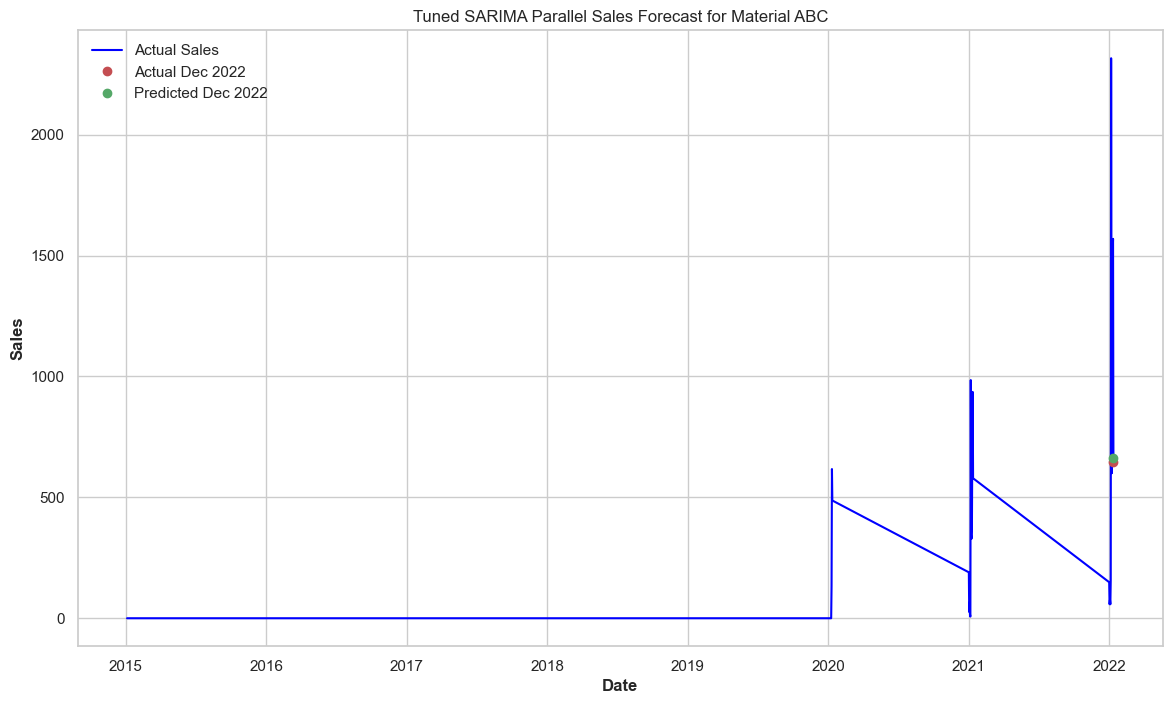

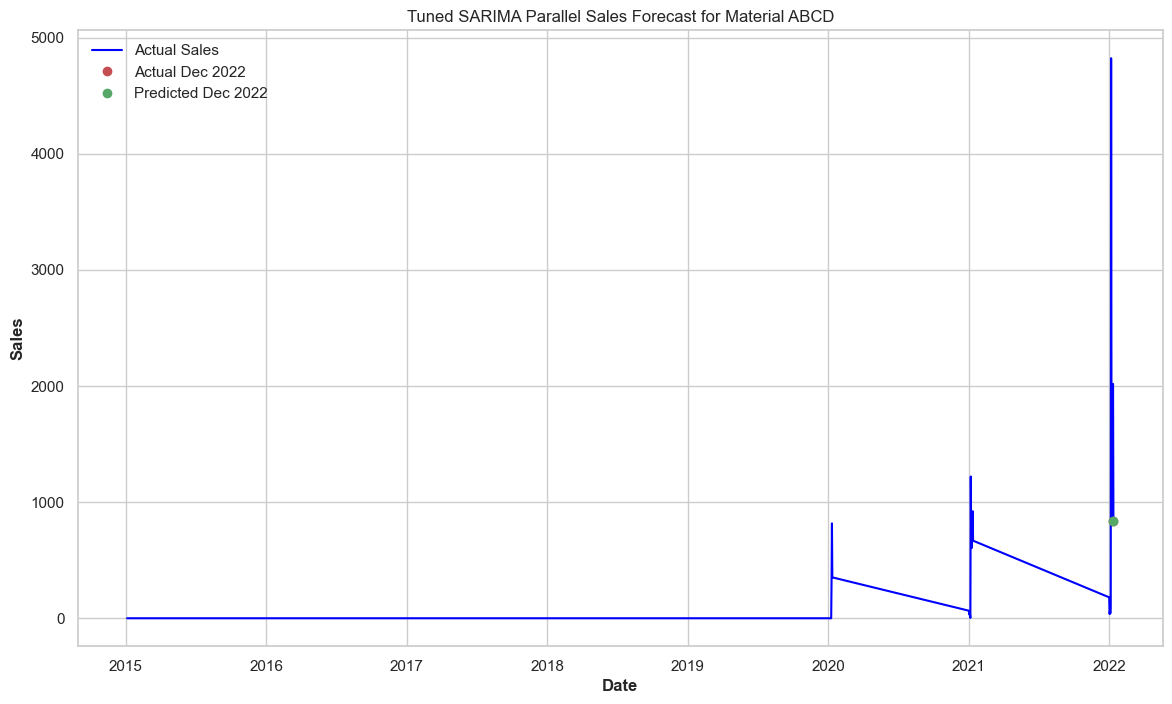

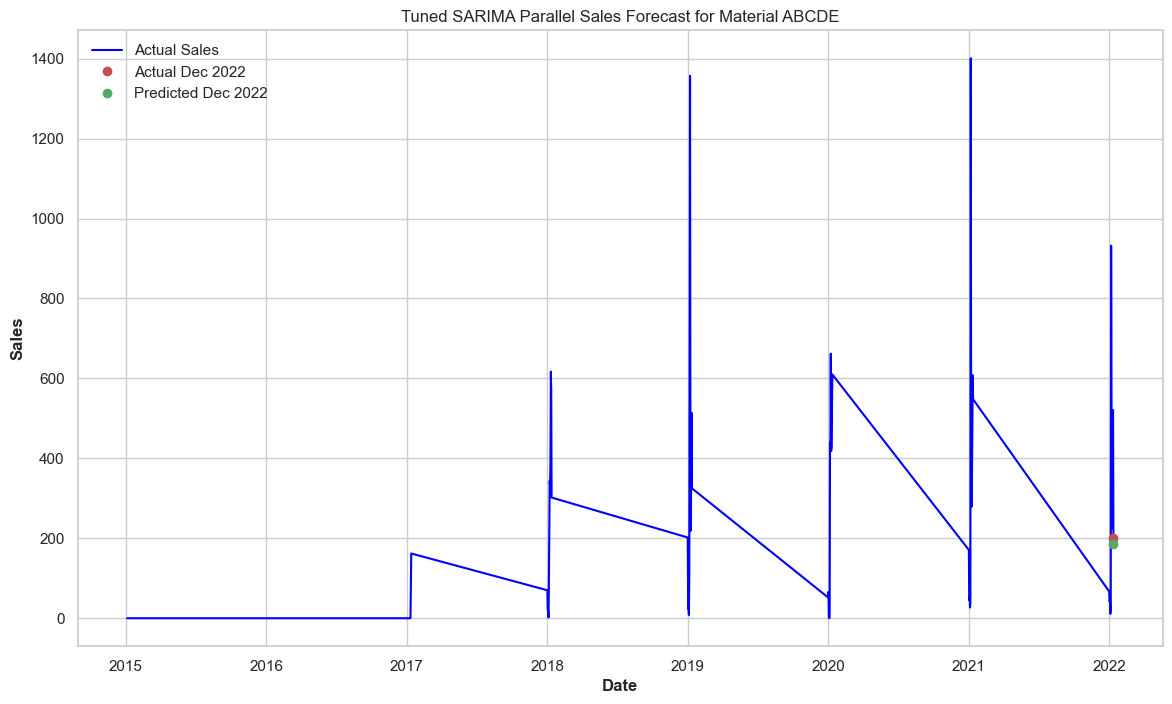

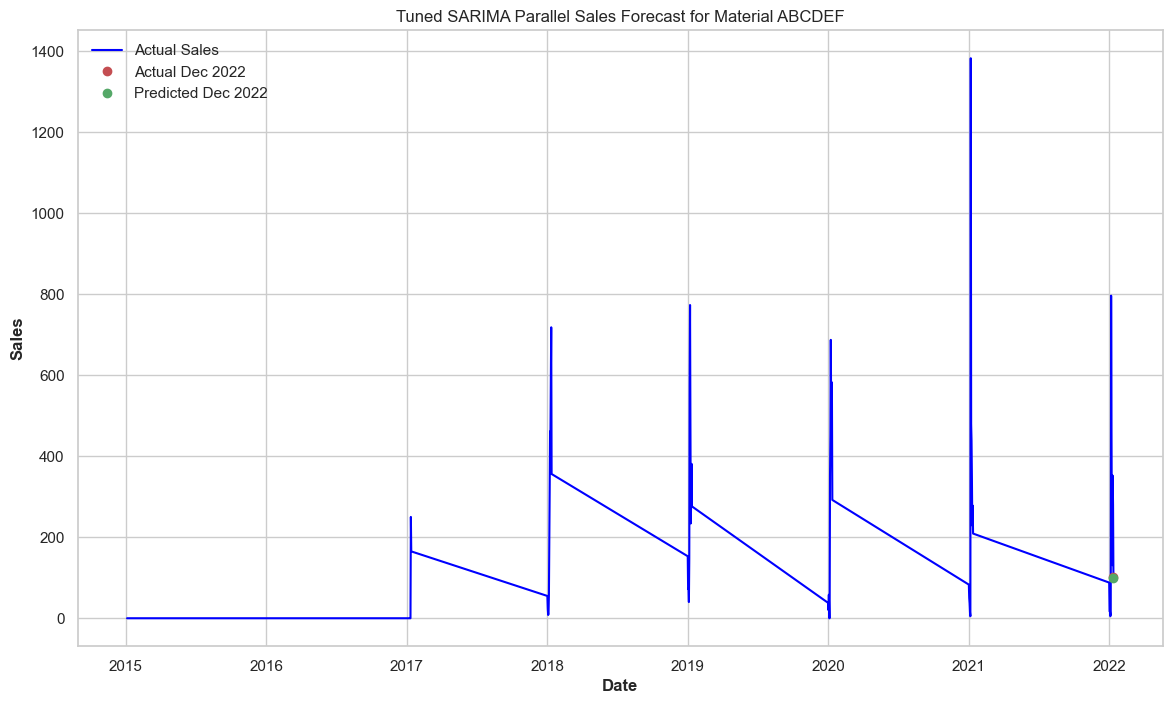

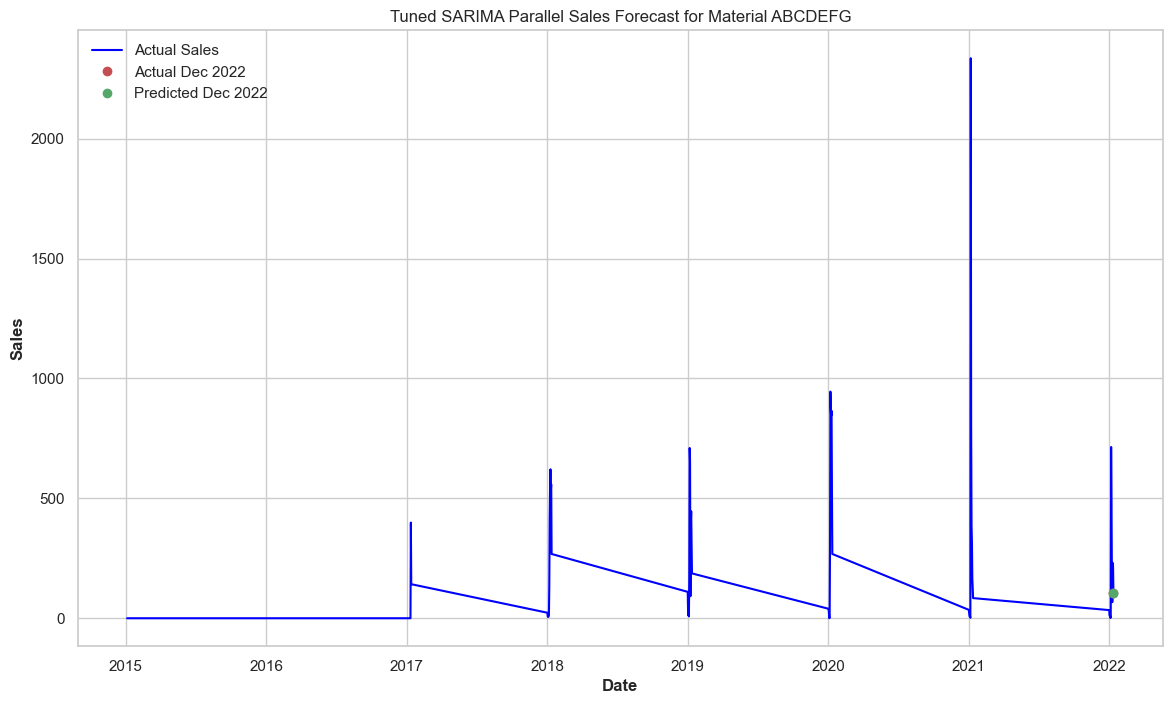

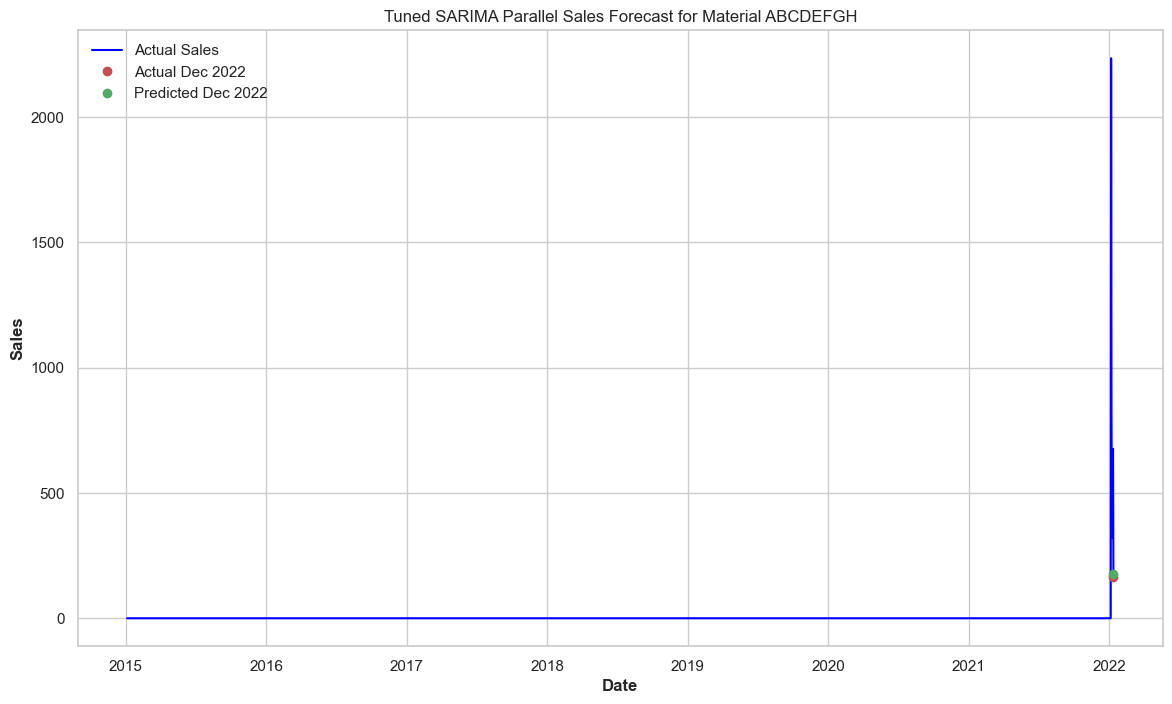

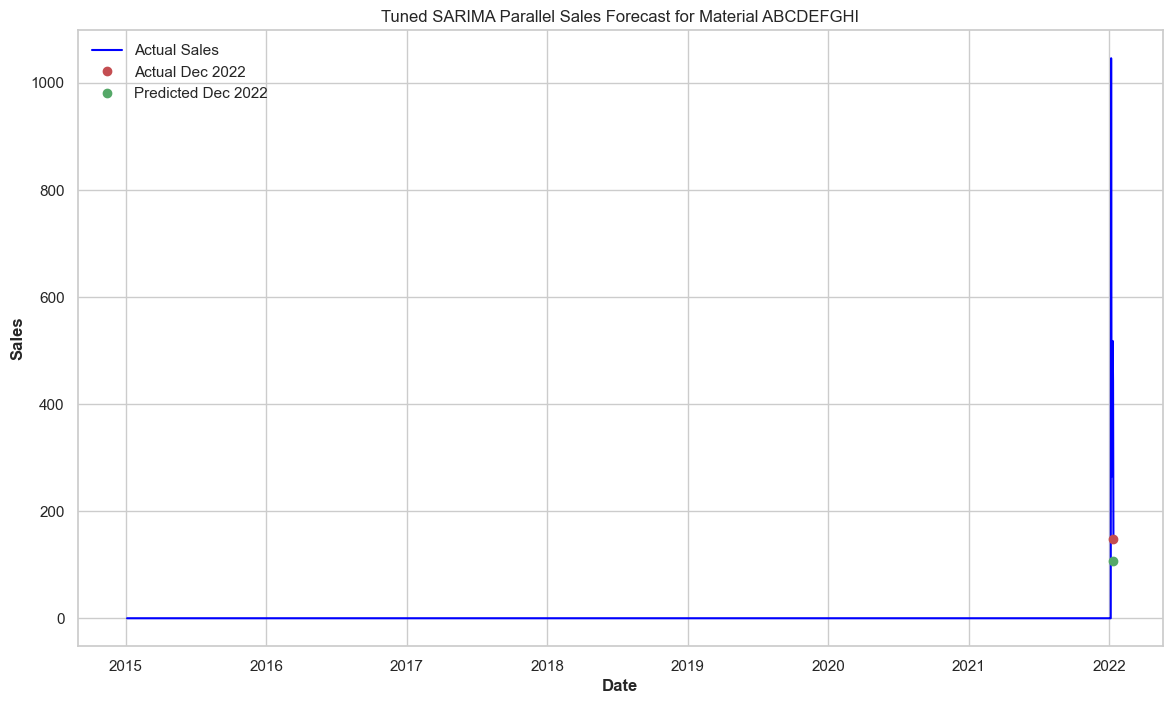

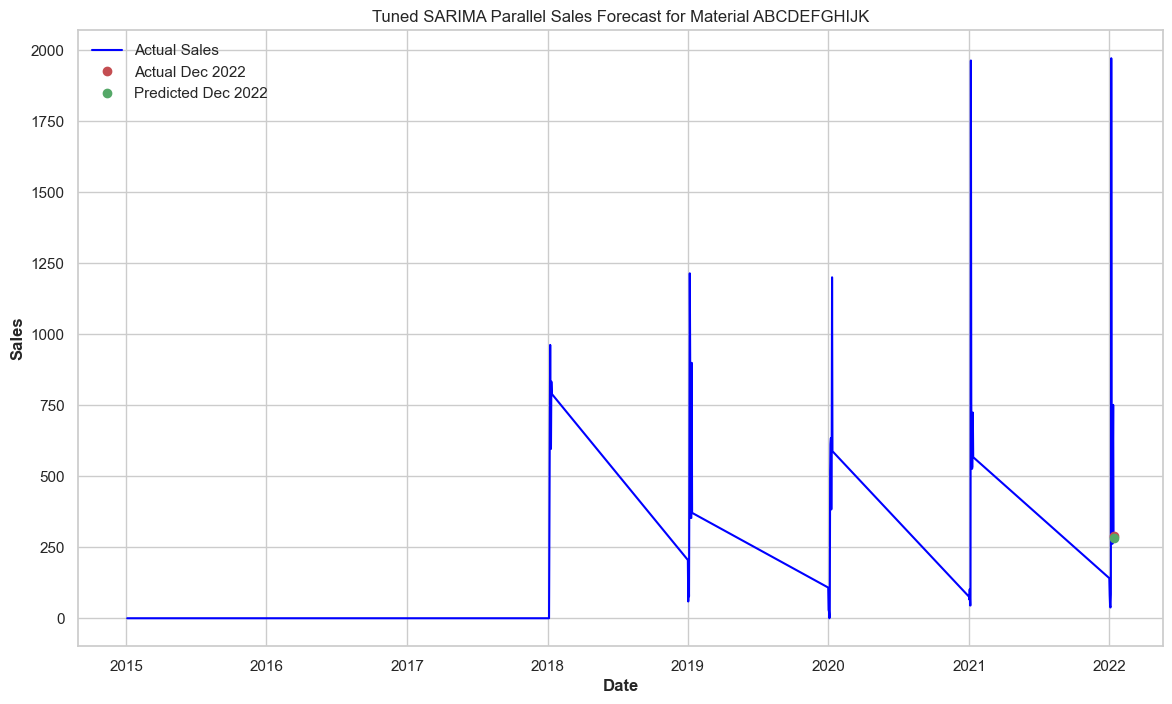

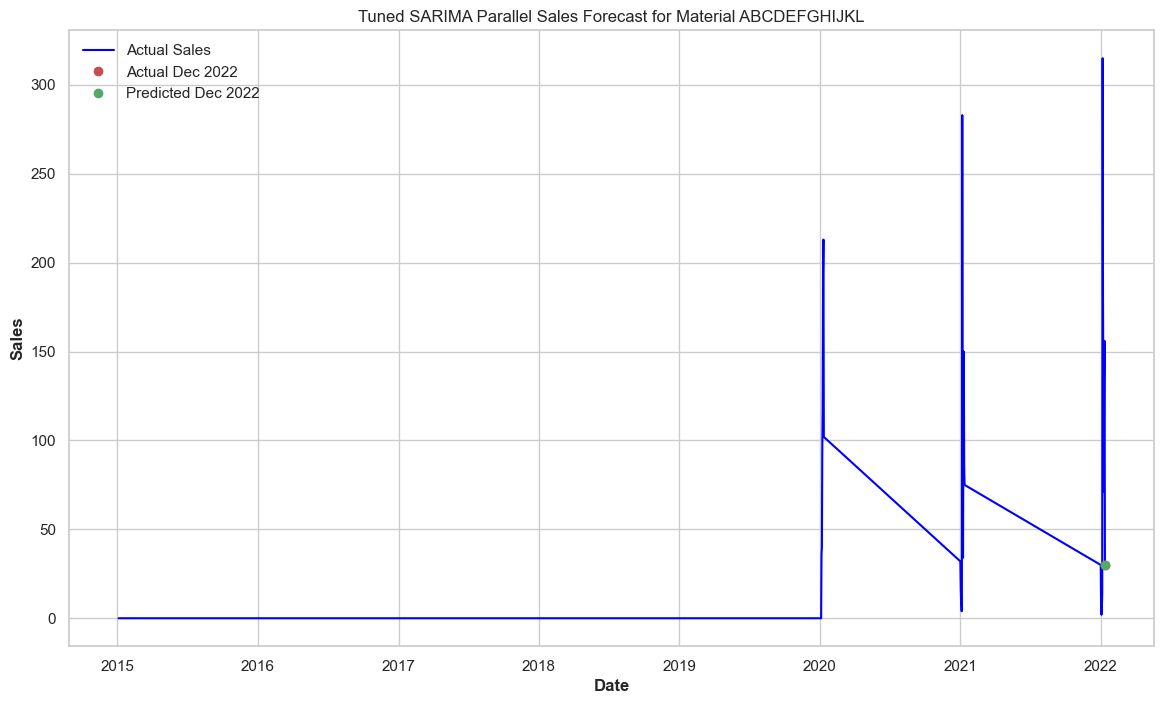

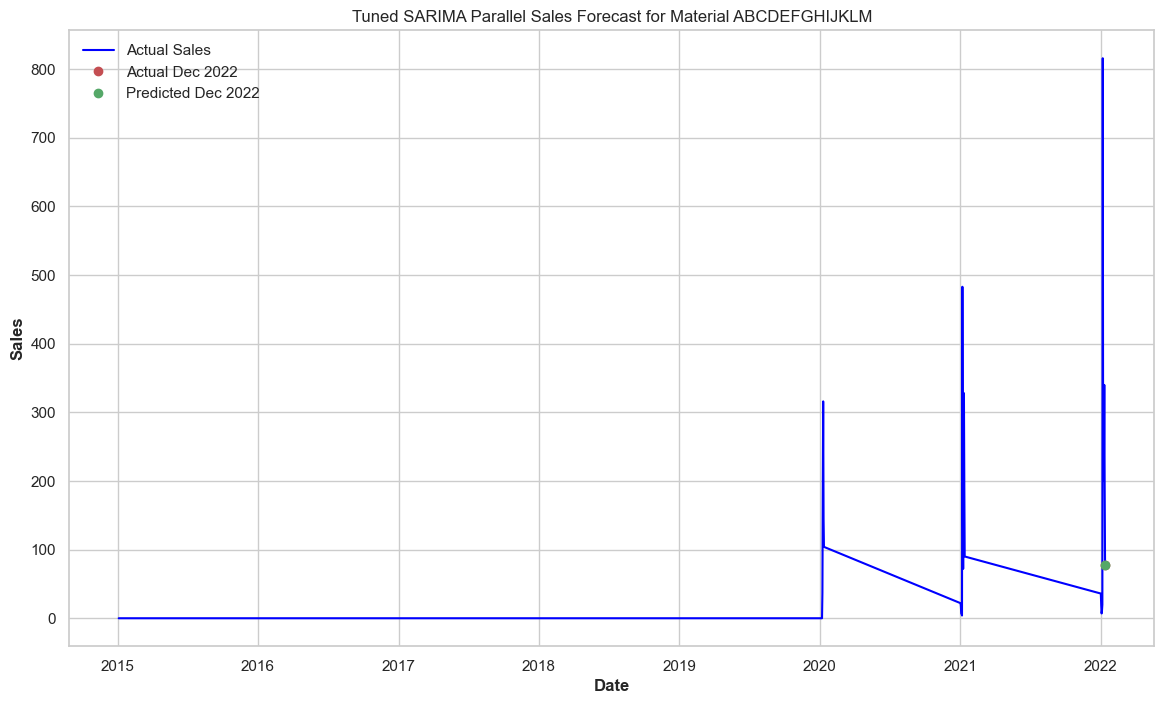

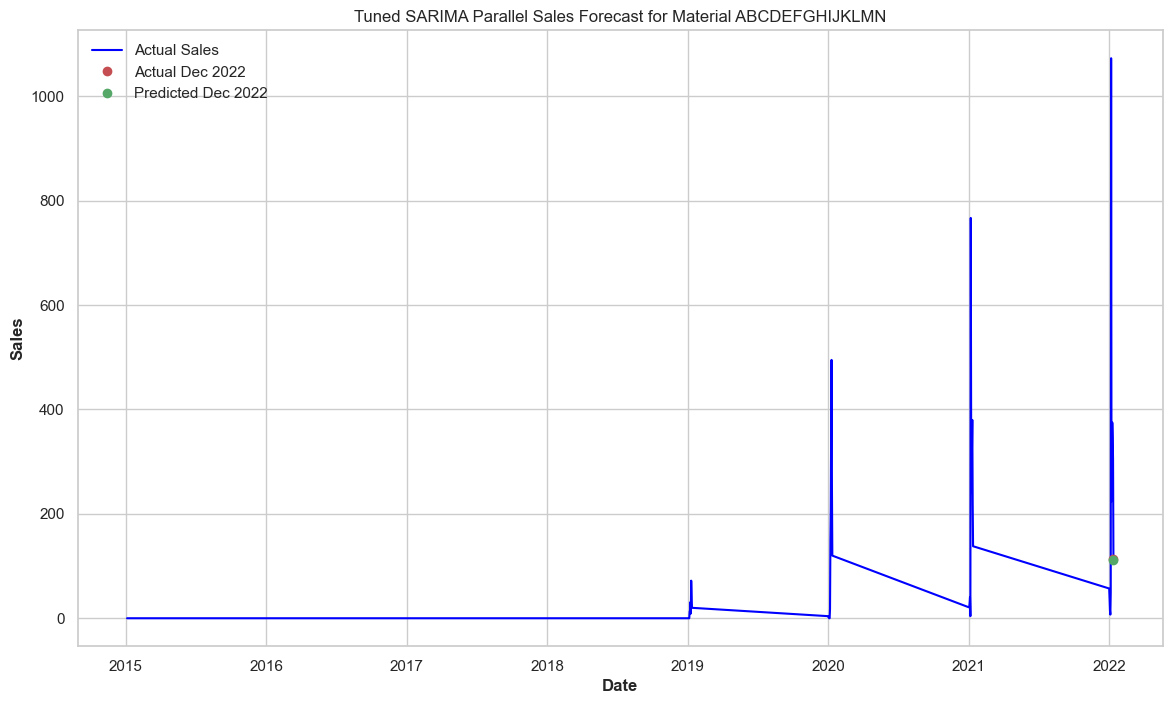

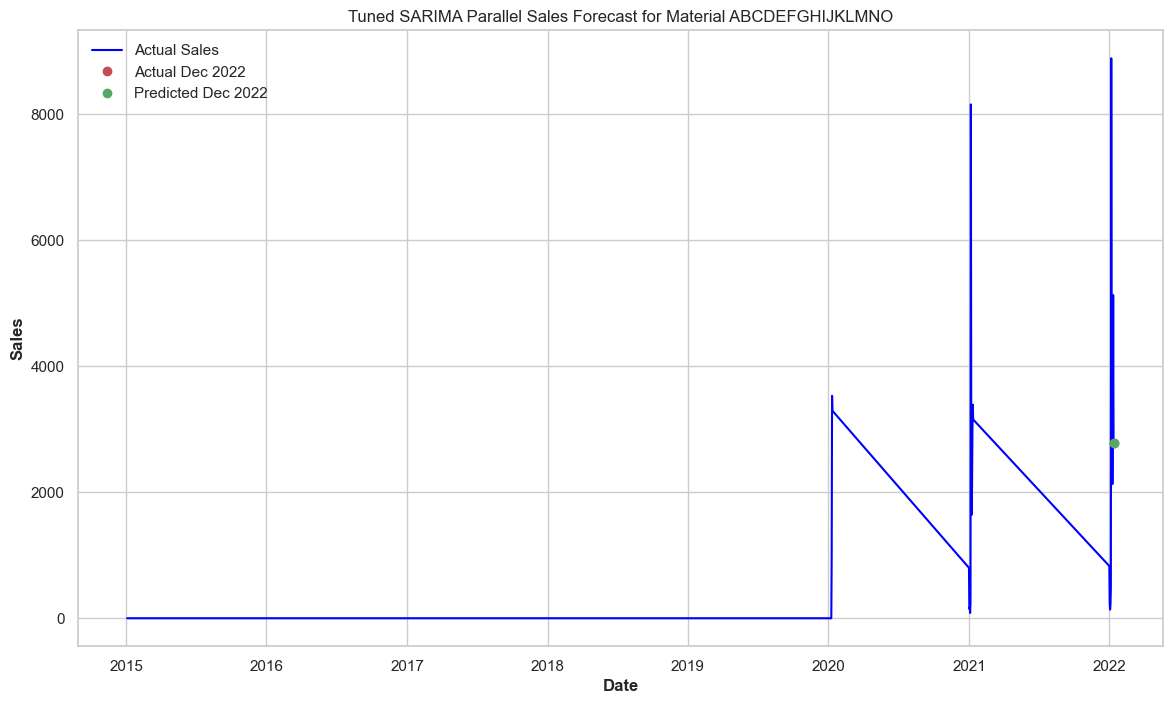

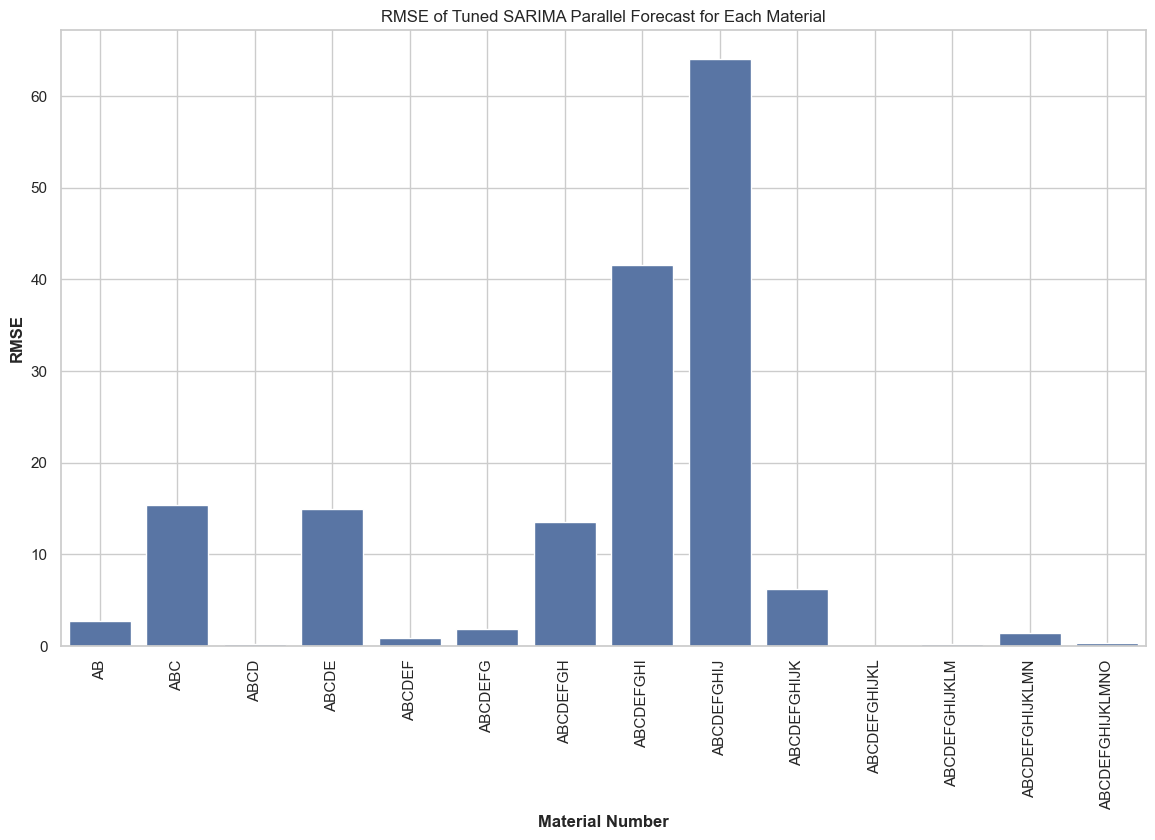

In [42]:
# Plotting results for all materials using tuned parallel SARIMA
for index, row in results_sarima_tuned_parallel_df.iterrows():
    material = row['MaterialNumber']
    actual = row['Actual']
    predicted = row['Predicted']
    plot_forecast_sarima_tuned_parallel(data, material, actual, predicted)

# Plot RMSE for all materials
plot_rmse_sarima_tuned_parallel(results_sarima_tuned_parallel_df)
